# Dữ liệu

## Gọi bộ dữ liệu

In [1]:
import pandas as pd

In [2]:
# Gọi bộ dữ liệu đã lưu, trong folder /content, đã chia Train/Valid : Test theo tỉ lệ 8:2
path = "../data/merged_data"
train_valid_processed_comments = pd.read_csv(f"{path}/merged_data.csv")
test_processed_comments = pd.read_csv("../data/preprocessed_data/preprocessed_test.csv")

In [3]:
train_valid_processed_comments.shape, test_processed_comments.shape

((8420, 3), (688, 3))

In [4]:
test_processed_comments.head(3)

Sentence   Emotion  \
0           người ta có bạn bè nhìn vui thật   Sadness   
1  cho nghỉ viêc mói đúng sao goi là kỷ luật  Surprise   
2                           kinh vãi phẫn_nộ   Disgust   

                                  Tokenized_Sentence  
0           ['người', 'ta', 'bạn bè', 'nhìn', 'vui']  
1  ['nghỉ', 'viêc', 'mói', 'đúng', 'sao', 'goi', ...  
2                            ['kinh vãi', 'phẫn_nộ']

## Chuyển đổi cột *Tokenized_Sentence* về danh sách từ

In [5]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'str'>
5 phần tử đầu tiên: ["['người', 'ta', 'bạn bè', 'nhìn', 'vui']", "['nghỉ', 'viêc', 'mói', 'đúng', 'sao', 'goi', 'kỷ luật']", "['kinh vãi', 'phẫn_nộ']", "['nhà', 'không', 'xa', 'lắm', 'nhưng', 'chưa', 'bao giờ', 'sợ', 'đè bẹp', 'luôn', 'người', 'cười']", "['bố', 'không', 'thích', 'nộp', 'đấy', 'mày', 'thích', 'ý kiến', 'không']"]


**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [6]:
import ast

# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
train_valid_processed_comments['Tokenized_Sentence'] = train_valid_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)
test_processed_comments['Tokenized_Sentence'] = test_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)

In [7]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['người', 'ta', 'bạn bè', 'nhìn', 'vui'], ['nghỉ', 'viêc', 'mói', 'đúng', 'sao', 'goi', 'kỷ luật'], ['kinh vãi', 'phẫn_nộ'], ['nhà', 'không', 'xa', 'lắm', 'nhưng', 'chưa', 'bao giờ', 'sợ', 'đè bẹp', 'luôn', 'người', 'cười'], ['bố', 'không', 'thích', 'nộp', 'đấy', 'mày', 'thích', 'ý kiến', 'không']]


# Tiền xử lý

## Tách các tập Train - Validation - Test và label

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state=11):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_train_valid.drop('Emotion', axis=1),
        df_train_valid['Emotion'],
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=df_train_valid['Emotion']
    )

    X_test = df_test.drop('Emotion', axis=1)
    y_test = df_test['Emotion']

    return X_train, X_valid, X_test, y_train, y_valid, y_test

## TF-IDF
**TF-IDF = Term Frequency * Inverse Document Frequency**
- Từ xuất hiện nhiều trong câu nhưng ít trong toàn bộ corpus => trọng số cao
- Từ phổ biến (stop words) => trọng số thấp

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [11]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

## Chuyển sang mảng numpy

In [12]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

In [13]:
def convert_full_to_array(train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix):
    return convert_to_array(train_tfidf_matrix), convert_to_array(valid_tfidf_matrix), convert_to_array(test_tfidf_matrix)

# Giảm chiều

## PCA
Giữ lại 90% thông tin sau khi PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
def pca(X_train_arr, X_test_arr, X_valid_arr, n_components=0.9):
    pca_model = PCA(n_components=n_components)
    X_train_pca = pca_model.fit_transform(X_train_arr)
    X_test_pca = pca_model.transform(X_test_arr)
    X_valid_pca = pca_model.transform(X_valid_arr)

    return pca_model, X_train_pca, X_test_pca, X_valid_pca

## LDA

- Tìm ma trận W chiếu DL vào không gian LDA
- Sau khi học được W, tính các hàm phân biệt tuyến tính (linear discriminats) để dự đoán lớp
- Thay vì mỗi TPC giữ một phần thông tin như PCA, thì LDA sẽ giữ một phần thông tin giúp phân biệt giữa các lớp
- Vì thế, LDA có thể giảm còn số chiều max là (n-1) chiều (n là số nhãn)

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### LDA còn 6 chiều

In [17]:
def lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components):
    lda = LDA(n_components=n_components)
    X_train_lda =lda.fit_transform(X_train_arr, y_train)
    X_test_lda = lda.transform(X_test_arr)
    X_valid_lda = lda.transform(X_valid_arr)

    return lda, X_train_lda, X_test_lda, X_valid_lda

- LDA tìm ra 6 hướng giúp phân biệt tâm của 7 label
- Các vector riêng của S_w^-1 * S_B mô tả toàn bộ thông tin phân biệt giữa các lớp, tức là TOÀN BỘ KHẢ NĂNG PHÂN BIỆT đã ở trong 6 chiều này

## Hàm lựa chọn giảm chiều theo cách nào

In [18]:
def use_discriminant(X_train_arr, y_train, X_test_arr, X_valid_arr, discriminant="none", n_components_pca=0.9, n_components_lda=6):
    if discriminant == "pca":
        return pca(X_train_arr, X_test_arr, X_valid_arr, n_components_pca)

    elif discriminant == "lda":
        return lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components_lda)

    return None, X_train_arr, X_test_arr, X_valid_arr

# Model phân loại

In [19]:
import time

## HOI QUY SOFTMAX - MULTINOMIAL LOGISTIC REGRESSION

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [22]:
def log_reg(X_train, y_train, random_state=11, max_iter=1000):
    log_reg = LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        random_state=random_state,
        max_iter=max_iter)

    log_reg.fit(X_train, y_train)

    return log_reg

## K-NN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
def knn(X_train, y_train, metric = 'cosine'):
    knn = KNeighborsClassifier(
    n_neighbors=83,
    metric=metric,
    n_jobs=-1)  # Dùng tất cả CPU cores để tăng tốc độ chạy

    knn.fit(X_train, y_train)

    return knn

## Hàm lựa chọn mô hình và dự đoán

In [25]:
def use_model(model_type, X_train_processed, y_train, metric='cosine', max_iter=1000,
              C=1.0, svm_kernel='rbf', svm_gamma='scale', svm_degree=3,
              tree_max_depth=None, nb_alpha=1.0,
              mlp_hidden=(128,), mlp_alpha=1e-4,
              random_state=11):
    if model_type == 'logistic_regression':
        model = LogisticRegression(
            C=C,
            multi_class='multinomial',
            class_weight='balanced',
            max_iter=max_iter,
            random_state=random_state
        )
    elif model_type == 'knn':
        model = knn(X_train_processed, y_train, metric)
    elif model_type == 'svm':
        if svm_kernel == 'linear':
            model = LinearSVC(C=C, class_weight='balanced', random_state=random_state)
        elif svm_kernel == 'poly':
            model = SVC(C=C, kernel='poly', degree=svm_degree, gamma=svm_gamma, class_weight='balanced', random_state=random_state)
        else:
            model = SVC(C=C, kernel=svm_kernel, gamma=svm_gamma, class_weight='balanced', random_state=random_state)
    elif model_type == 'naive_bayes':
        model = MultinomialNB(alpha=nb_alpha)
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(
            max_depth=tree_max_depth,
            min_samples_leaf=2,
            random_state=random_state
        )
    elif model_type == 'mlp':
        model = MLPClassifier(
            hidden_layer_sizes=mlp_hidden,
            alpha=mlp_alpha,
            max_iter=max_iter,
            random_state=random_state
        )
    else:
        raise ValueError(f'Unknown model_type: {model_type}')

    if model_type in ['knn']:
        # KNN is trained inside knn()
        return model

    model.fit(X_train_processed, y_train)
    return model


In [26]:
def predict(model, X_train, X_valid, X_test):
    # model là log_reg, knn hoặc svm

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_valid, y_pred_test

## Đánh giá độ chính xác và trực quan

### Đánh giá độ chính xác

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [28]:
def get_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='weighted'), recall_score(y_true, y_pred, average='weighted'), f1_score(y_true, y_pred, average='weighted')

In [29]:
def get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test):
    accuracy_train, precision_train, recall_train, f1_train = get_metrics(y_train, y_pred_train)
    accuracy_valid, precision_valid, recall_valid, f1_valid = get_metrics(y_valid, y_pred_valid)
    accuracy_test, precision_test, recall_test, f1_test = get_metrics(y_test, y_pred_test)

    return [accuracy_train, precision_train, recall_train, f1_train], [accuracy_valid, precision_valid, recall_valid, f1_valid], [accuracy_test, precision_test, recall_test, f1_test]

In [30]:
def print_metrics(accuracy, precision, recall, f1):
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-score:", f1)

### Trực quan

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# vẽ ma trận nhầm lẫn
def plot_normalized_confusion_matrix(y_true, y_pred, title='Normalized Confusion Matrix'):
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
    classes = np.unique(y_true)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [33]:
# hàm vẽ cả 3 ma trận nhầm lẫn cho cả 3 tập train - valid - test
def plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                          title='Normalized Confusion Matrix', discriminant="none", model_type="logistic_regression"):
    plot_normalized_confusion_matrix(y_train, y_pred_train, title=title + " Train " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_valid, y_pred_valid, title=title + " Valid " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_test, y_pred_test, title=title + " Test " + discriminant + " " + model_type)

# Pipeline cho bài toán phân loại

## Chuẩn bị dữ liệu 

In [34]:
def prepare_data_for_modeling(df_train_valid, df_test, train_size, valid_size, random_state=11,
                              min_df=2, max_df=0.95, max_features=8000,
                              discriminant="none", n_components_pca=0.9, n_components_lda=6):
    "TF-IDF, PCA/LDA trước khi vào pipeline modeling"
    
    # Chia train-valid
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(
        df_train_valid, df_test, train_size, valid_size, random_state
    )

    # TF-IDF Vectorization
    train_tfidf_matrix, tfidf_vectorizer = tfidf_embedding(
        X_train['Tokenized_Sentence'], 
        max_features=max_features, 
        min_df=min_df, 
        max_df=max_df
    )

    # Transform cho valid và test
    valid_tfidf_matrix = tfidf_transform(X_valid['Tokenized_Sentence'], tfidf_vectorizer)
    test_tfidf_matrix = tfidf_transform(X_test['Tokenized_Sentence'], tfidf_vectorizer)

    # Chuyển sang mảng numpy
    X_train_processed, X_valid_processed, X_test_processed = convert_full_to_array(
        train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix
    )

    # Giảm chiều (None / PCA / LDA)
    discriminant_model, X_train_processed, X_test_from_disc, X_valid_from_disc = use_discriminant(
        X_train_processed, y_train, X_test_processed, X_valid_processed,
        discriminant, n_components_pca, n_components_lda
    )
    X_valid_processed = X_valid_from_disc
    X_test_processed = X_test_from_disc

    # Trả về 
    # 1. DL đã processed (TF-IDF và có thể giảm chiều) 
    # 2. Nhãn của tập train - test - valid
    # 3. vectorize đã fit trên train
    # 4. Model giảm chiều đã fit trên train
    return (X_train_processed, X_valid_processed, X_test_processed, 
            y_train, y_valid, y_test, 
            tfidf_vectorizer, discriminant_model)

In [35]:
def pipeline_modeling(X_train, X_valid, X_test, y_train, y_valid, y_test,
                      model_type='logistic_regression', max_iter=1000, metric='cosine', model_params=None):

    if model_params is None:
        model_params = {}

    # Huấn luyện mô hình
    model = use_model(
        model_type, X_train, y_train, metric=metric, max_iter=max_iter, **model_params
    )

    # Dự đoán
    y_pred_train, y_pred_valid, y_pred_test = predict(model, X_train, X_valid, X_test)

    return model, [X_train, y_train], [X_valid, y_valid], [X_test, y_test], [y_pred_train, y_pred_valid, y_pred_test]


## Đánh giá độ chính xác và trực quan

In [37]:
# đánh giá độ chính xác và trực quan
def pipeline_evaluation(y_train, y_valid, y_test,
                        y_pred_train, y_pred_valid, y_pred_test,
                        train_size, valid_size, discriminant, model_type,
                        show_plot=True):

    metrics_train, metrics_valid, metrics_test = get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test)

    # train
    print(f"--- train --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_train[0], metrics_train[1], metrics_train[2], metrics_train[3])

    print()

    # valid
    print(f"--- valid --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_valid[0], metrics_valid[1], metrics_valid[2], metrics_valid[3])

    print()

    # test
    print(f"--- test --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_test[0], metrics_test[1], metrics_test[2], metrics_test[3])

    # trực quan
    if show_plot: plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                                        discriminant=discriminant, model_type=model_type)

# **Chạy pipeline**

# Train:Validation = 8:2

## Logistic Regression

### Bộ dữ liệu không giảm chiều

In [40]:
X_train_82, X_valid_82, X_test_82, y_train_82, y_valid_82, y_test_82, tfidf_vec_82, disc_model_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="none"
)

TF-IDF hoàn thành!
Shape: (6736, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 89421


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.8035926365795725
Recall: 0.8035926365795725
Precision: 0.8104233931280598
F1-score: 0.8028196645882332

--- valid --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5261282660332541
Recall: 0.5261282660332541
Precision: 0.5347638436281449
F1-score: 0.5268083475234125

--- test --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5319767441860465
Recall: 0.5319767441860465
Precision: 0.5599463732506819
F1-score: 0.5389030083552457


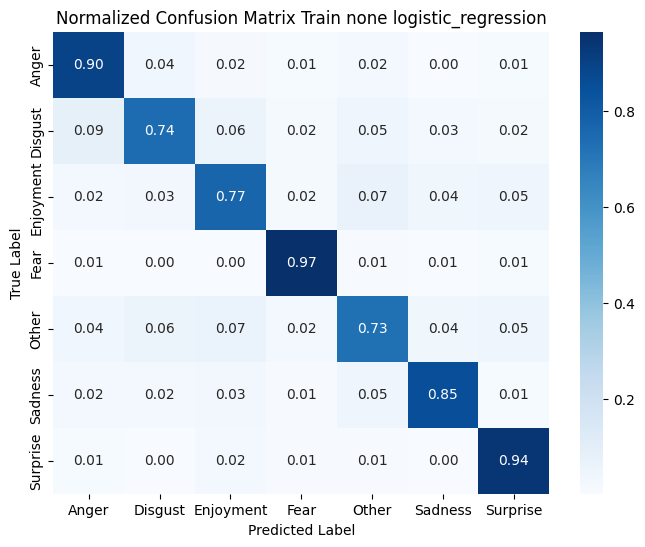

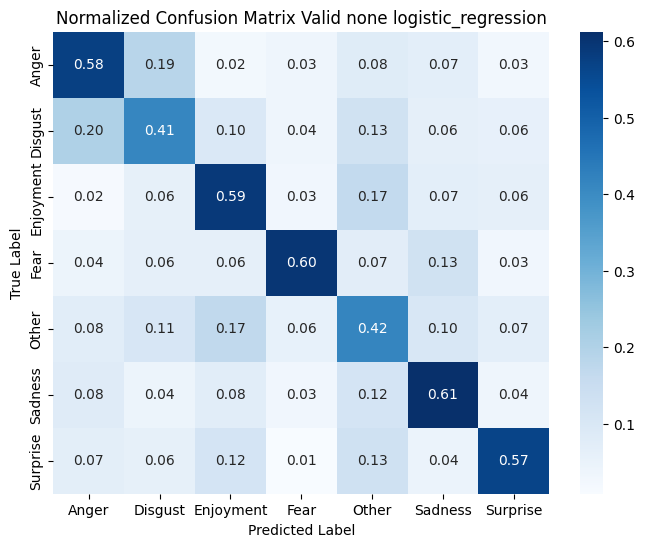

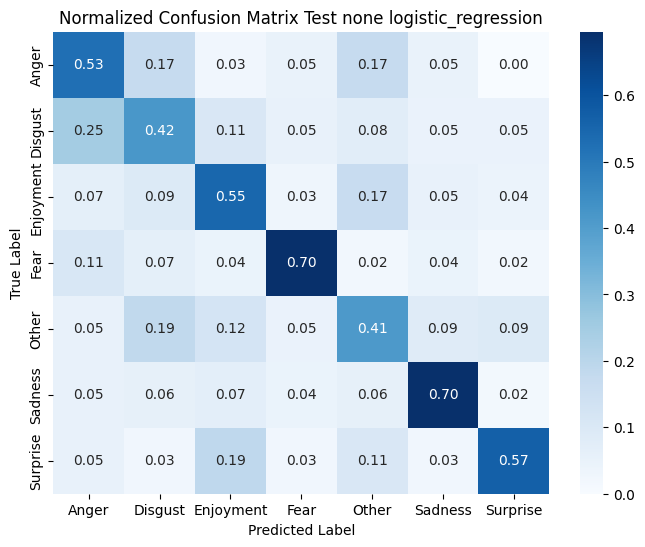

In [41]:
model_82, train_82, valid_82, test_82, pred_82 = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="logistic_regression",
    max_iter=1000
)

# Dự đoán từ pipeline_modeling
y_pred_train_82, y_pred_valid_82, y_pred_test_82 = pred_82

pipeline_evaluation(
    y_train_82, y_valid_82, y_test_82,
    y_pred_train_82, y_pred_valid_82, y_pred_test_82,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6736, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 89421


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.7658847980997625
Recall: 0.7658847980997625
Precision: 0.7745075956313109
F1-score: 0.7651369789773383

--- valid --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5219714964370546
Recall: 0.5219714964370546
Precision: 0.5308446366908225
F1-score: 0.5219136273703019

--- test --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5290697674418605
Recall: 0.5290697674418605
Precision: 0.5601967493172152
F1-score: 0.5369568070652829


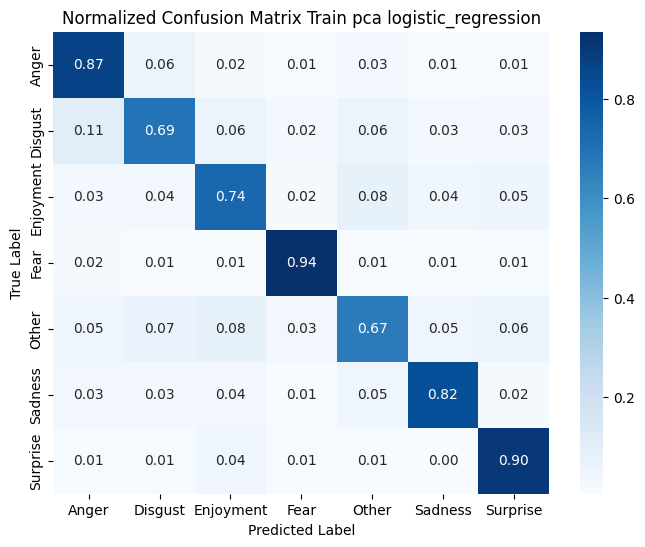

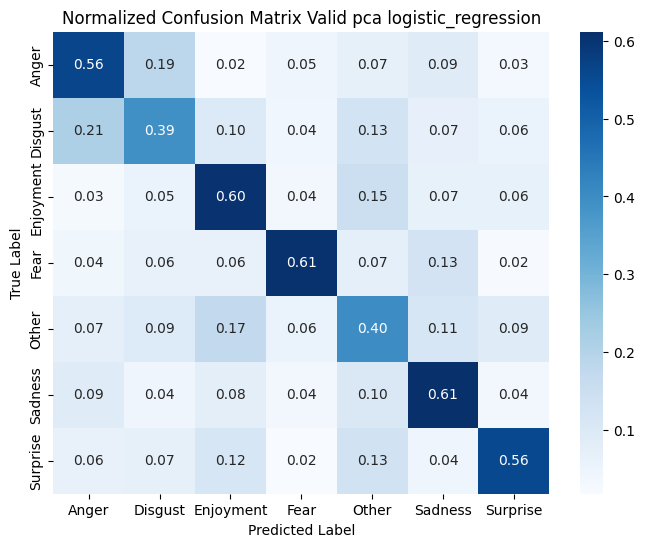

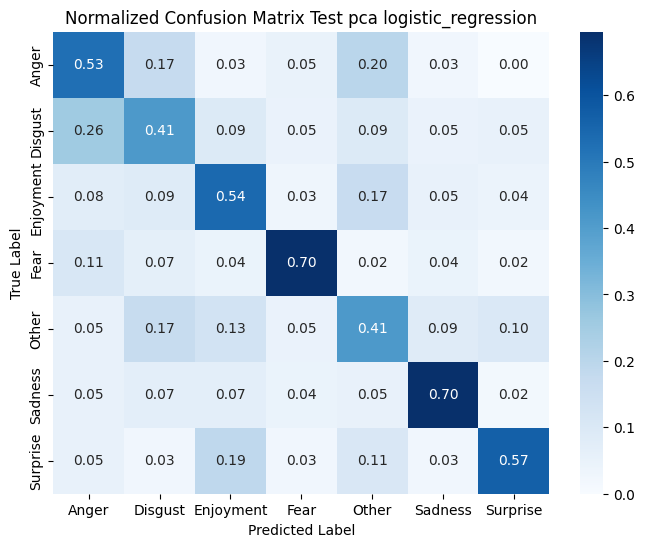

In [42]:
# Chuẩn bị dữ liệu với PCA
X_train_pca_82, X_valid_pca_82, X_test_pca_82, y_train_pca_82, y_valid_pca_82, y_test_pca_82, tfidf_vec_pca_82, disc_model_pca_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="pca"
)

# Chạy mô hình Logistic Regression trên dữ liệu PCA
model_pca_82, train_pca_82, valid_pca_82, test_pca_82, pred_pca_82 = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_pca_82, y_valid_pca_82, y_test_pca_82 = train_pca_82[1], valid_pca_82[1], test_pca_82[1]
y_pred_train_pca_82, y_pred_valid_pca_82, y_pred_test_pca_82 = pred_pca_82

pipeline_evaluation(
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    y_pred_train_pca_82, y_pred_valid_pca_82, y_pred_test_pca_82,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6736, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 89421


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.9977731591448931
Recall: 0.9977731591448931
Precision: 0.9978030246310176
F1-score: 0.9977802748394203

--- valid --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.24109263657957244
Recall: 0.24109263657957244
Precision: 0.2589753928973959
F1-score: 0.2442765927984365

--- test --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.24709302325581395
Recall: 0.24709302325581395
Precision: 0.28492538766399
F1-score: 0.25782819055865014


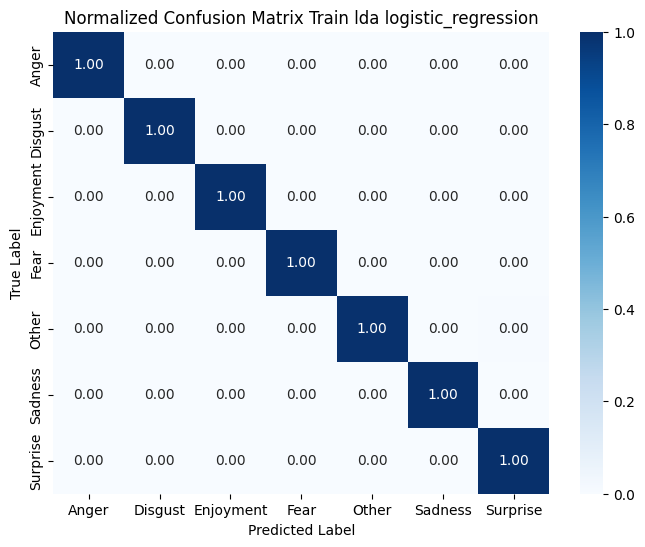

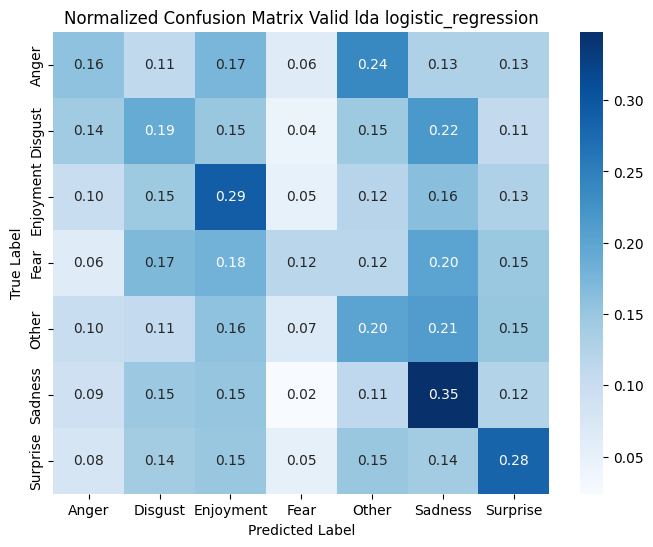

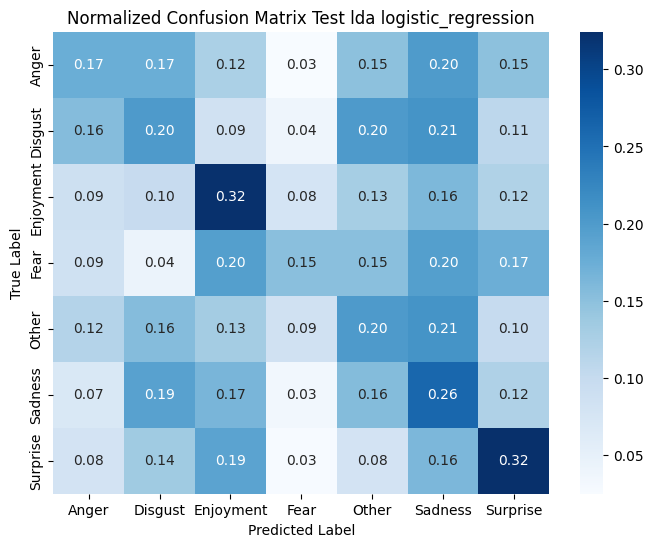

In [43]:
# Chuẩn bị dữ liệu với LDA
X_train_lda_82, X_valid_lda_82, X_test_lda_82, y_train_lda_82, y_valid_lda_82, y_test_lda_82, tfidf_vec_lda_82, disc_model_lda_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="lda"
)

# Chạy mô hình Logistic Regression trên dữ liệu LDA
model_lda_82, train_lda_82, valid_lda_82, test_lda_82, pred_lda_82 = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_lda_82, y_valid_lda_82, y_test_lda_82 = train_lda_82[1], valid_lda_82[1], test_lda_82[1]
y_pred_train_lda_82, y_pred_valid_lda_82, y_pred_test_lda_82 = pred_lda_82

pipeline_evaluation(
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    y_pred_train_lda_82, y_pred_valid_lda_82, y_pred_test_lda_82,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

--- train --- 8:2 --- knn --- none ---
Accuracy: 0.49228028503562943
Recall: 0.49228028503562943
Precision: 0.5348942359954294
F1-score: 0.46708323031991533

--- valid --- 8:2 --- knn --- none ---
Accuracy: 0.45902612826603323
Recall: 0.45902612826603323
Precision: 0.49089820159250147
F1-score: 0.4363577379038656

--- test --- 8:2 --- knn --- none ---
Accuracy: 0.4752906976744186
Recall: 0.4752906976744186
Precision: 0.5211498407636166
F1-score: 0.4573668241051678


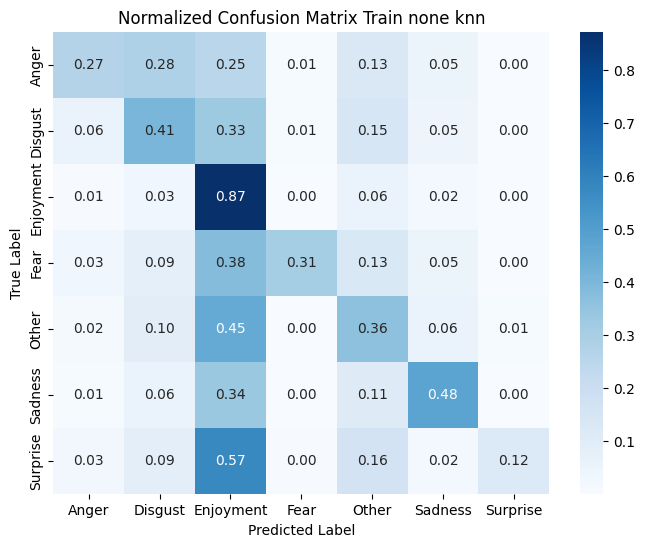

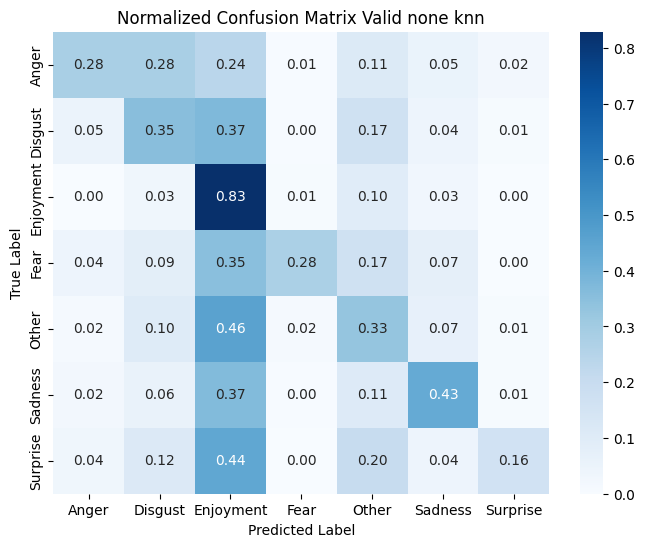

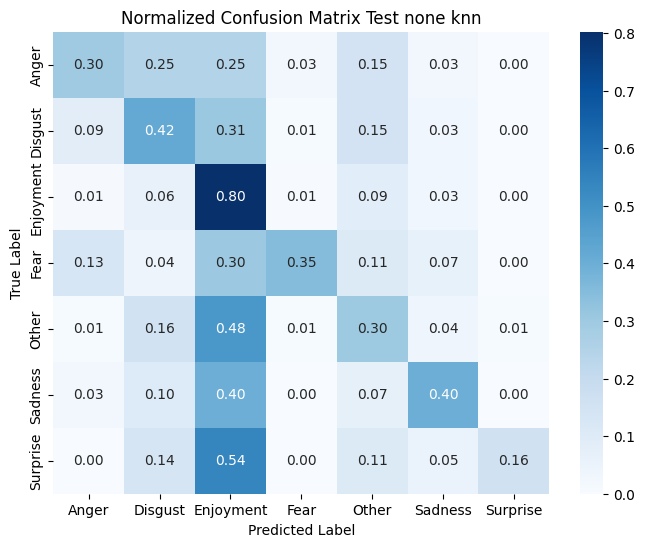

In [44]:
# Chạy KNN - cosine - None
model_82_knn, train_82_knn, valid_82_knn, test_82_knn, pred_82_knn = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="knn"
)

y_train_82_knn, y_valid_82_knn, y_test_82_knn = train_82_knn[1], valid_82_knn[1], test_82_knn[1]
y_pred_train_82_knn, y_pred_valid_82_knn, y_pred_test_82_knn = pred_82_knn

pipeline_evaluation(
    y_train_82_knn, y_valid_82_knn, y_test_82_knn,
    y_pred_train_82_knn, y_pred_valid_82_knn, y_pred_test_82_knn,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

--- train --- 8:2 --- knn_euclidean --- none ---
Accuracy: 0.49331947743467935
Recall: 0.49331947743467935
Precision: 0.5375059845968093
F1-score: 0.4726294885321401

--- valid --- 8:2 --- knn_euclidean --- none ---
Accuracy: 0.45605700712589076
Recall: 0.45605700712589076
Precision: 0.4967064316920614
F1-score: 0.43834120196613346

--- test --- 8:2 --- knn_euclidean --- none ---
Accuracy: 0.4578488372093023
Recall: 0.4578488372093023
Precision: 0.4924326620976785
F1-score: 0.44076645949540383


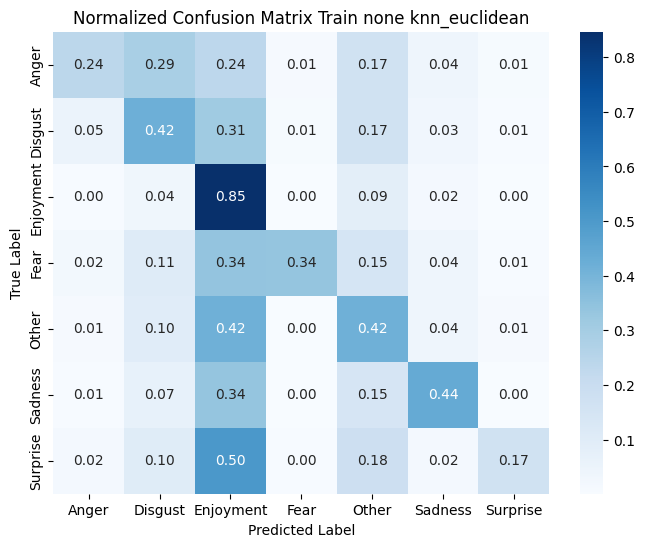

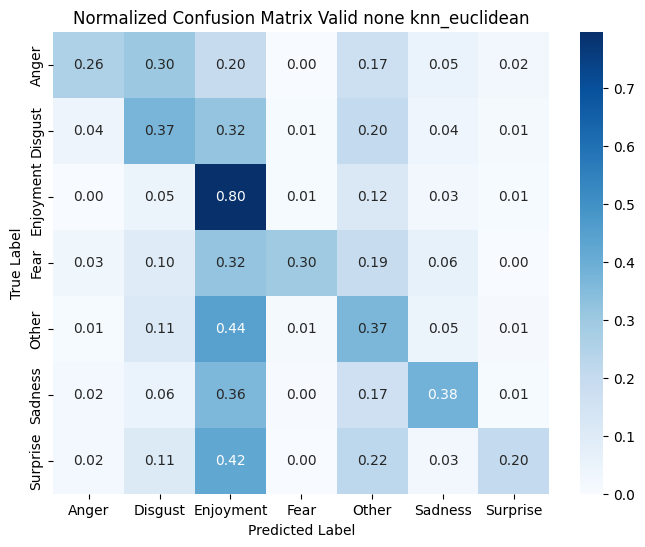

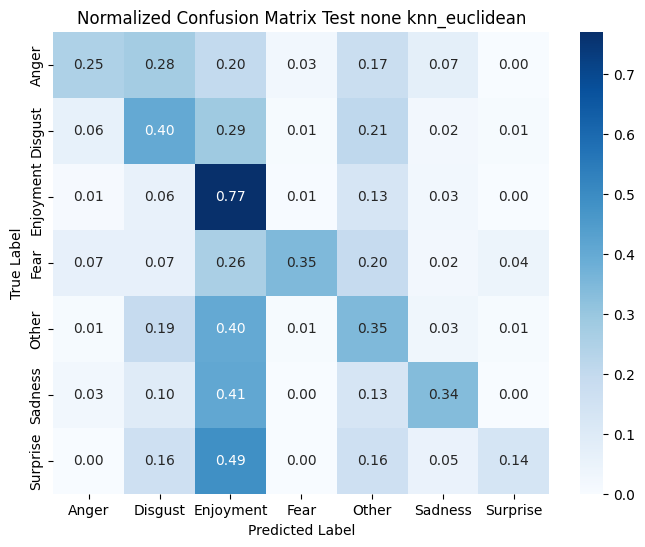

In [45]:
# KNN - euclidean - None
model_82_knn_euclidean, train_82_knn_euclidean, valid_82_knn_euclidean, test_82_knn_euclidean, pred_82_knn_euclidean = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="knn",
    metric="euclidean"
)

y_train_82_knn_euclidean, y_valid_82_knn_euclidean, y_test_82_knn_euclidean = train_82_knn_euclidean[1], valid_82_knn_euclidean[1], test_82_knn_euclidean[1]
y_pred_train_82_knn_euclidean, y_pred_valid_82_knn_euclidean, y_pred_test_82_knn_euclidean = pred_82_knn_euclidean

pipeline_evaluation(
    y_train_82_knn_euclidean, y_valid_82_knn_euclidean, y_test_82_knn_euclidean,
    y_pred_train_82_knn_euclidean, y_pred_valid_82_knn_euclidean, y_pred_test_82_knn_euclidean,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="knn_euclidean",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 8:2 --- knn --- pca ---
Accuracy: 0.49272565320665085
Recall: 0.49272565320665085
Precision: 0.5339075645855657
F1-score: 0.46835506722460774

--- valid --- 8:2 --- knn --- pca ---
Accuracy: 0.4679334916864608
Recall: 0.4679334916864608
Precision: 0.5045134635587122
F1-score: 0.4489583334055265

--- test --- 8:2 --- knn --- pca ---
Accuracy: 0.45930232558139533
Recall: 0.45930232558139533
Precision: 0.5109175664309689
F1-score: 0.4408058997267405


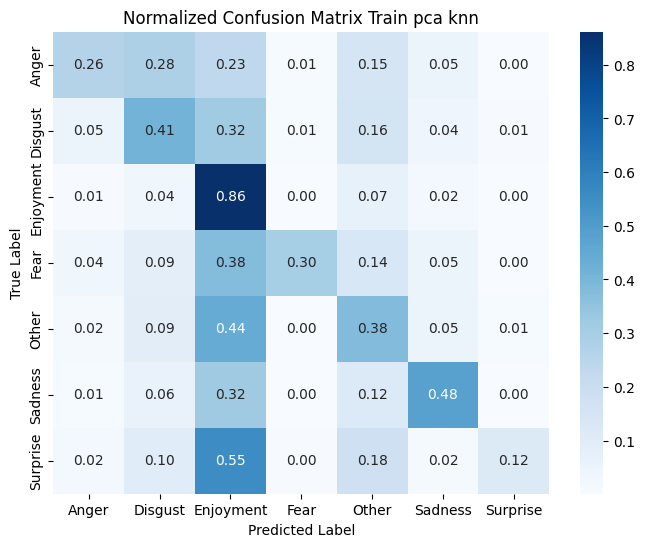

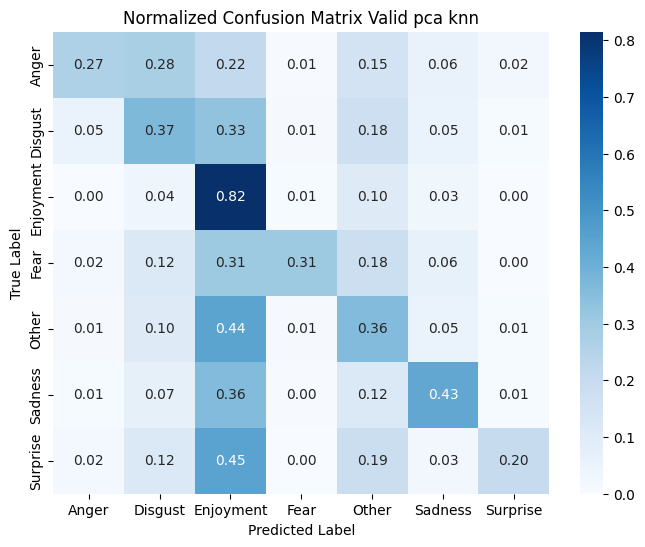

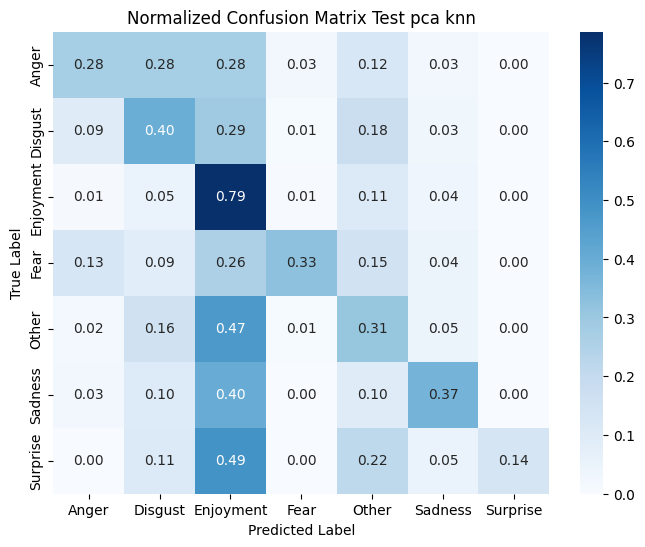

In [46]:
model_pca_82_knn, train_pca_82_knn, valid_pca_82_knn, test_pca_82_knn, pred_pca_82_knn = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="knn",
    max_iter=1000
)

y_train_pca_82_knn, y_valid_pca_82_knn, y_test_pca_82_knn = train_pca_82_knn[1], valid_pca_82_knn[1], test_pca_82_knn[1]
y_pred_train_pca_82_knn, y_pred_valid_pca_82_knn, y_pred_test_pca_82_knn = pred_pca_82_knn

pipeline_evaluation(
    y_train_pca_82_knn, y_valid_pca_82_knn, y_test_pca_82_knn,
    y_pred_train_pca_82_knn, y_pred_valid_pca_82_knn, y_pred_test_pca_82_knn,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

--- train --- 8:2 --- knn_euclidean --- pca ---
Accuracy: 0.4948040380047506
Recall: 0.4948040380047506
Precision: 0.5394911484036082
F1-score: 0.4755458823351743

--- valid --- 8:2 --- knn_euclidean --- pca ---
Accuracy: 0.47090261282660334
Recall: 0.47090261282660334
Precision: 0.5014331950067722
F1-score: 0.45233038232115536

--- test --- 8:2 --- knn_euclidean --- pca ---
Accuracy: 0.45930232558139533
Recall: 0.45930232558139533
Precision: 0.5005384803194052
F1-score: 0.44583146252183325


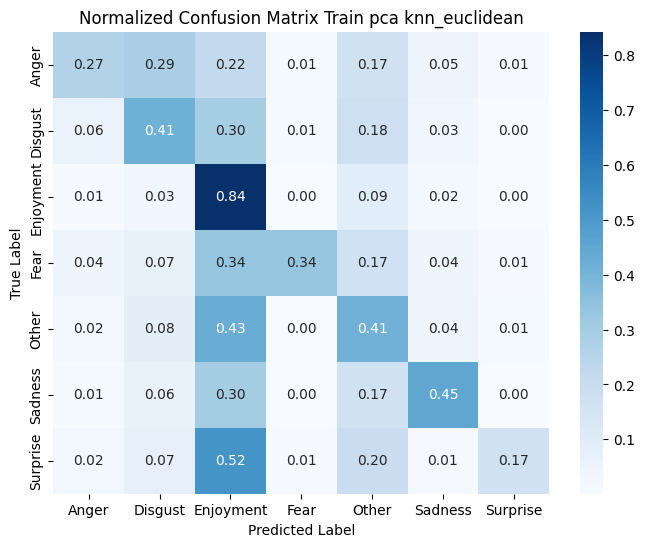

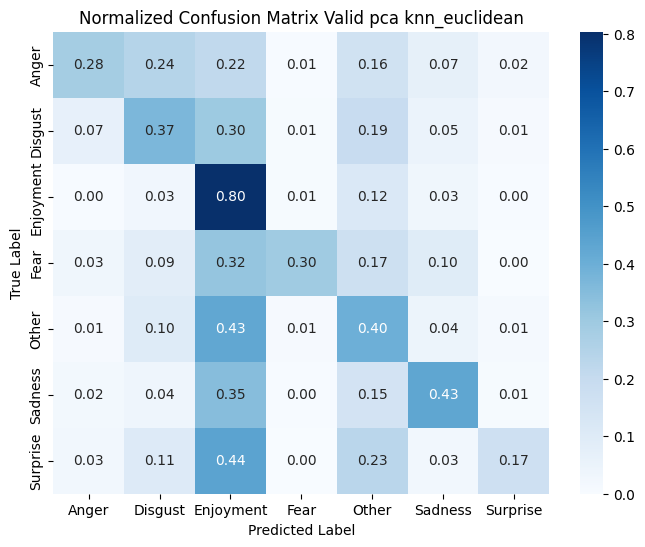

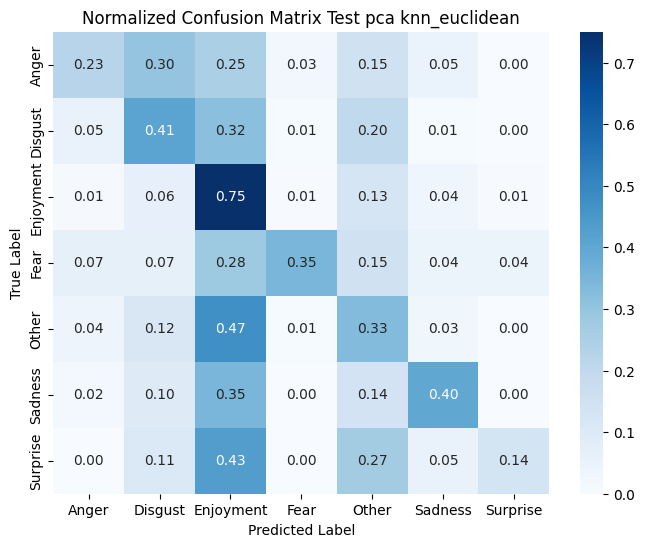

In [47]:
# KNN - euclidean - PCA
model_pca_82_knn_euclidean, train_pca_82_knn_euclidean, valid_pca_82_knn_euclidean, test_pca_82_knn_euclidean, pred_pca_82_knn_euclidean = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="knn",
    metric="euclidean"
)

y_train_pca_82_knn_euclidean, y_valid_pca_82_knn_euclidean, y_test_pca_82_knn_euclidean = train_pca_82_knn_euclidean[1], valid_pca_82_knn_euclidean[1], test_pca_82_knn_euclidean[1]
y_pred_train_pca_82_knn_euclidean, y_pred_valid_pca_82_knn_euclidean, y_pred_test_pca_82_knn_euclidean = pred_pca_82_knn_euclidean

pipeline_evaluation(
    y_train_pca_82_knn_euclidean, y_valid_pca_82_knn_euclidean, y_test_pca_82_knn_euclidean,
    y_pred_train_pca_82_knn_euclidean, y_pred_valid_pca_82_knn_euclidean, y_pred_test_pca_82_knn_euclidean,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="knn_euclidean",
    show_plot=True
)

### Bộ dữ liệu lda

--- train --- 8:2 --- knn_euclidean --- lda ---
Accuracy: 0.9973277909738717
Recall: 0.9973277909738717
Precision: 0.9973408742551796
F1-score: 0.9973318383464077

--- valid --- 8:2 --- knn_euclidean --- lda ---
Accuracy: 0.2589073634204275
Recall: 0.2589073634204275
Precision: 0.284770413607029
F1-score: 0.2631604876550516

--- test --- 8:2 --- knn_euclidean --- lda ---
Accuracy: 0.25
Recall: 0.25
Precision: 0.2918355466350296
F1-score: 0.26078689693846313


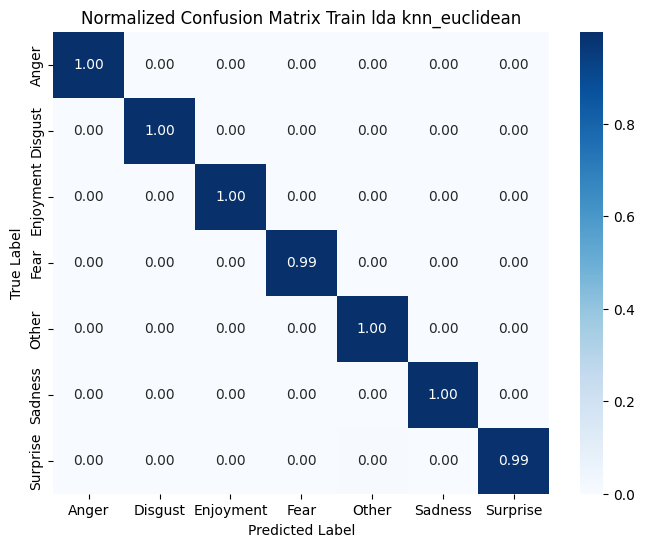

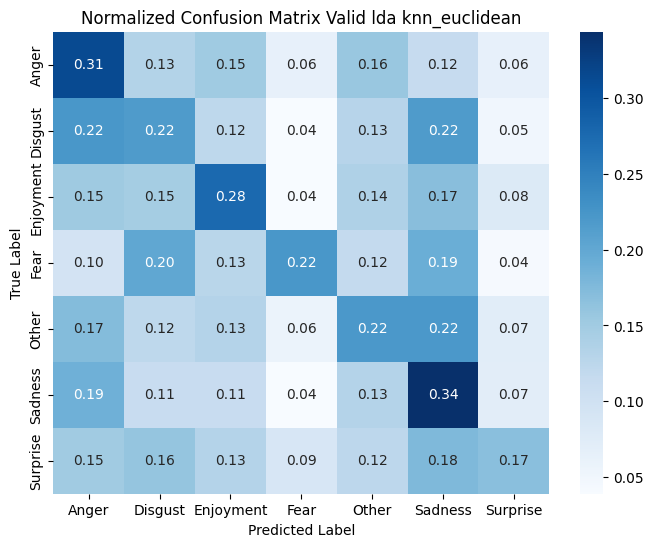

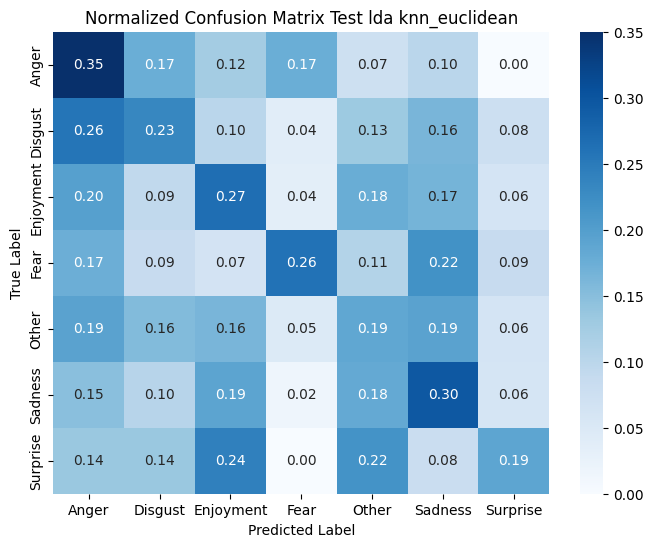

In [48]:
# KNN - euclidean - LDA
model_lda_82_knn_euclidean, train_lda_82_knn_euclidean, valid_lda_82_knn_euclidean, test_lda_82_knn_euclidean, pred_lda_82_knn_euclidean = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="knn",
    metric="euclidean"
)

y_train_lda_82_knn_euclidean, y_valid_lda_82_knn_euclidean, y_test_lda_82_knn_euclidean = train_lda_82_knn_euclidean[1], valid_lda_82_knn_euclidean[1], test_lda_82_knn_euclidean[1]
y_pred_train_lda_82_knn_euclidean, y_pred_valid_lda_82_knn_euclidean, y_pred_test_lda_82_knn_euclidean = pred_lda_82_knn_euclidean

pipeline_evaluation(
    y_train_lda_82_knn_euclidean, y_valid_lda_82_knn_euclidean, y_test_lda_82_knn_euclidean,
    y_pred_train_lda_82_knn_euclidean, y_pred_valid_lda_82_knn_euclidean, y_pred_test_lda_82_knn_euclidean,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 8:2 --- knn --- lda ---
Accuracy: 0.996585510688836
Recall: 0.996585510688836
Precision: 0.9966029905046098
F1-score: 0.9965885551097394

--- valid --- 8:2 --- knn --- lda ---
Accuracy: 0.25593824228028506
Recall: 0.25593824228028506
Precision: 0.27493367000240715
F1-score: 0.2588045088862466

--- test --- 8:2 --- knn --- lda ---
Accuracy: 0.25726744186046513
Recall: 0.25726744186046513
Precision: 0.29072726098786816
F1-score: 0.26703185542899427


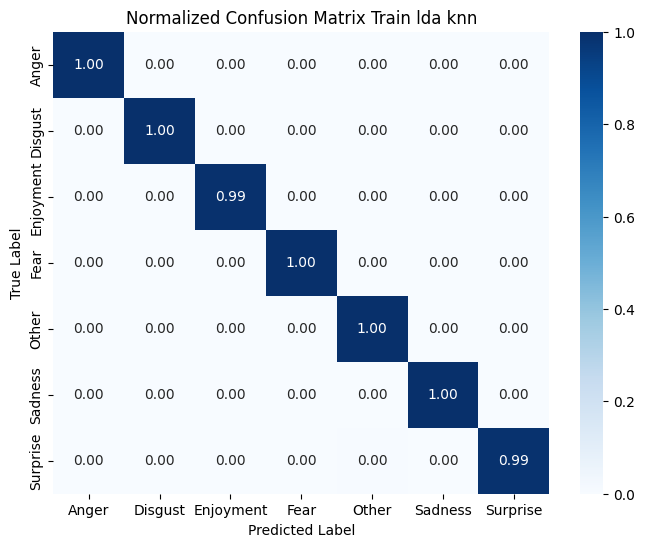

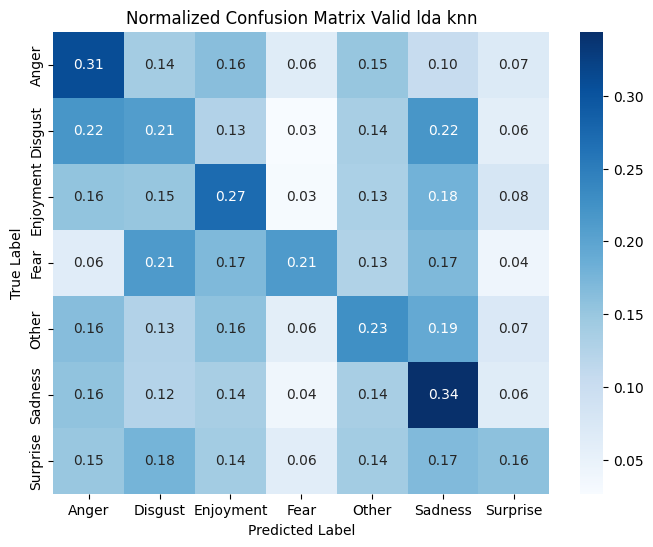

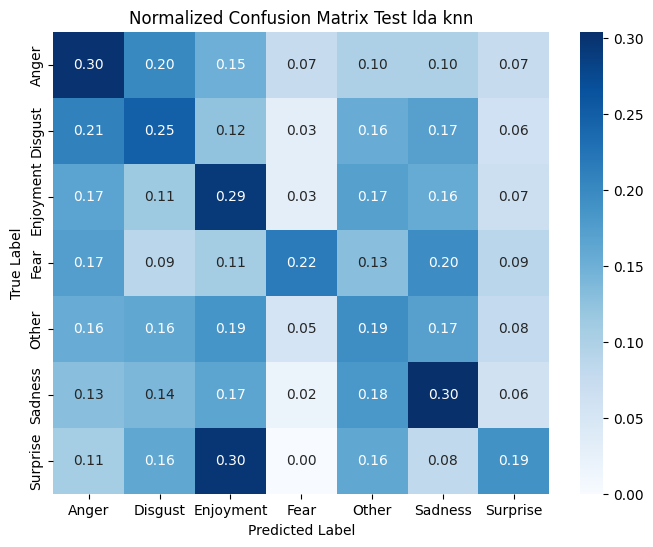

In [49]:
model_lda_82_knn, train_lda_82_knn, valid_lda_82_knn, test_lda_82_knn, pred_lda_82_knn = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="knn",
    max_iter=1000
)

y_train_lda_82_knn, y_valid_lda_82_knn, y_test_lda_82_knn = train_lda_82_knn[1], valid_lda_82_knn[1], test_lda_82_knn[1]
y_pred_train_lda_82_knn, y_pred_valid_lda_82_knn, y_pred_test_lda_82_knn = pred_lda_82_knn

pipeline_evaluation(
    y_train_lda_82_knn, y_valid_lda_82_knn, y_test_lda_82_knn,
    y_pred_train_lda_82_knn, y_pred_valid_lda_82_knn, y_pred_test_lda_82_knn,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

## SVM

### Bộ dữ liệu không giảm chiều

--- train --- 8:2 --- svm_linear --- none ---
Accuracy: 0.936312351543943
Recall: 0.936312351543943
Precision: 0.9373111045341217
F1-score: 0.9362509054421541

--- valid --- 8:2 --- svm_linear --- none ---
Accuracy: 0.5409738717339667
Recall: 0.5409738717339667
Precision: 0.5426792437246862
F1-score: 0.5394220817722981

--- test --- 8:2 --- svm_linear --- none ---
Accuracy: 0.5188953488372093
Recall: 0.5188953488372093
Precision: 0.5307329944702321
F1-score: 0.5217167259268485


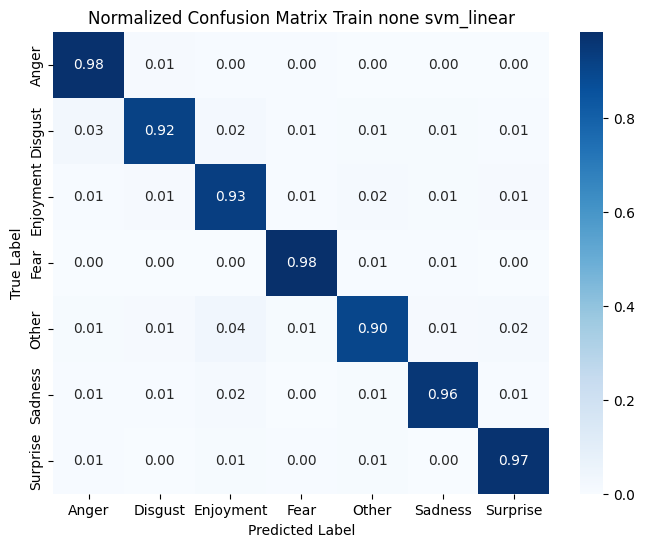

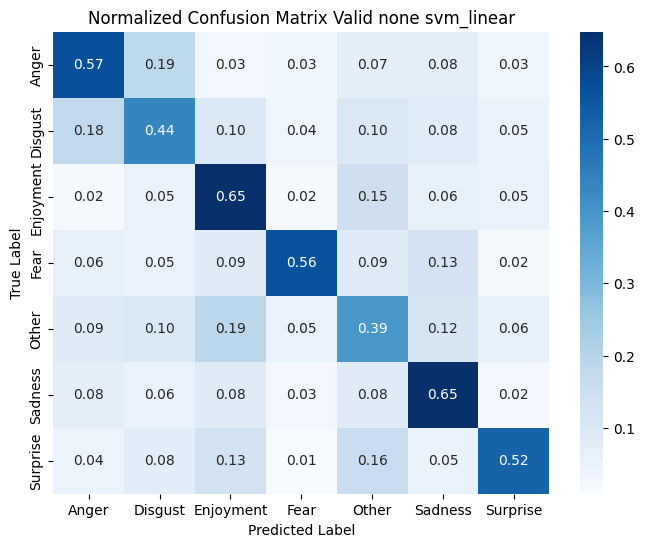

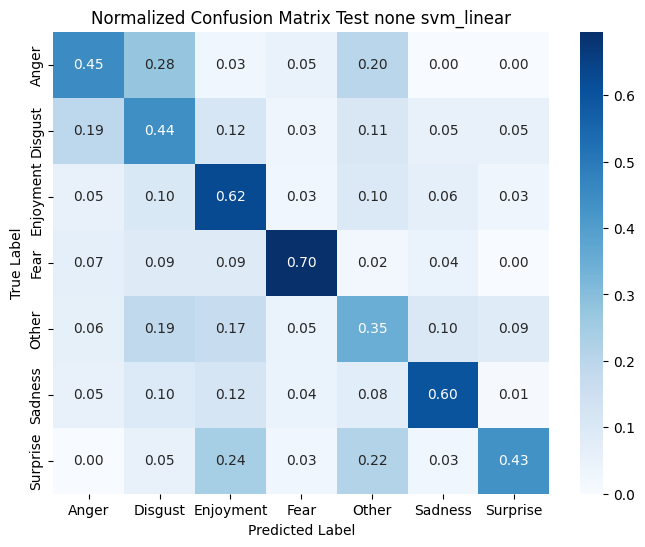

In [50]:
# SVM - linear - None (8:2)
model_82_svm_linear, train_82_svm_linear, valid_82_svm_linear, test_82_svm_linear, pred_82_svm_linear = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_82_svm_linear, y_valid_82_svm_linear, y_test_82_svm_linear = train_82_svm_linear[1], valid_82_svm_linear[1], test_82_svm_linear[1]
y_pred_train_82_svm_linear, y_pred_valid_82_svm_linear, y_pred_test_82_svm_linear = pred_82_svm_linear

pipeline_evaluation(
    y_train_82_svm_linear, y_valid_82_svm_linear, y_test_82_svm_linear,
    y_pred_train_82_svm_linear, y_pred_valid_82_svm_linear, y_pred_test_82_svm_linear,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="svm_linear",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

--- train --- 8:2 --- svm_poly --- none ---
Accuracy: 0.26068883610451304
Recall: 0.26068883610451304
Precision: 0.5685915313884554
F1-score: 0.13526310726592186

--- valid --- 8:2 --- svm_poly --- none ---
Accuracy: 0.18111638954869358
Recall: 0.18111638954869358
Precision: 0.5216643089578078
F1-score: 0.08567860812513582

--- test --- 8:2 --- svm_poly --- none ---
Accuracy: 0.1875
Recall: 0.1875
Precision: 0.43987579573719005
F1-score: 0.07737924253491008


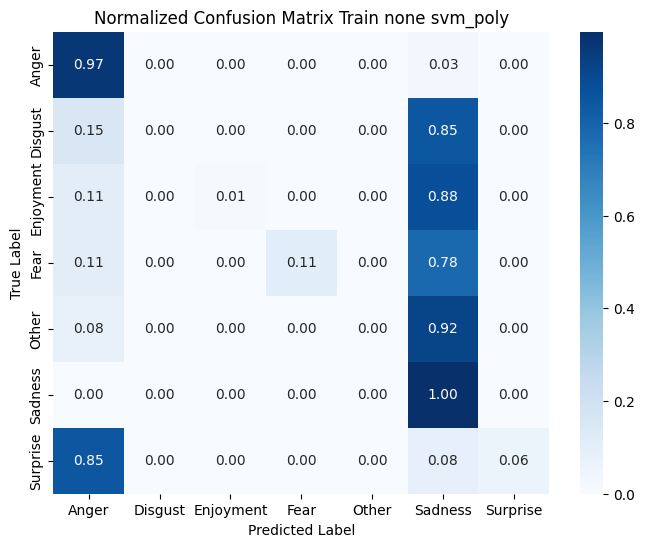

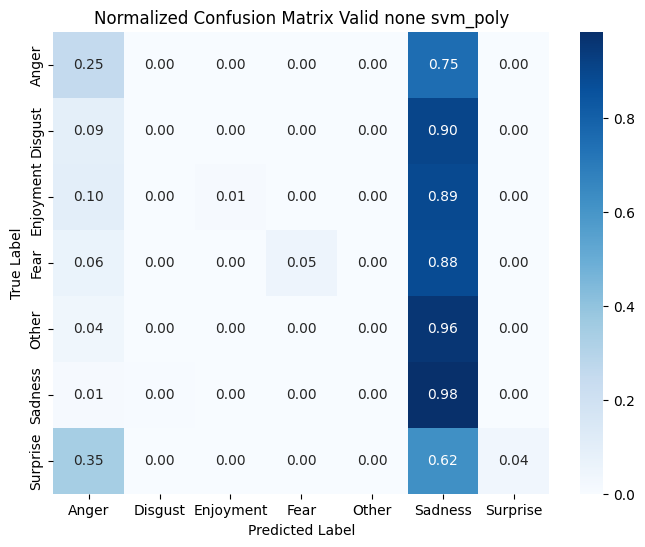

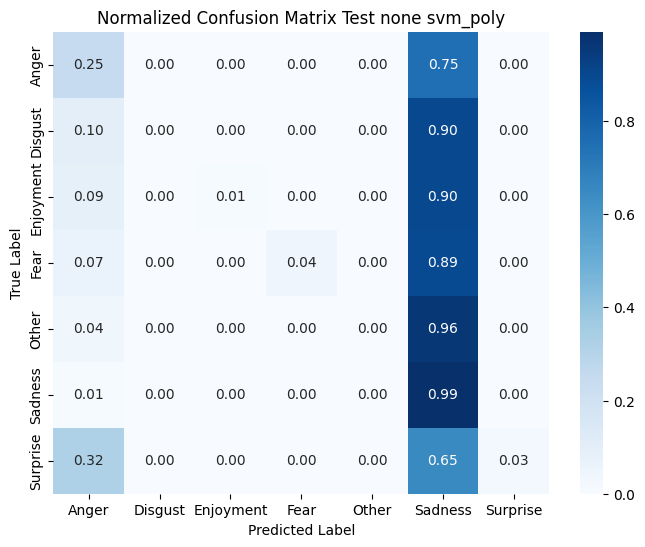

In [51]:
# SVM - poly - None (8:2)
model_82_svm_poly, train_82_svm_poly, valid_82_svm_poly, test_82_svm_poly, pred_82_svm_poly = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_82_svm_poly, y_valid_82_svm_poly, y_test_82_svm_poly = train_82_svm_poly[1], valid_82_svm_poly[1], test_82_svm_poly[1]
y_pred_train_82_svm_poly, y_pred_valid_82_svm_poly, y_pred_test_82_svm_poly = pred_82_svm_poly

pipeline_evaluation(
    y_train_82_svm_poly, y_valid_82_svm_poly, y_test_82_svm_poly,
    y_pred_train_82_svm_poly, y_pred_valid_82_svm_poly, y_pred_test_82_svm_poly,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="svm_poly",
    show_plot=True
)

--- train --- 8:2 --- svm_rbf --- none ---
Accuracy: 0.9590261282660333
Recall: 0.9590261282660333
Precision: 0.9595618018289578
F1-score: 0.9589401942528821

--- valid --- 8:2 --- svm_rbf --- none ---
Accuracy: 0.5391923990498813
Recall: 0.5391923990498813
Precision: 0.5556323304933073
F1-score: 0.5429109519782688

--- test --- 8:2 --- svm_rbf --- none ---
Accuracy: 0.5334302325581395
Recall: 0.5334302325581395
Precision: 0.566588963686538
F1-score: 0.540789102800792


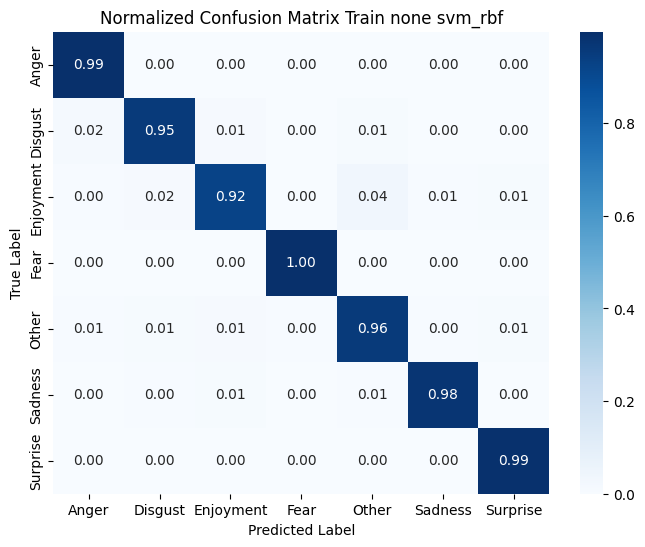

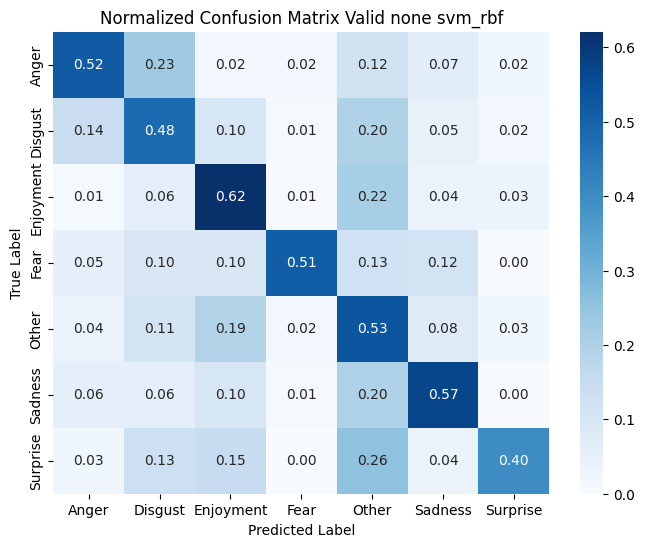

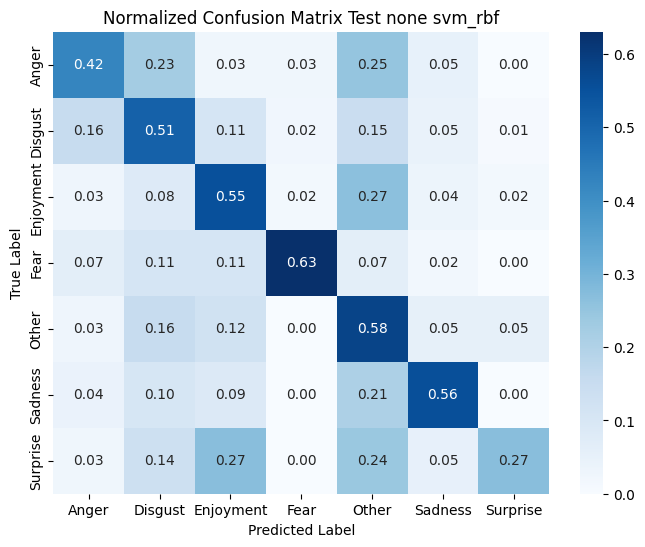

In [52]:
# SVM - rbf - None (8:2)
model_82_svm_rbf, train_82_svm_rbf, valid_82_svm_rbf, test_82_svm_rbf, pred_82_svm_rbf = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_82_svm_rbf, y_valid_82_svm_rbf, y_test_82_svm_rbf = train_82_svm_rbf[1], valid_82_svm_rbf[1], test_82_svm_rbf[1]
y_pred_train_82_svm_rbf, y_pred_valid_82_svm_rbf, y_pred_test_82_svm_rbf = pred_82_svm_rbf

pipeline_evaluation(
    y_train_82_svm_rbf, y_valid_82_svm_rbf, y_test_82_svm_rbf,
    y_pred_train_82_svm_rbf, y_pred_valid_82_svm_rbf, y_pred_test_82_svm_rbf,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="svm_rbf",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 8:2 --- svm_linear --- pca ---
Accuracy: 0.8666864608076009
Recall: 0.8666864608076009
Precision: 0.8692087793713501
F1-score: 0.866283482525036

--- valid --- 8:2 --- svm_linear --- pca ---
Accuracy: 0.5326603325415677
Recall: 0.5326603325415677
Precision: 0.5329778863709629
F1-score: 0.5301231698548344

--- test --- 8:2 --- svm_linear --- pca ---
Accuracy: 0.5188953488372093
Recall: 0.5188953488372093
Precision: 0.5324718993701583
F1-score: 0.5219252698427301


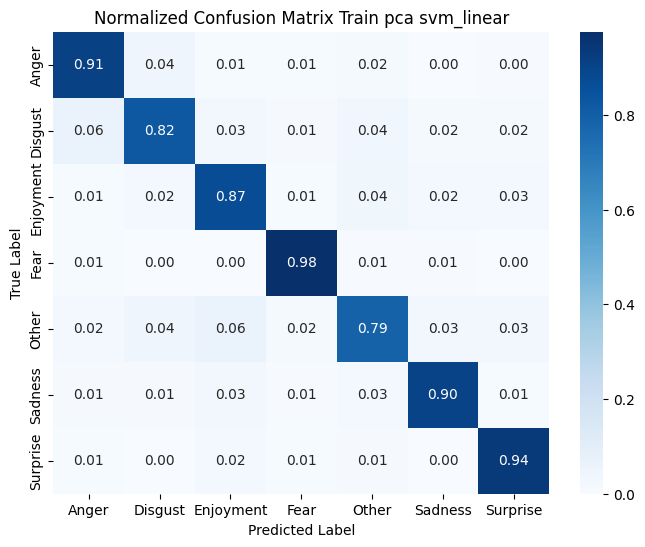

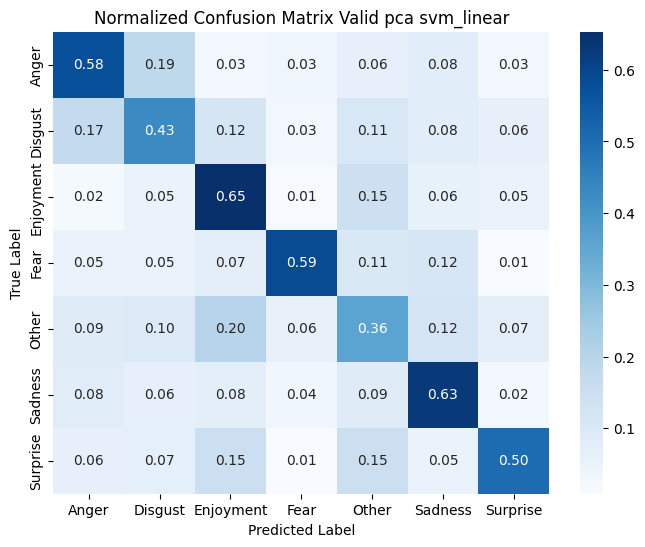

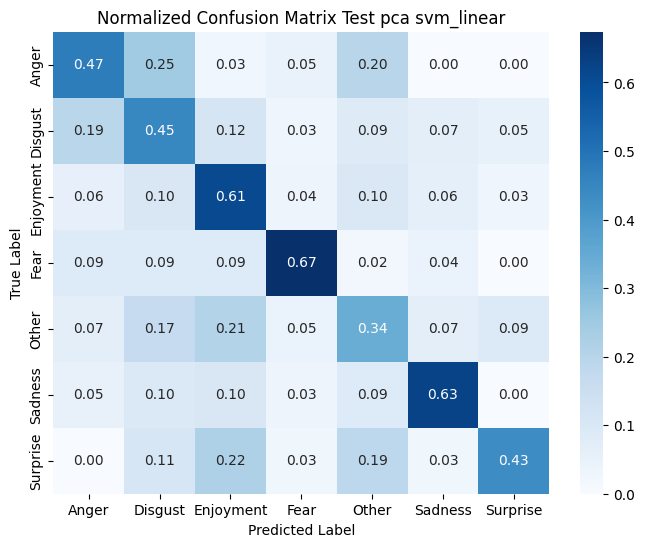

In [53]:
# SVM - linear - PCA (8:2)
model_pca_82_svm_linear, train_pca_82_svm_linear, valid_pca_82_svm_linear, test_pca_82_svm_linear, pred_pca_82_svm_linear = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_pca_82_svm_linear, y_valid_pca_82_svm_linear, y_test_pca_82_svm_linear = train_pca_82_svm_linear[1], valid_pca_82_svm_linear[1], test_pca_82_svm_linear[1]
y_pred_train_pca_82_svm_linear, y_pred_valid_pca_82_svm_linear, y_pred_test_pca_82_svm_linear = pred_pca_82_svm_linear

pipeline_evaluation(
    y_train_pca_82_svm_linear, y_valid_pca_82_svm_linear, y_test_pca_82_svm_linear,
    y_pred_train_pca_82_svm_linear, y_pred_valid_pca_82_svm_linear, y_pred_test_pca_82_svm_linear,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="svm_linear",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- train --- 8:2 --- svm_poly --- pca ---
Accuracy: 0.26588479809976245
Recall: 0.26588479809976245
Precision: 0.6982114760399788
F1-score: 0.19360502166318055

--- valid --- 8:2 --- svm_poly --- pca ---
Accuracy: 0.19418052256532067
Recall: 0.19418052256532067
Precision: 0.5260522129919594
F1-score: 0.13634245474369058

--- test --- 8:2 --- svm_poly --- pca ---
Accuracy: 0.13517441860465115
Recall: 0.13517441860465115
Precision: 0.6837362282606353
F1-score: 0.10482998090440163


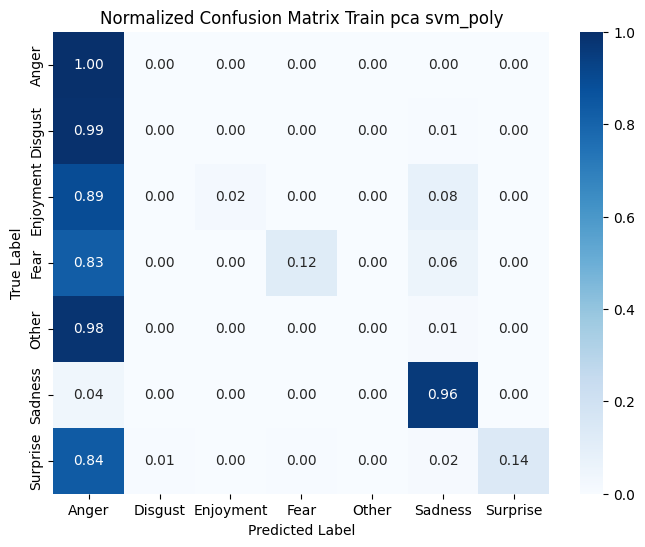

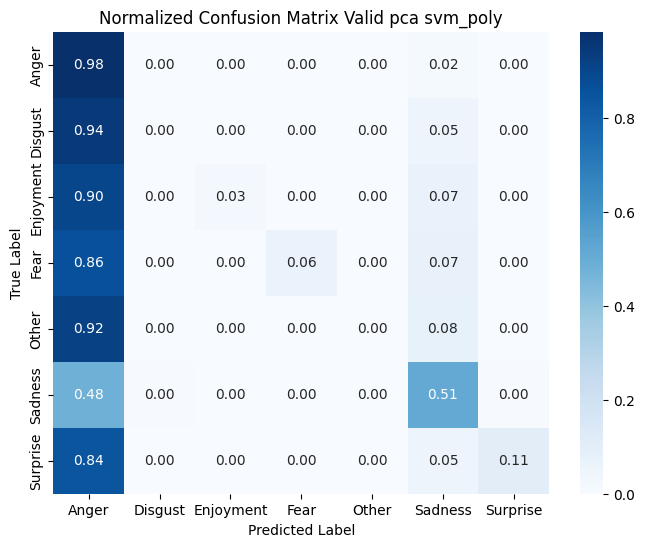

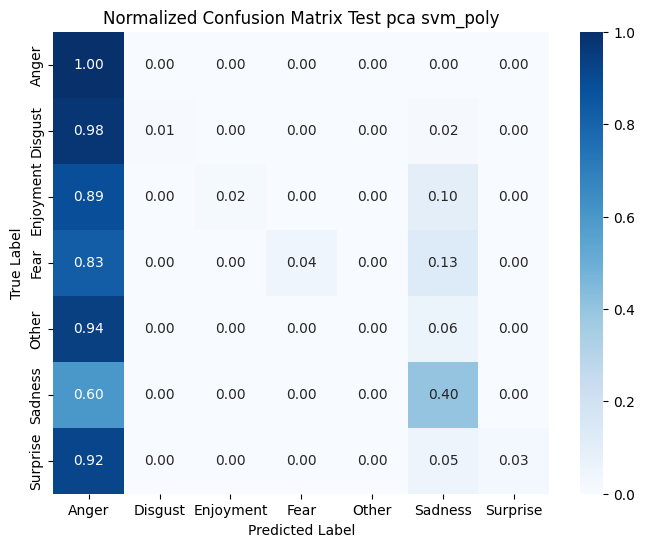

In [54]:
# SVM - poly - PCA (8:2)
model_pca_82_svm_poly, train_pca_82_svm_poly, valid_pca_82_svm_poly, test_pca_82_svm_poly, pred_pca_82_svm_poly = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_pca_82_svm_poly, y_valid_pca_82_svm_poly, y_test_pca_82_svm_poly = train_pca_82_svm_poly[1], valid_pca_82_svm_poly[1], test_pca_82_svm_poly[1]
y_pred_train_pca_82_svm_poly, y_pred_valid_pca_82_svm_poly, y_pred_test_pca_82_svm_poly = pred_pca_82_svm_poly

pipeline_evaluation(
    y_train_pca_82_svm_poly, y_valid_pca_82_svm_poly, y_test_pca_82_svm_poly,
    y_pred_train_pca_82_svm_poly, y_pred_valid_pca_82_svm_poly, y_pred_test_pca_82_svm_poly,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="svm_poly",
    show_plot=True
)

--- train --- 8:2 --- svm_rbf --- pca ---
Accuracy: 0.9314133016627079
Recall: 0.9314133016627079
Precision: 0.932434065098468
F1-score: 0.9312077928789574

--- valid --- 8:2 --- svm_rbf --- pca ---
Accuracy: 0.5285035629453682
Recall: 0.5285035629453682
Precision: 0.5426089609546084
F1-score: 0.532547950821155

--- test --- 8:2 --- svm_rbf --- pca ---
Accuracy: 0.5145348837209303
Recall: 0.5145348837209303
Precision: 0.5603376418688374
F1-score: 0.526649038181586


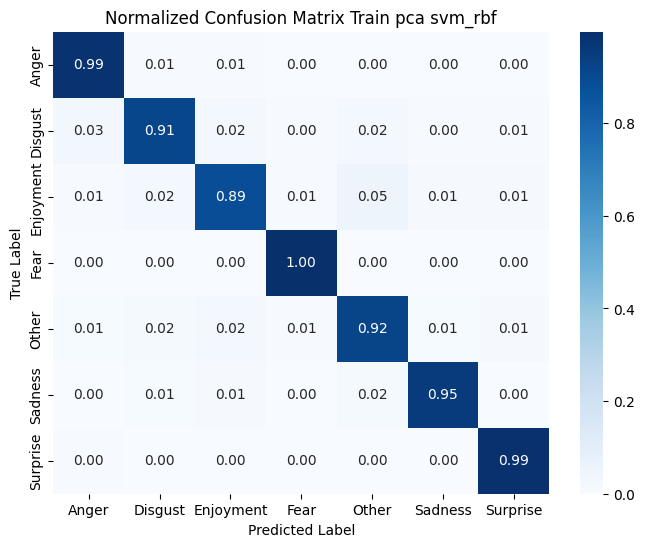

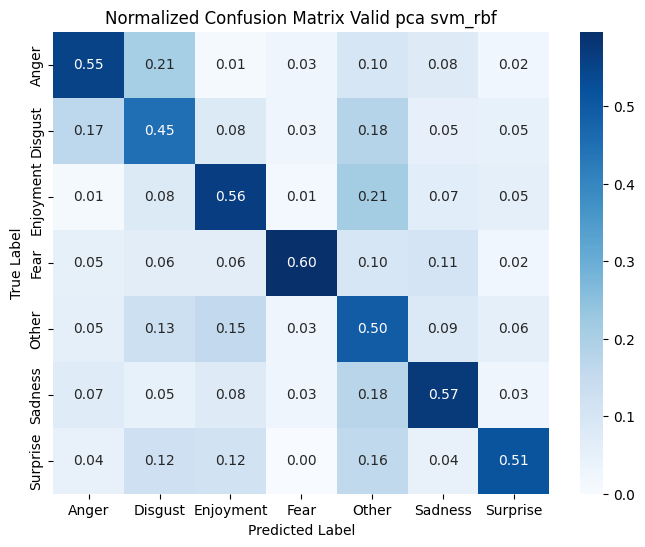

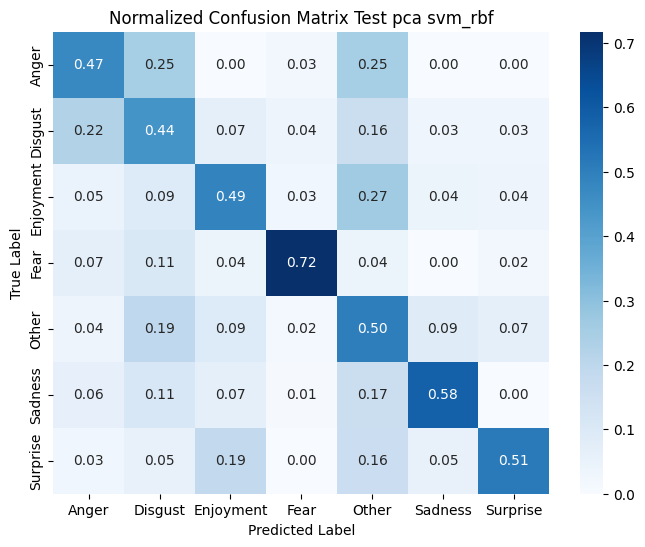

In [55]:
# SVM - rbf - PCA (8:2)
model_pca_82_svm_rbf, train_pca_82_svm_rbf, valid_pca_82_svm_rbf, test_pca_82_svm_rbf, pred_pca_82_svm_rbf = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_pca_82_svm_rbf, y_valid_pca_82_svm_rbf, y_test_pca_82_svm_rbf = train_pca_82_svm_rbf[1], valid_pca_82_svm_rbf[1], test_pca_82_svm_rbf[1]
y_pred_train_pca_82_svm_rbf, y_pred_valid_pca_82_svm_rbf, y_pred_test_pca_82_svm_rbf = pred_pca_82_svm_rbf

pipeline_evaluation(
    y_train_pca_82_svm_rbf, y_valid_pca_82_svm_rbf, y_test_pca_82_svm_rbf,
    y_pred_train_pca_82_svm_rbf, y_pred_valid_pca_82_svm_rbf, y_pred_test_pca_82_svm_rbf,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="svm_rbf",
    show_plot=True
)

### Bộ dữ liệu LDA

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--- train --- 8:2 --- svm_linear --- lda ---
Accuracy: 0.9971793349168646
Recall: 0.9971793349168646
Precision: 0.9972025540608762
F1-score: 0.9971847035303656

--- valid --- 8:2 --- svm_linear --- lda ---
Accuracy: 0.2666270783847981
Recall: 0.2666270783847981
Precision: 0.2796736013102439
F1-score: 0.26674815386260015

--- test --- 8:2 --- svm_linear --- lda ---
Accuracy: 0.2747093023255814
Recall: 0.2747093023255814
Precision: 0.312224370206493
F1-score: 0.2790565431728589


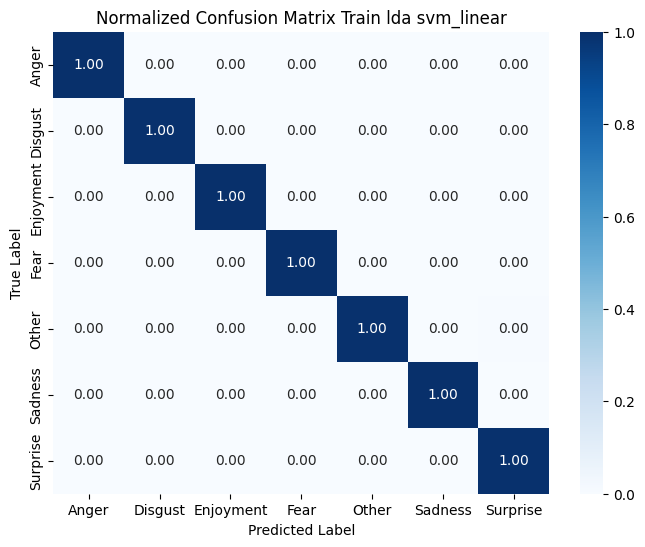

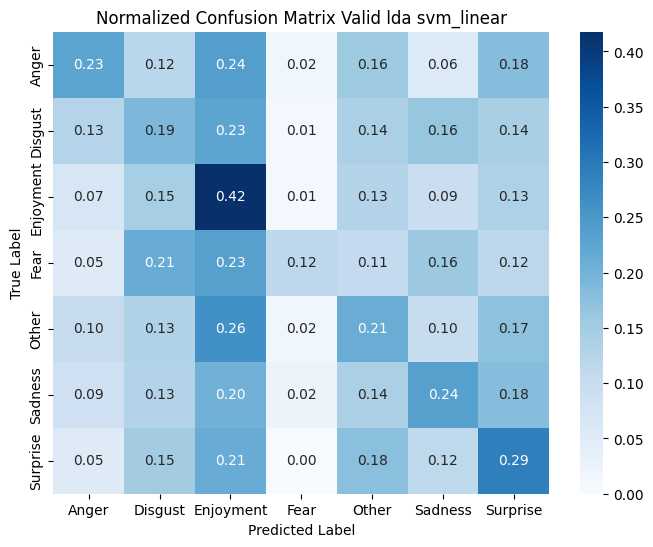

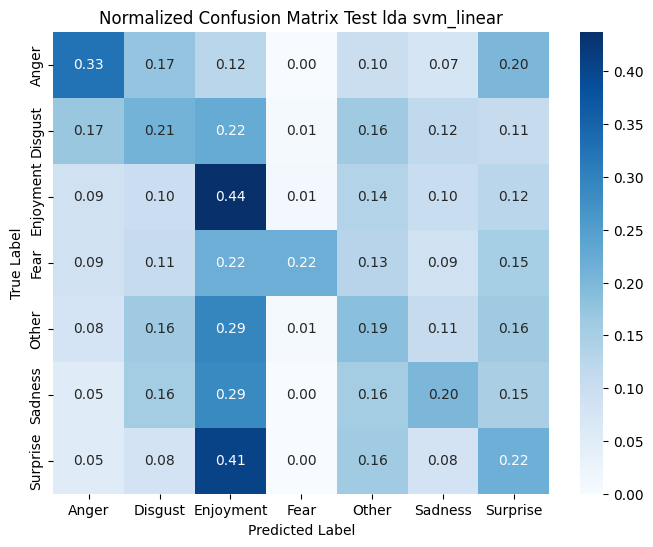

In [56]:
# SVM - linear - LDA (8:2)
model_lda_82_svm_linear, train_lda_82_svm_linear, valid_lda_82_svm_linear, test_lda_82_svm_linear, pred_lda_82_svm_linear = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_lda_82_svm_linear, y_valid_lda_82_svm_linear, y_test_lda_82_svm_linear = train_lda_82_svm_linear[1], valid_lda_82_svm_linear[1], test_lda_82_svm_linear[1]
y_pred_train_lda_82_svm_linear, y_pred_valid_lda_82_svm_linear, y_pred_test_lda_82_svm_linear = pred_lda_82_svm_linear

pipeline_evaluation(
    y_train_lda_82_svm_linear, y_valid_lda_82_svm_linear, y_test_lda_82_svm_linear,
    y_pred_train_lda_82_svm_linear, y_pred_valid_lda_82_svm_linear, y_pred_test_lda_82_svm_linear,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="svm_linear",
    show_plot=True
)

--- train --- 8:2 --- svm_poly --- lda ---
Accuracy: 0.9959916864608076
Recall: 0.9959916864608076
Precision: 0.9960375744148813
F1-score: 0.9960003044631061

--- valid --- 8:2 --- svm_poly --- lda ---
Accuracy: 0.2007125890736342
Recall: 0.2007125890736342
Precision: 0.25276114107583075
F1-score: 0.1989714770850913

--- test --- 8:2 --- svm_poly --- lda ---
Accuracy: 0.17877906976744187
Recall: 0.17877906976744187
Precision: 0.24392711362486194
F1-score: 0.18242937566953515


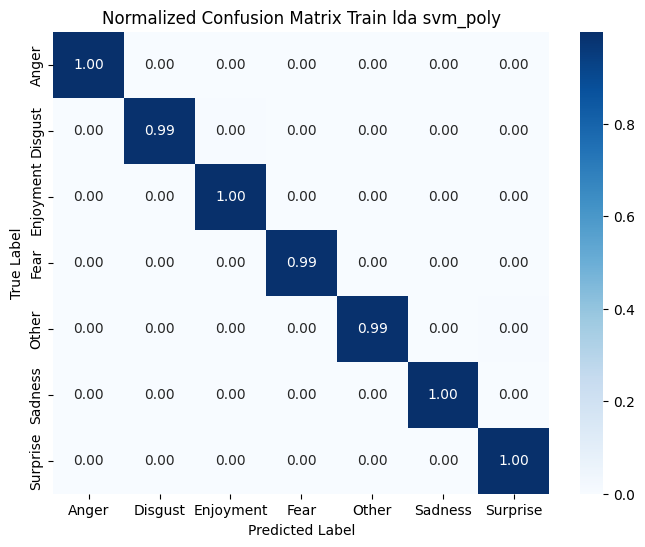

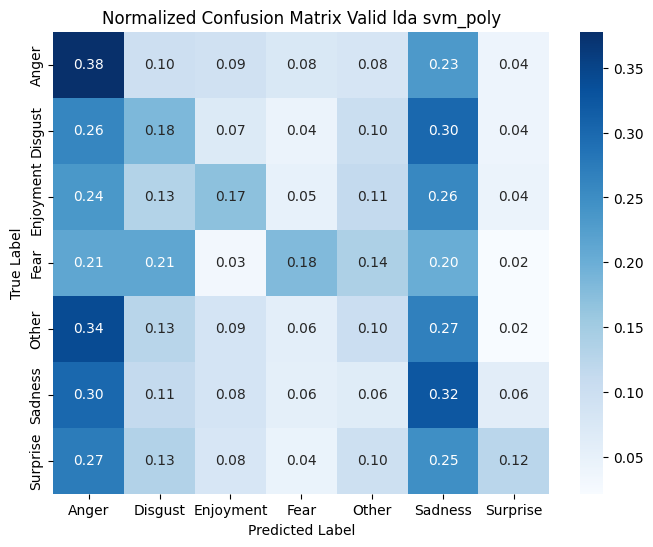

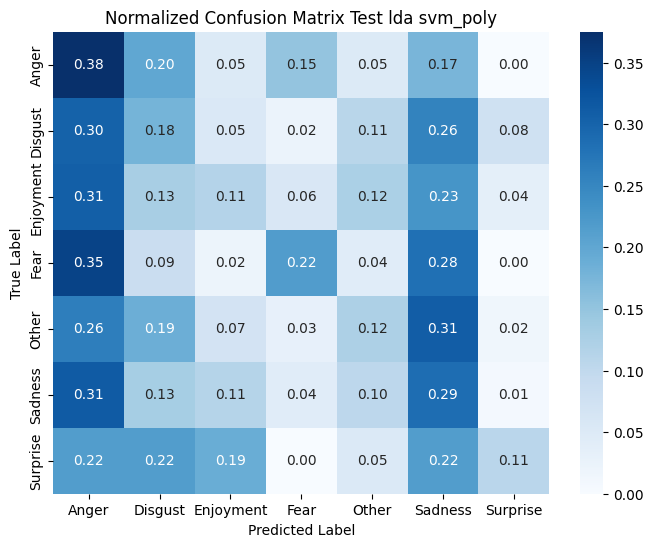

In [57]:
# SVM - poly - LDA (8:2)
model_lda_82_svm_poly, train_lda_82_svm_poly, valid_lda_82_svm_poly, test_lda_82_svm_poly, pred_lda_82_svm_poly = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_lda_82_svm_poly, y_valid_lda_82_svm_poly, y_test_lda_82_svm_poly = train_lda_82_svm_poly[1], valid_lda_82_svm_poly[1], test_lda_82_svm_poly[1]
y_pred_train_lda_82_svm_poly, y_pred_valid_lda_82_svm_poly, y_pred_test_lda_82_svm_poly = pred_lda_82_svm_poly

pipeline_evaluation(
    y_train_lda_82_svm_poly, y_valid_lda_82_svm_poly, y_test_lda_82_svm_poly,
    y_pred_train_lda_82_svm_poly, y_pred_valid_lda_82_svm_poly, y_pred_test_lda_82_svm_poly,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="svm_poly",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- train --- 8:2 --- svm_rbf --- lda ---
Accuracy: 0.994061757719715
Recall: 0.994061757719715
Precision: 0.9941486004170363
F1-score: 0.9940558213025643

--- valid --- 8:2 --- svm_rbf --- lda ---
Accuracy: 0.26247030878859856
Recall: 0.26247030878859856
Precision: 0.18322196019565282
F1-score: 0.11356859568328694

--- test --- 8:2 --- svm_rbf --- lda ---
Accuracy: 0.2805232558139535
Recall: 0.2805232558139535
Precision: 0.24525815309512508
F1-score: 0.12493520896621138


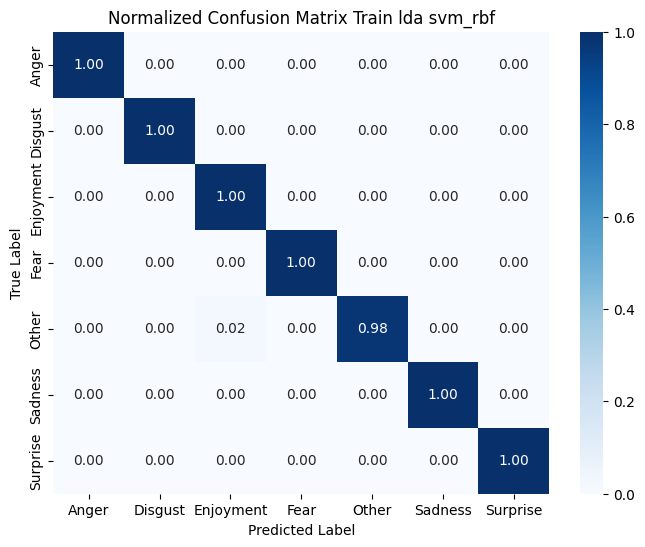

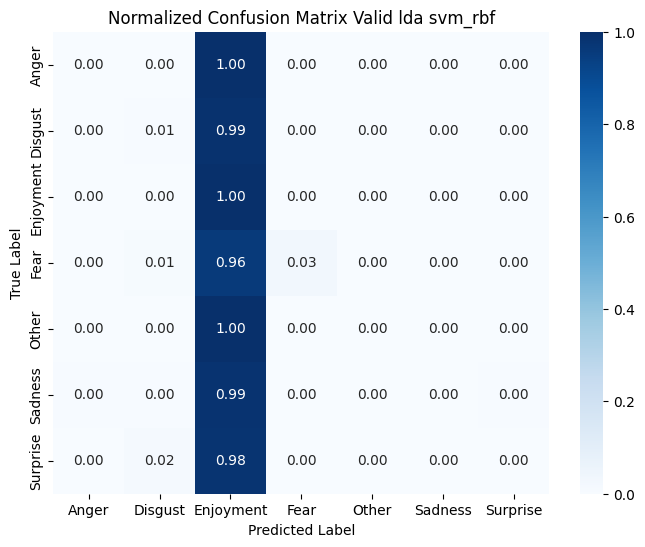

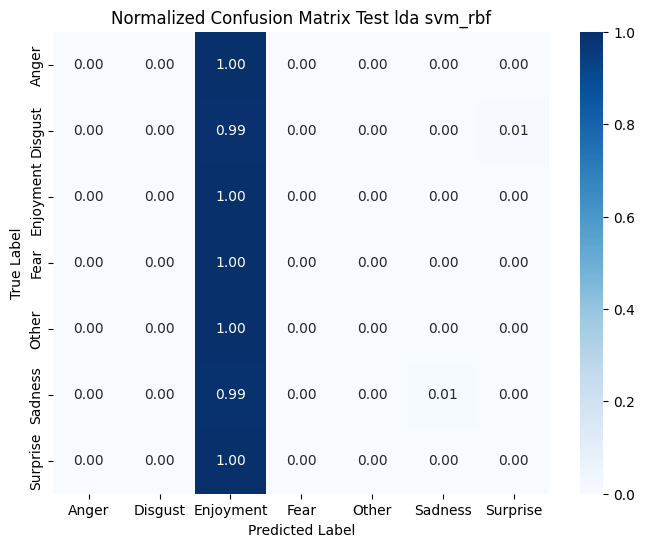

In [58]:
# SVM - rbf - LDA (8:2)
model_lda_82_svm_rbf, train_lda_82_svm_rbf, valid_lda_82_svm_rbf, test_lda_82_svm_rbf, pred_lda_82_svm_rbf = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_lda_82_svm_rbf, y_valid_lda_82_svm_rbf, y_test_lda_82_svm_rbf = train_lda_82_svm_rbf[1], valid_lda_82_svm_rbf[1], test_lda_82_svm_rbf[1]
y_pred_train_lda_82_svm_rbf, y_pred_valid_lda_82_svm_rbf, y_pred_test_lda_82_svm_rbf = pred_lda_82_svm_rbf

pipeline_evaluation(
    y_train_lda_82_svm_rbf, y_valid_lda_82_svm_rbf, y_test_lda_82_svm_rbf,
    y_pred_train_lda_82_svm_rbf, y_pred_valid_lda_82_svm_rbf, y_pred_test_lda_82_svm_rbf,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="svm_rbf",
    show_plot=True
)

# Train:Validation = 7:3

## Logistic Regression

### Bộ dữ liệu không giảm chiều

In [50]:
X_train_73, X_valid_73, X_test_73, y_train_73, y_valid_73, y_test_73, tfidf_vec_73, disc_model_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="none"
)

TF-IDF hoàn thành!
Shape: (5894, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 79104


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.8204954190702409
Recall: 0.8204954190702409
Precision: 0.8269283716103073
F1-score: 0.8197807877069411

--- valid --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.5110847189231987
Recall: 0.5110847189231987
Precision: 0.5194823968708185
F1-score: 0.5124690519362813

--- test --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.5232558139534884
Recall: 0.5232558139534884
Precision: 0.5458329333012102
F1-score: 0.5294082060382446


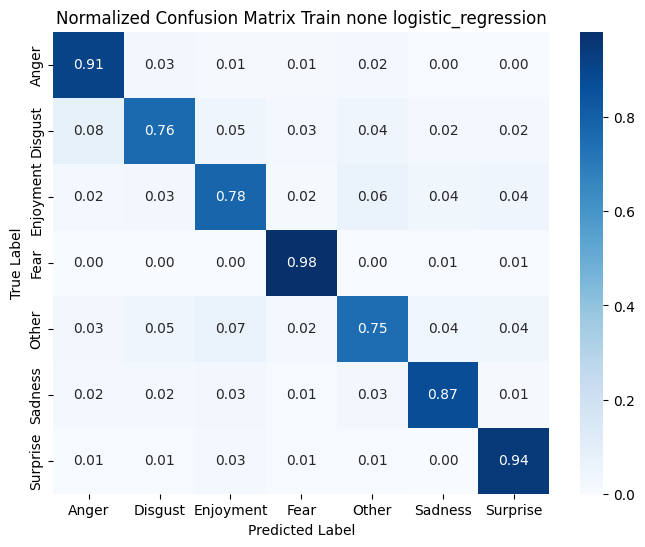

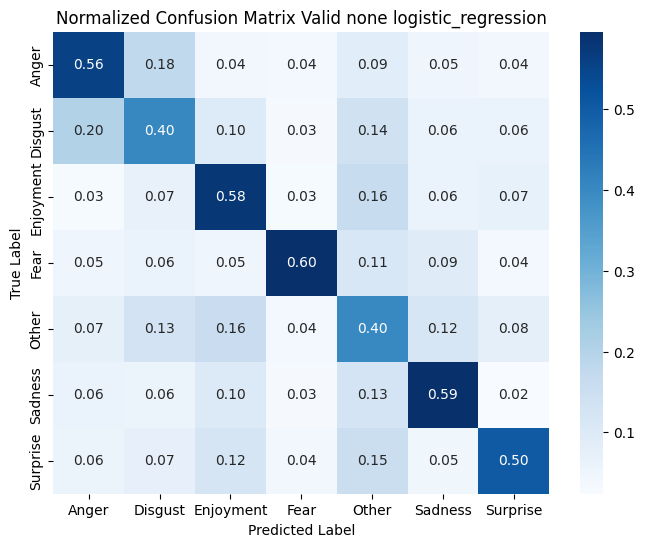

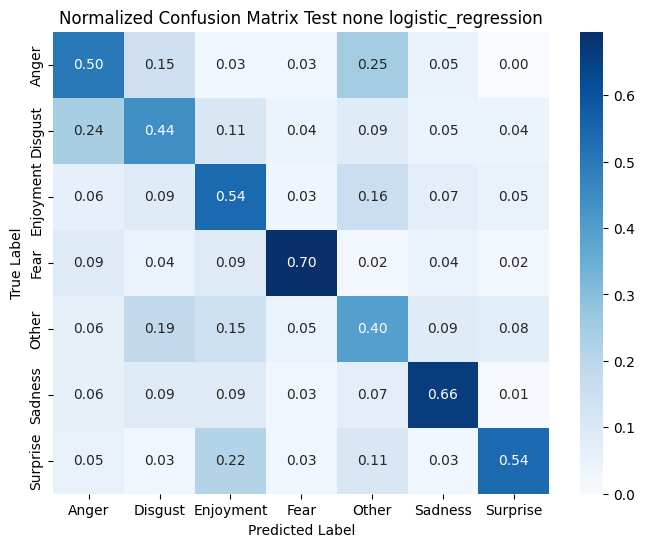

In [51]:
model_73, train_73, valid_73, test_73, pred_73 = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_73, y_pred_valid_73, y_pred_test_73 = pred_73

pipeline_evaluation(
    y_train_73, y_valid_73, y_test_73,
    y_pred_train_73, y_pred_valid_73, y_pred_test_73,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (5894, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 79104


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.7807940278249067
Recall: 0.7807940278249067
Precision: 0.7896157215227453
F1-score: 0.7802385126751615

--- valid --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.5102929532858274
Recall: 0.5102929532858274
Precision: 0.5205447850119698
F1-score: 0.5113441522302679

--- test --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.5145348837209303
Recall: 0.5145348837209303
Precision: 0.5375542182070485
F1-score: 0.5202603898015166


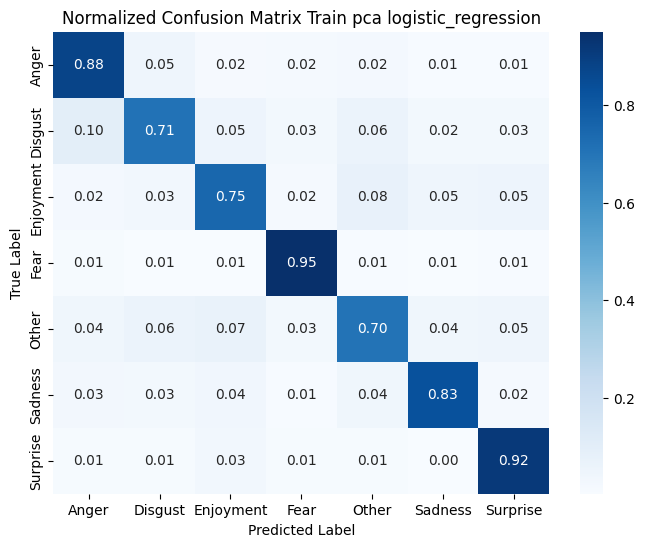

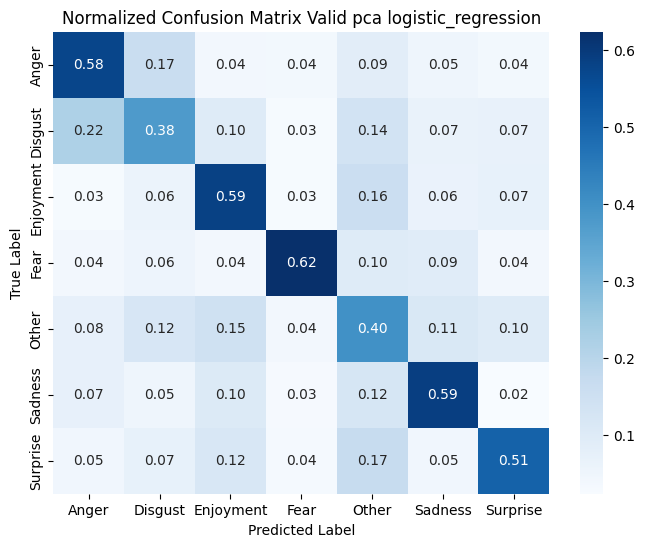

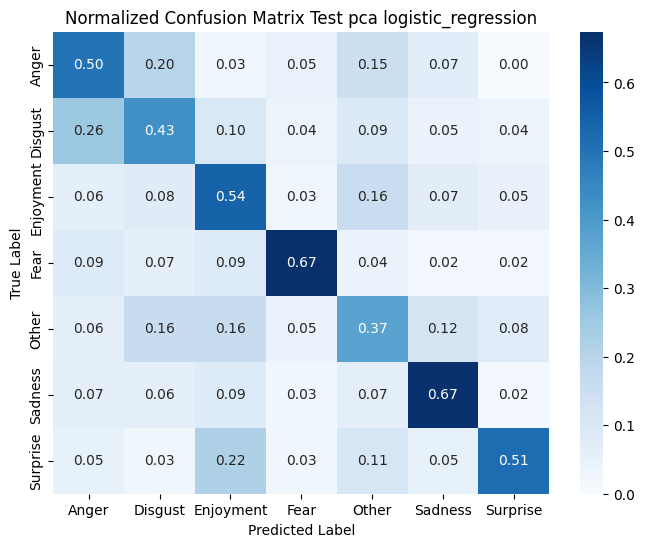

In [52]:
X_train_pca_73, X_valid_pca_73, X_test_pca_73, y_train_pca_73, y_valid_pca_73, y_test_pca_73, tfidf_vec_pca_73, disc_model_pca_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="pca"
)

model_pca_73, train_pca_73, valid_pca_73, test_pca_73, pred_pca_73 = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_pca_73, y_pred_valid_pca_73, y_pred_test_pca_73 = pred_pca_73

pipeline_evaluation(
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    y_pred_train_pca_73, y_pred_valid_pca_73, y_pred_test_pca_73,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (5894, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 79104


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.997964031218188
Recall: 0.997964031218188
Precision: 0.9979840531860752
F1-score: 0.9979684156479353

--- valid --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.26405384006334126
Recall: 0.26405384006334126
Precision: 0.2920871527616756
F1-score: 0.26832465487256657

--- test --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.26598837209302323
Recall: 0.26598837209302323
Precision: 0.29888108988812245
F1-score: 0.27034172304153226


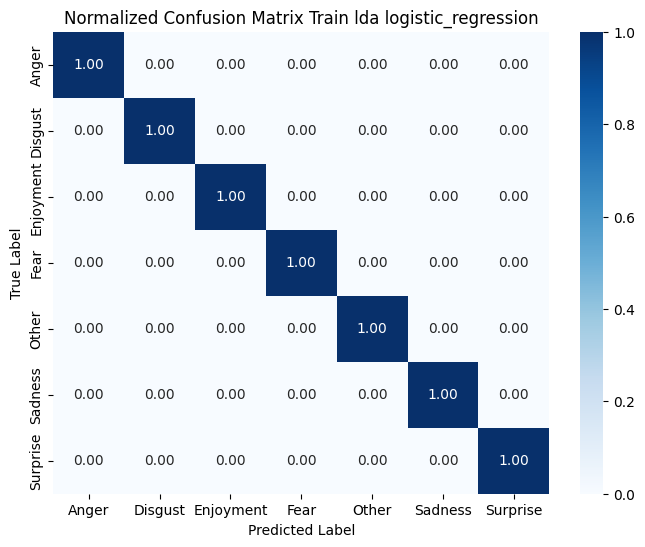

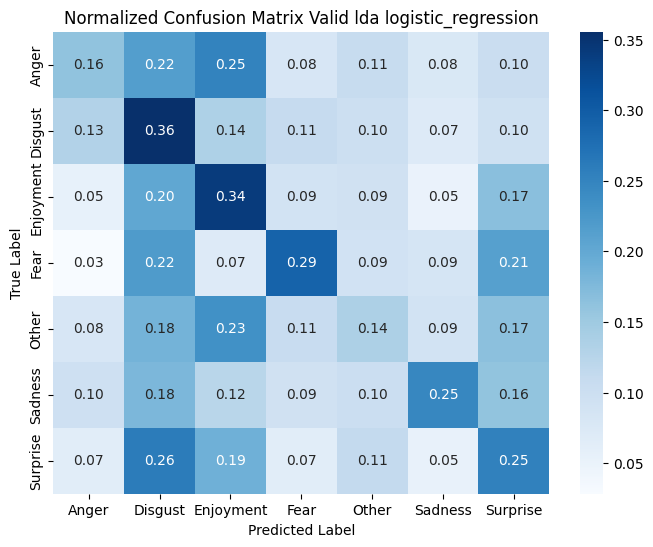

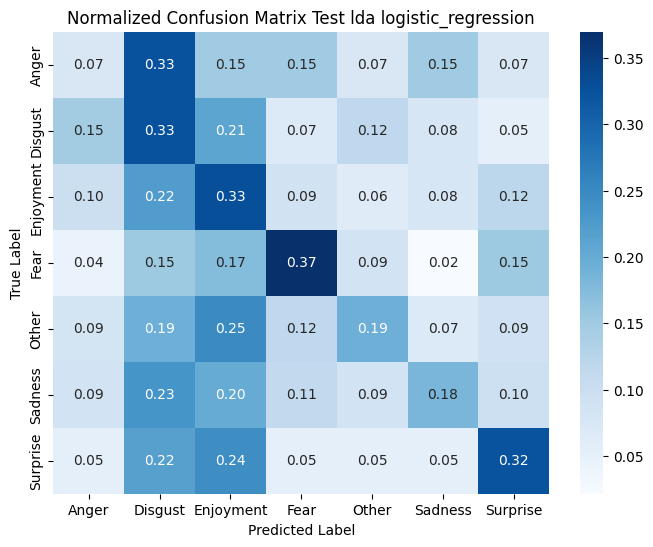

In [53]:
X_train_lda_73, X_valid_lda_73, X_test_lda_73, y_train_lda_73, y_valid_lda_73, y_test_lda_73, tfidf_vec_lda_73, disc_model_lda_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="lda"
)

model_lda_73, train_lda_73, valid_lda_73, test_lda_73, pred_lda_73 = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_lda_73, y_pred_valid_lda_73, y_pred_test_lda_73 = pred_lda_73

pipeline_evaluation(
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    y_pred_train_lda_73, y_pred_valid_lda_73, y_pred_test_lda_73,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

--- train --- 7:3 --- knn_euclidean --- none ---
Accuracy: 0.4874448591788259
Recall: 0.4874448591788259
Precision: 0.5371568853915919
F1-score: 0.46534382912315175

--- valid --- 7:3 --- knn_euclidean --- none ---
Accuracy: 0.43903404592240697
Recall: 0.43903404592240697
Precision: 0.48262500778577316
F1-score: 0.41594227834434255

--- test --- 7:3 --- knn_euclidean --- none ---
Accuracy: 0.44040697674418605
Recall: 0.44040697674418605
Precision: 0.48004772863583023
F1-score: 0.42311581034895007


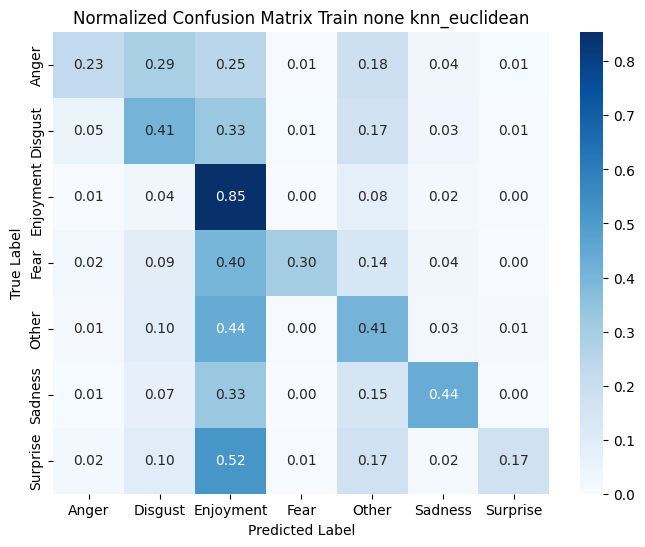

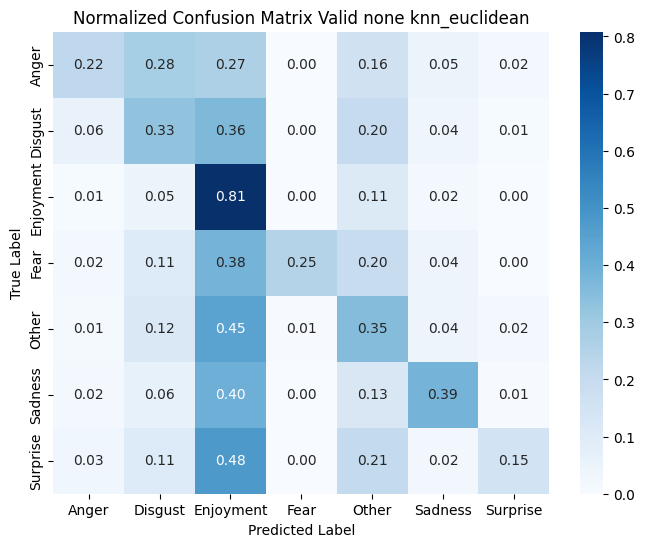

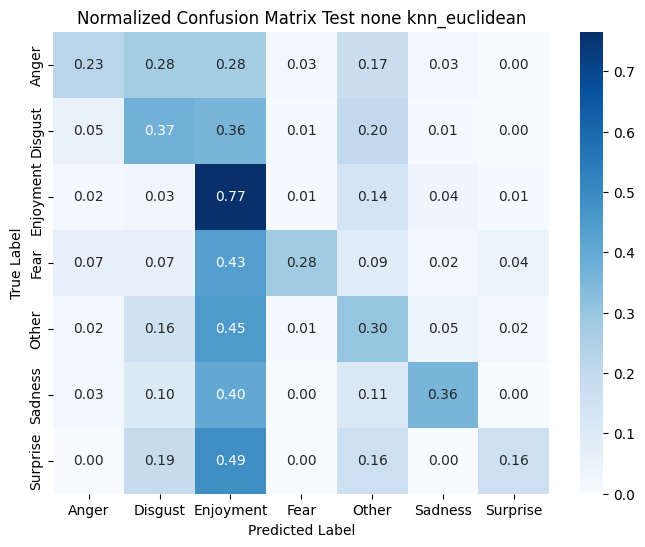

In [63]:
# KNN - euclidean - None (7:3)
model_73_knn_euclidean, train_73_knn_euclidean, valid_73_knn_euclidean, test_73_knn_euclidean, pred_73_knn_euclidean = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="knn",
    metric="euclidean"
)

y_pred_train_73_knn_euclidean, y_pred_valid_73_knn_euclidean, y_pred_test_73_knn_euclidean = pred_73_knn_euclidean

pipeline_evaluation(
    y_train_73, y_valid_73, y_test_73,
    y_pred_train_73_knn_euclidean, y_pred_valid_73_knn_euclidean, y_pred_test_73_knn_euclidean,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 7:3 --- knn --- none ---
Accuracy: 0.48998982015609094
Recall: 0.48998982015609094
Precision: 0.5369779048113071
F1-score: 0.46523360158901905

--- valid --- 7:3 --- knn --- none ---
Accuracy: 0.44061757719714967
Recall: 0.44061757719714967
Precision: 0.4847920629240773
F1-score: 0.41451625563770694

--- test --- 7:3 --- knn --- none ---
Accuracy: 0.4622093023255814
Recall: 0.4622093023255814
Precision: 0.5089500525716047
F1-score: 0.4442596374882822


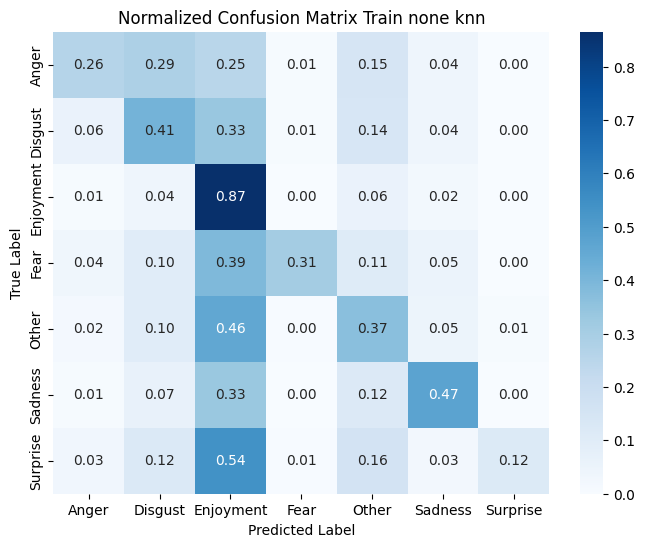

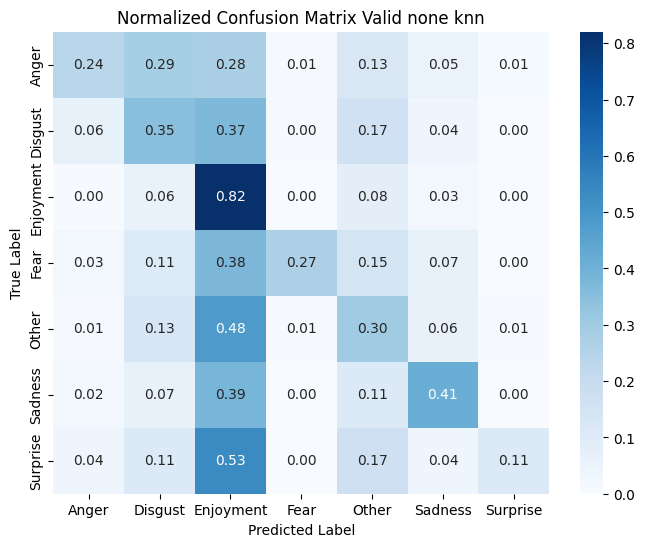

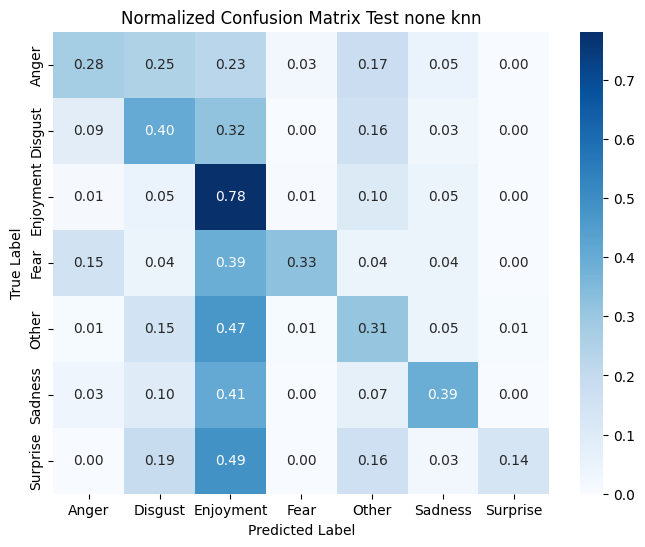

In [64]:
# KNN - cosine - none
model_73_knn, train_73_knn, valid_73_knn, test_73_knn, pred_73_knn = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="knn"
)

y_pred_train_73_knn, y_pred_valid_73_knn, y_pred_test_73_knn = pred_73_knn

pipeline_evaluation(
    y_train_73, y_valid_73, y_test_73,
    y_pred_train_73_knn, y_pred_valid_73_knn, y_pred_test_73_knn,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 7:3 --- knn_euclidean --- pca ---
Accuracy: 0.49032914828639296
Recall: 0.49032914828639296
Precision: 0.5410367395976138
F1-score: 0.4700480233069963

--- valid --- 7:3 --- knn_euclidean --- pca ---
Accuracy: 0.44695170229612036
Recall: 0.44695170229612036
Precision: 0.48407476255981374
F1-score: 0.42405769768902085

--- test --- 7:3 --- knn_euclidean --- pca ---
Accuracy: 0.4578488372093023
Recall: 0.4578488372093023
Precision: 0.5088103268576263
F1-score: 0.443908438074365


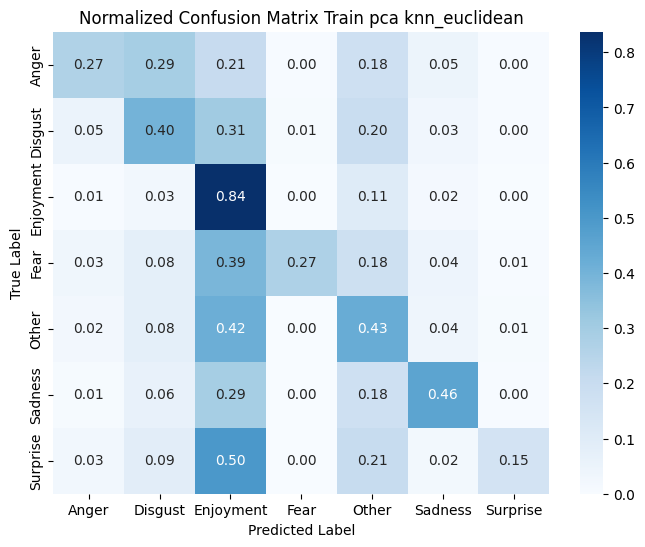

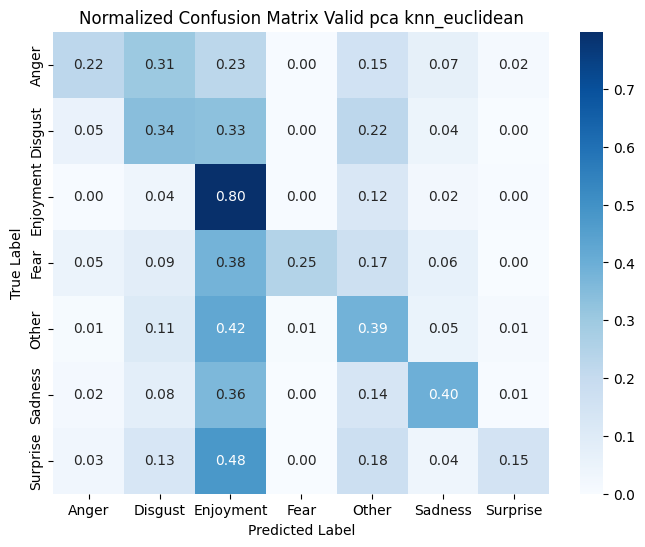

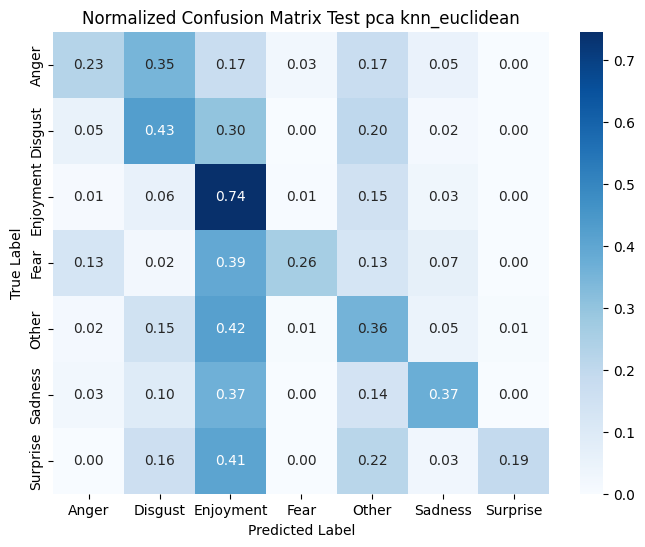

In [65]:
# KNN - euclidean - PCA (7:3)
model_pca_73_knn_euclidean, train_pca_73_knn_euclidean, valid_pca_73_knn_euclidean, test_pca_73_knn_euclidean, pred_pca_73_knn_euclidean = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="knn",
    metric="euclidean"
)

y_train_pca_73_knn_euclidean, y_valid_pca_73_knn_euclidean, y_test_pca_73_knn_euclidean = train_pca_73_knn_euclidean[1], valid_pca_73_knn_euclidean[1], test_pca_73_knn_euclidean[1]
y_pred_train_pca_73_knn_euclidean, y_pred_valid_pca_73_knn_euclidean, y_pred_test_pca_73_knn_euclidean = pred_pca_73_knn_euclidean

pipeline_evaluation(
    y_train_pca_73_knn_euclidean, y_valid_pca_73_knn_euclidean, y_test_pca_73_knn_euclidean,
    y_pred_train_pca_73_knn_euclidean, y_pred_valid_pca_73_knn_euclidean, y_pred_test_pca_73_knn_euclidean,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 7:3 --- knn --- pca ---
Accuracy: 0.48812351543942994
Recall: 0.48812351543942994
Precision: 0.535631710258208
F1-score: 0.4640495959161277

--- valid --- 7:3 --- knn --- pca ---
Accuracy: 0.4493269992082344
Recall: 0.4493269992082344
Precision: 0.48552811136395485
F1-score: 0.42285928429266484

--- test --- 7:3 --- knn --- pca ---
Accuracy: 0.4563953488372093
Recall: 0.4563953488372093
Precision: 0.5090980767009097
F1-score: 0.43755589038538767


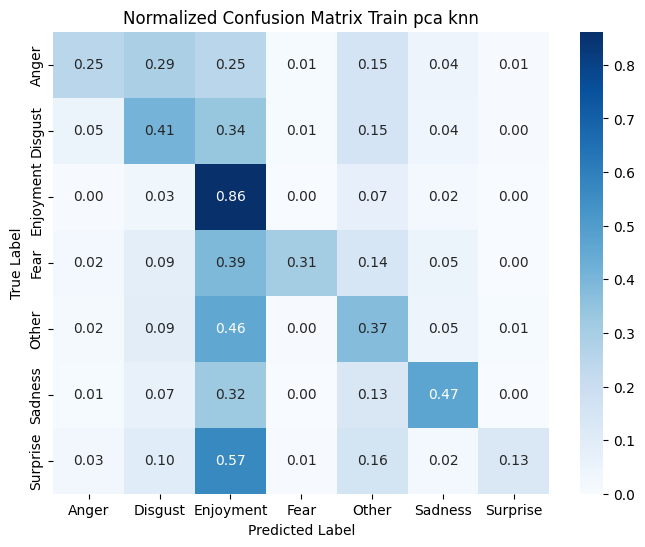

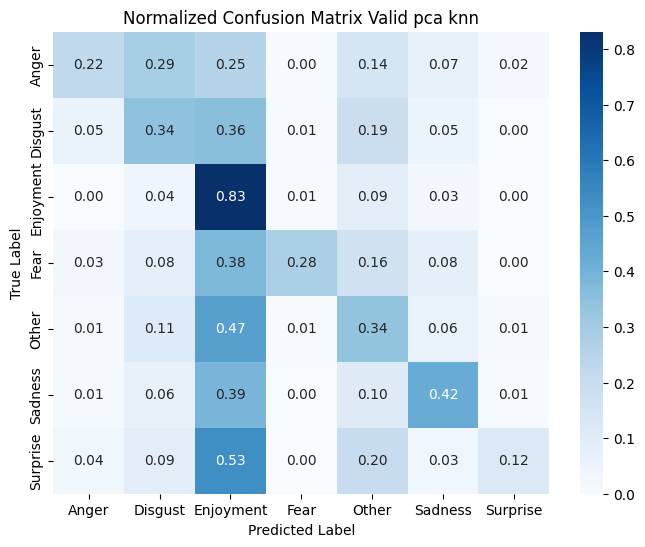

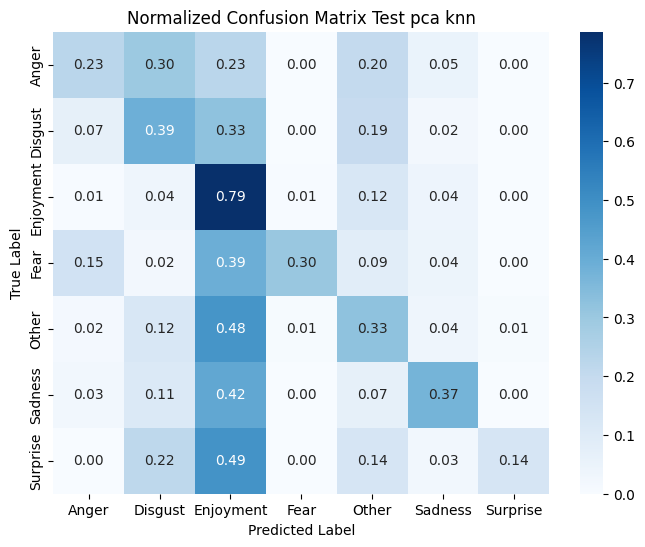

In [66]:
model_pca_73_knn, train_pca_73_knn, valid_pca_73_knn, test_pca_73_knn, pred_pca_73_knn = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="knn",
    max_iter=1000
)

y_train_pca_73_knn, y_valid_pca_73_knn, y_test_pca_73_knn = train_pca_73_knn[1], valid_pca_73_knn[1], test_pca_73_knn[1]
y_pred_train_pca_73_knn, y_pred_valid_pca_73_knn, y_pred_test_pca_73_knn = pred_pca_73_knn

pipeline_evaluation(
    y_train_pca_73_knn, y_valid_pca_73_knn, y_test_pca_73_knn,
    y_pred_train_pca_73_knn, y_pred_valid_pca_73_knn, y_pred_test_pca_73_knn,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

--- train --- 7:3 --- knn_euclidean --- lda ---
Accuracy: 0.998133695283339
Recall: 0.998133695283339
Precision: 0.9981355911223406
F1-score: 0.9981342287213295

--- valid --- 7:3 --- knn_euclidean --- lda ---
Accuracy: 0.2953285827395091
Recall: 0.2953285827395091
Precision: 0.3178724773590463
F1-score: 0.2999904932147652

--- test --- 7:3 --- knn_euclidean --- lda ---
Accuracy: 0.26453488372093026
Recall: 0.26453488372093026
Precision: 0.29708152764245443
F1-score: 0.2737155303448355


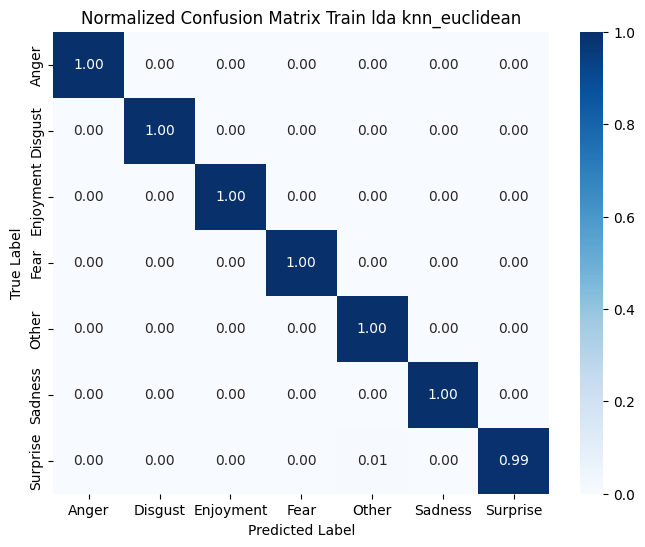

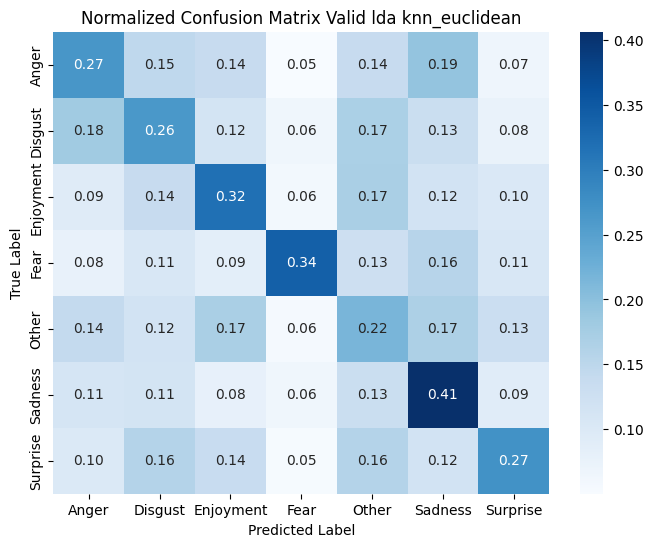

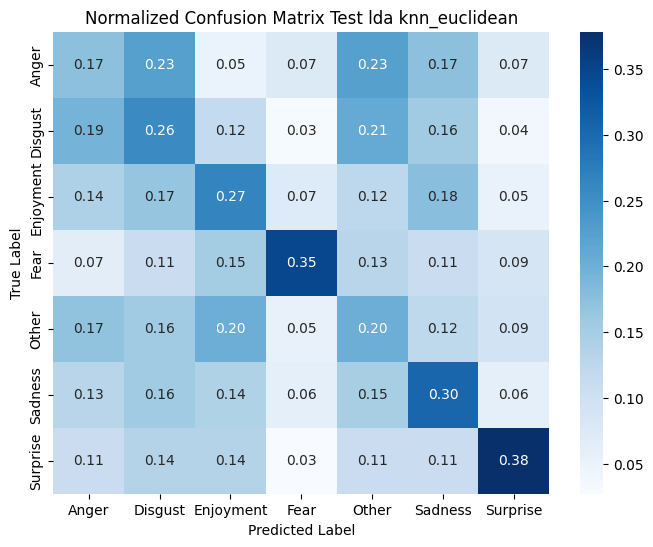

In [67]:
# KNN - euclidean - LDA (7:3)
model_lda_73_knn_euclidean, train_lda_73_knn_euclidean, valid_lda_73_knn_euclidean, test_lda_73_knn_euclidean, pred_lda_73_knn_euclidean = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="knn",
    metric="euclidean"
)

y_train_lda_73_knn_euclidean, y_valid_lda_73_knn_euclidean, y_test_lda_73_knn_euclidean = train_lda_73_knn_euclidean[1], valid_lda_73_knn_euclidean[1], test_lda_73_knn_euclidean[1]
y_pred_train_lda_73_knn_euclidean, y_pred_valid_lda_73_knn_euclidean, y_pred_test_lda_73_knn_euclidean = pred_lda_73_knn_euclidean

pipeline_evaluation(
    y_train_lda_73_knn_euclidean, y_valid_lda_73_knn_euclidean, y_test_lda_73_knn_euclidean,
    y_pred_train_lda_73_knn_euclidean, y_pred_valid_lda_73_knn_euclidean, y_pred_test_lda_73_knn_euclidean,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 7:3 --- knn --- lda ---
Accuracy: 0.996776382762131
Recall: 0.996776382762131
Precision: 0.9967994069394415
F1-score: 0.9967796099019844

--- valid --- 7:3 --- knn --- lda ---
Accuracy: 0.2905779889152811
Recall: 0.2905779889152811
Precision: 0.32351203010907587
F1-score: 0.2946717128835814

--- test --- 7:3 --- knn --- lda ---
Accuracy: 0.2616279069767442
Recall: 0.2616279069767442
Precision: 0.2994080415263571
F1-score: 0.2691249066448058


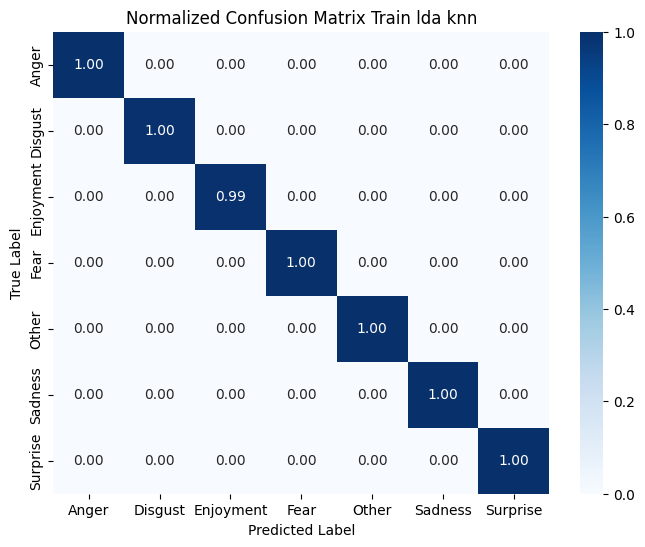

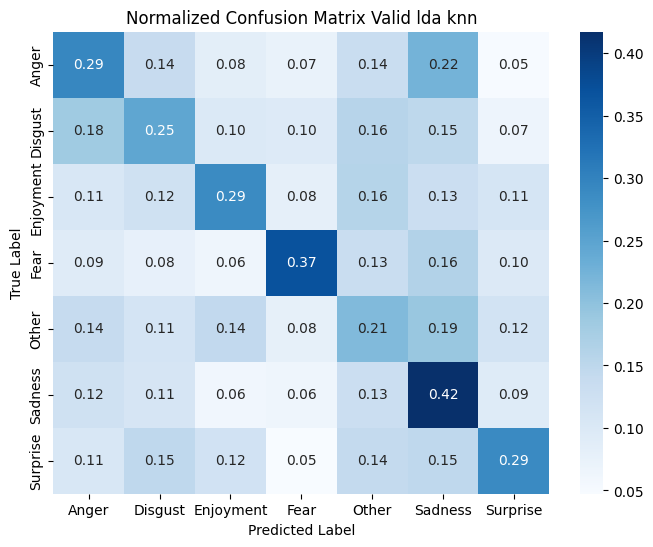

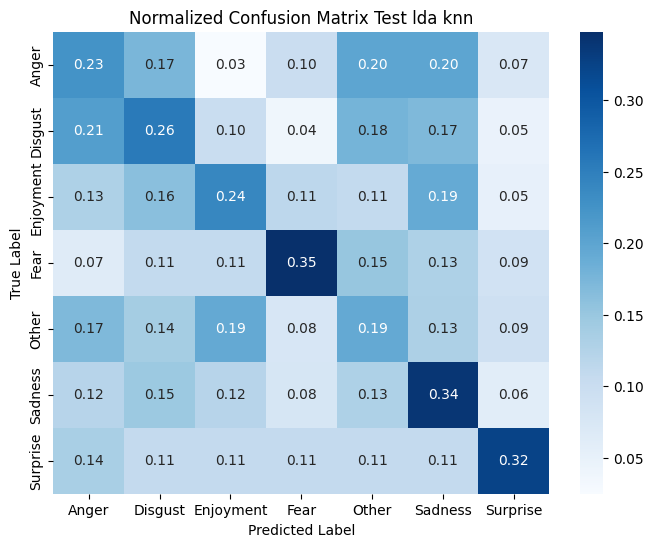

In [68]:

model_lda_73_knn, train_lda_73_knn, valid_lda_73_knn, test_lda_73_knn, pred_lda_73_knn = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="knn",
    max_iter=1000
)

y_train_lda_73_knn, y_valid_lda_73_knn, y_test_lda_73_knn = train_lda_73_knn[1], valid_lda_73_knn[1], test_lda_73_knn[1]
y_pred_train_lda_73_knn, y_pred_valid_lda_73_knn, y_pred_test_lda_73_knn = pred_lda_73_knn

pipeline_evaluation(
    y_train_lda_73_knn, y_valid_lda_73_knn, y_test_lda_73_knn,
    y_pred_train_lda_73_knn, y_pred_valid_lda_73_knn, y_pred_test_lda_73_knn,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

## SVM

### Bộ dữ liệu gốc

--- train --- 7:3 --- svm_linear --- none ---
Accuracy: 0.9453681710213777
Recall: 0.9453681710213777
Precision: 0.9464675241375181
F1-score: 0.9453961240580335

--- valid --- 7:3 --- svm_linear --- none ---
Accuracy: 0.5205859065716548
Recall: 0.5205859065716548
Precision: 0.5200105106308716
F1-score: 0.5189592936543396

--- test --- 7:3 --- svm_linear --- none ---
Accuracy: 0.5058139534883721
Recall: 0.5058139534883721
Precision: 0.515588829253816
F1-score: 0.5081986335379256


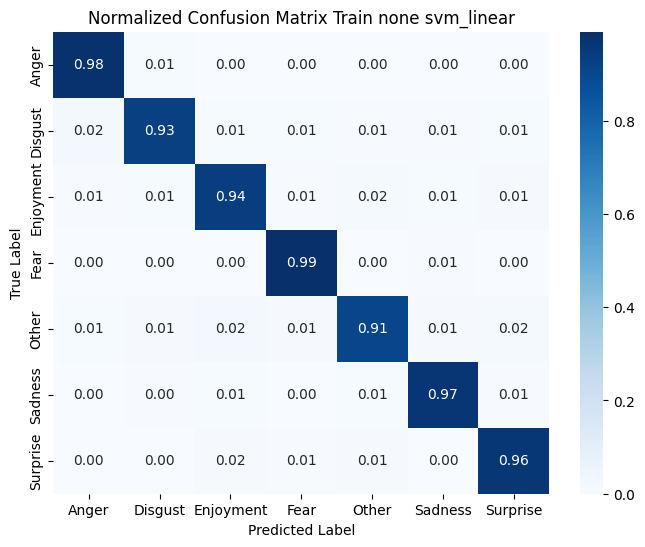

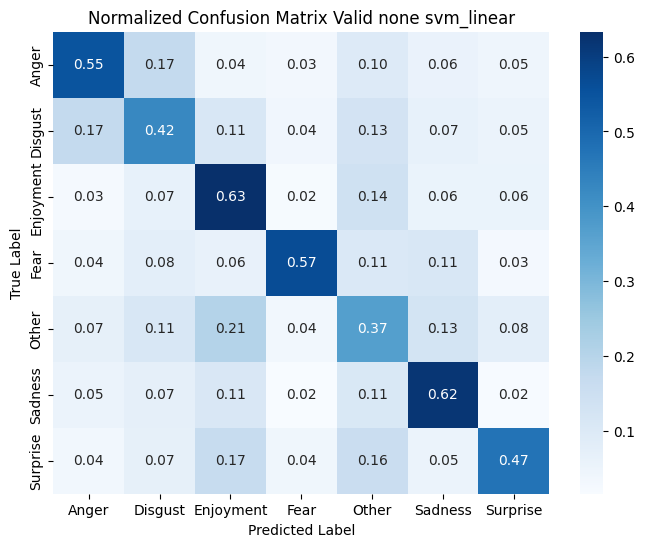

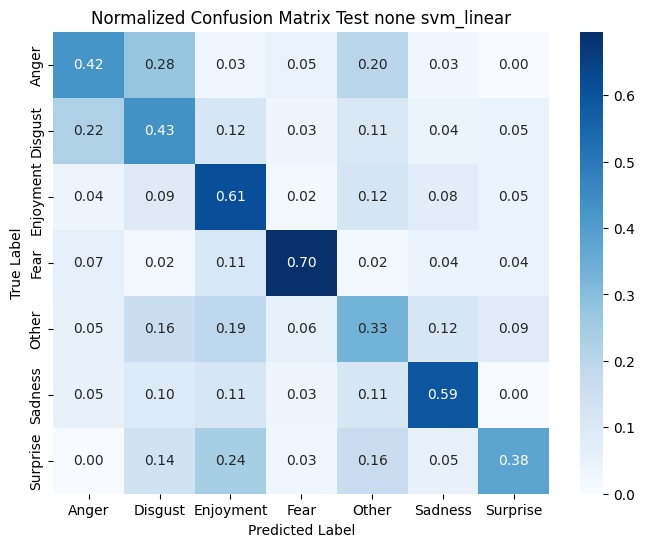

In [69]:
# SVM - linear - None (7:3)
model_73_svm_linear, train_73_svm_linear, valid_73_svm_linear, test_73_svm_linear, pred_73_svm_linear = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_73_svm_linear, y_valid_73_svm_linear, y_test_73_svm_linear = train_73_svm_linear[1], valid_73_svm_linear[1], test_73_svm_linear[1]
y_pred_train_73_svm_linear, y_pred_valid_73_svm_linear, y_pred_test_73_svm_linear = pred_73_svm_linear

pipeline_evaluation(
    y_train_73_svm_linear, y_valid_73_svm_linear, y_test_73_svm_linear,
    y_pred_train_73_svm_linear, y_pred_valid_73_svm_linear, y_pred_test_73_svm_linear,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="svm_linear",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

--- train --- 7:3 --- svm_poly --- none ---
Accuracy: 0.18934509670851712
Recall: 0.18934509670851712
Precision: 0.5616271731850784
F1-score: 0.07579297959239567

--- valid --- 7:3 --- svm_poly --- none ---
Accuracy: 0.18527315914489312
Recall: 0.18527315914489312
Precision: 0.5405544338612508
F1-score: 0.0680540129020202

--- test --- 7:3 --- svm_poly --- none ---
Accuracy: 0.19476744186046513
Recall: 0.19476744186046513
Precision: 0.5484950117470803
F1-score: 0.07378276100244908


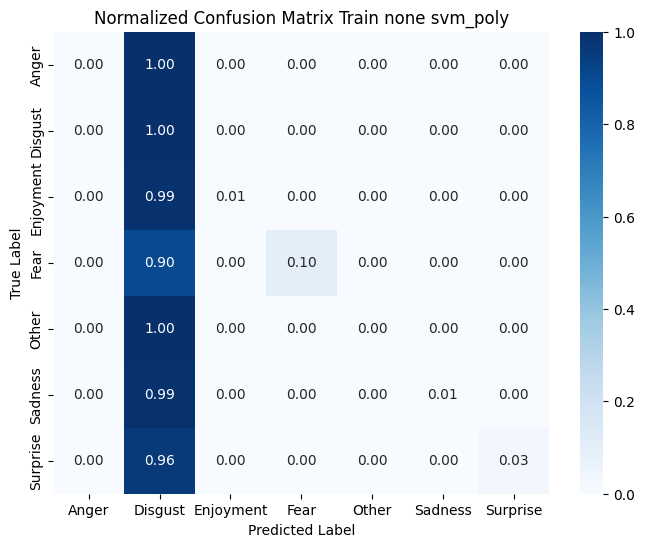

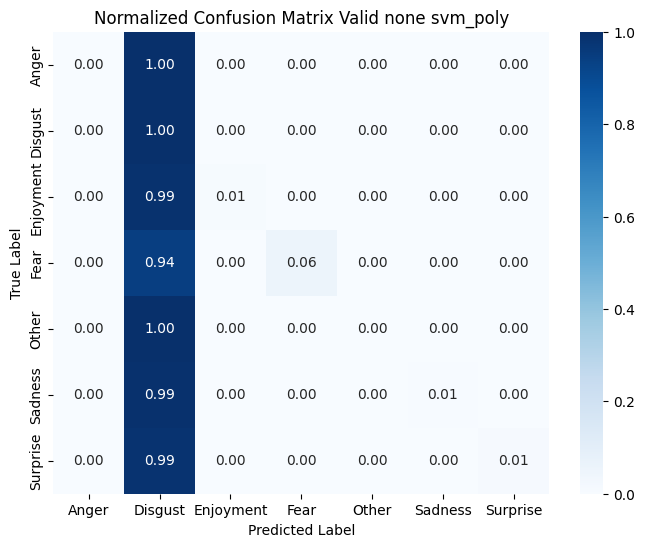

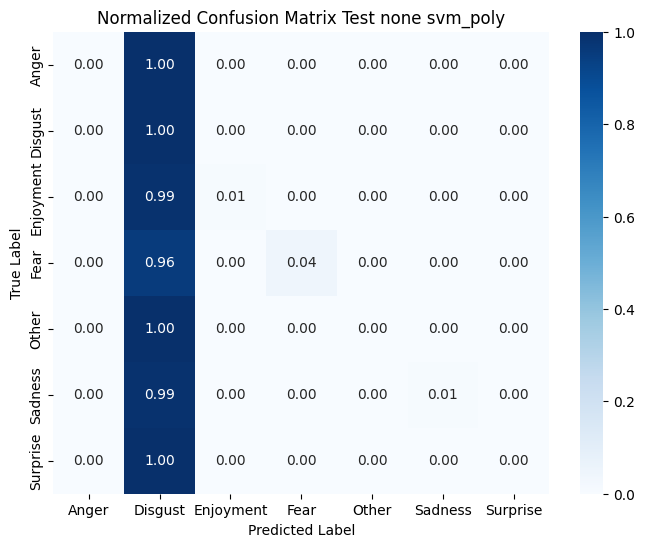

In [70]:
# SVM - poly - None (7:3)
model_73_svm_poly, train_73_svm_poly, valid_73_svm_poly, test_73_svm_poly, pred_73_svm_poly = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_73_svm_poly, y_valid_73_svm_poly, y_test_73_svm_poly = train_73_svm_poly[1], valid_73_svm_poly[1], test_73_svm_poly[1]
y_pred_train_73_svm_poly, y_pred_valid_73_svm_poly, y_pred_test_73_svm_poly = pred_73_svm_poly

pipeline_evaluation(
    y_train_73_svm_poly, y_valid_73_svm_poly, y_test_73_svm_poly,
    y_pred_train_73_svm_poly, y_pred_valid_73_svm_poly, y_pred_test_73_svm_poly,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="svm_poly",
    show_plot=True
)

--- train --- 7:3 --- svm_rbf --- none ---
Accuracy: 0.9633525619273838
Recall: 0.9633525619273838
Precision: 0.9638303188782489
F1-score: 0.963268287548392

--- valid --- 7:3 --- svm_rbf --- none ---
Accuracy: 0.5261282660332541
Recall: 0.5261282660332541
Precision: 0.5497164900654419
F1-score: 0.5303179529327778

--- test --- 7:3 --- svm_rbf --- none ---
Accuracy: 0.5276162790697675
Recall: 0.5276162790697675
Precision: 0.5668699864785965
F1-score: 0.5365377878076003


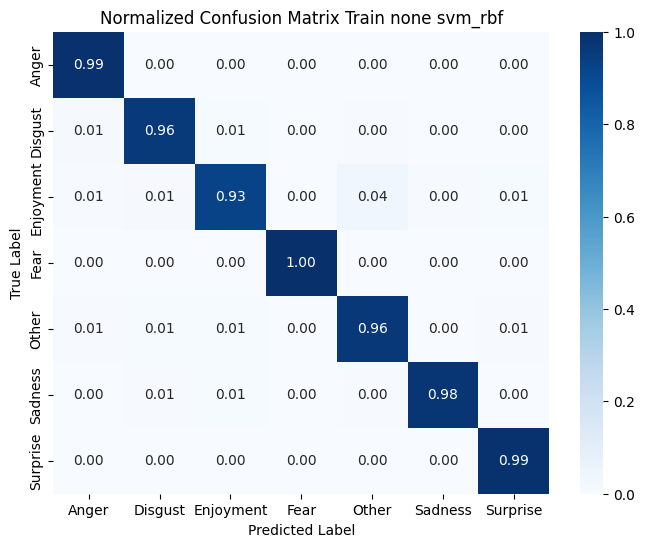

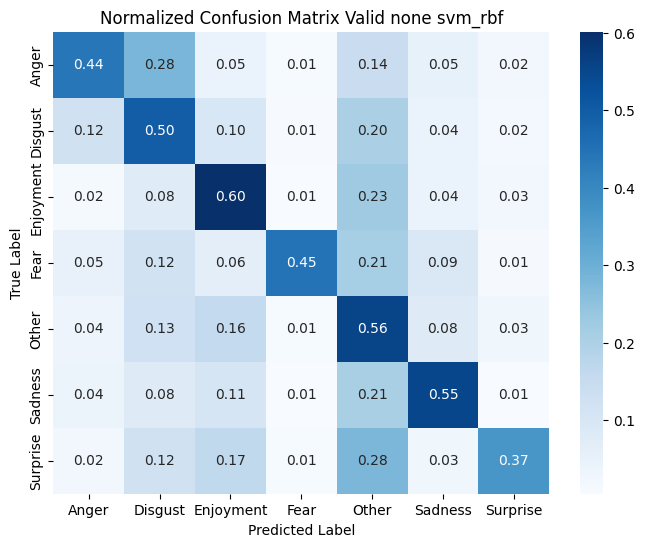

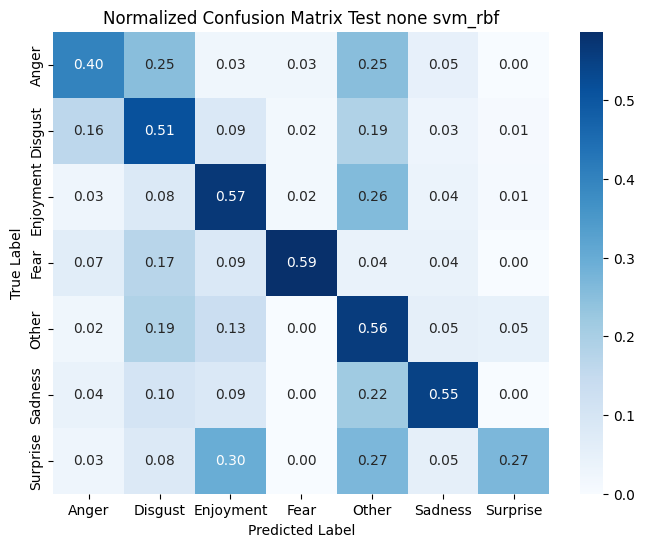

In [71]:
# SVM - rbf - None (7:3)
model_73_svm_rbf, train_73_svm_rbf, valid_73_svm_rbf, test_73_svm_rbf, pred_73_svm_rbf = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_73_svm_rbf, y_valid_73_svm_rbf, y_test_73_svm_rbf = train_73_svm_rbf[1], valid_73_svm_rbf[1], test_73_svm_rbf[1]
y_pred_train_73_svm_rbf, y_pred_valid_73_svm_rbf, y_pred_test_73_svm_rbf = pred_73_svm_rbf

pipeline_evaluation(
    y_train_73_svm_rbf, y_valid_73_svm_rbf, y_test_73_svm_rbf,
    y_pred_train_73_svm_rbf, y_pred_valid_73_svm_rbf, y_pred_test_73_svm_rbf,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="svm_rbf",
    show_plot=True
)

## Bộ dữ liệu PCA

--- train --- 7:3 --- svm_linear --- pca ---
Accuracy: 0.8769935527655243
Recall: 0.8769935527655243
Precision: 0.879586095942945
F1-score: 0.8765840603861236

--- valid --- 7:3 --- svm_linear --- pca ---
Accuracy: 0.5166270783847982
Recall: 0.5166270783847982
Precision: 0.5165689395204367
F1-score: 0.5148463488652298

--- test --- 7:3 --- svm_linear --- pca ---
Accuracy: 0.5218023255813954
Recall: 0.5218023255813954
Precision: 0.5320515123530782
F1-score: 0.5243354486751209


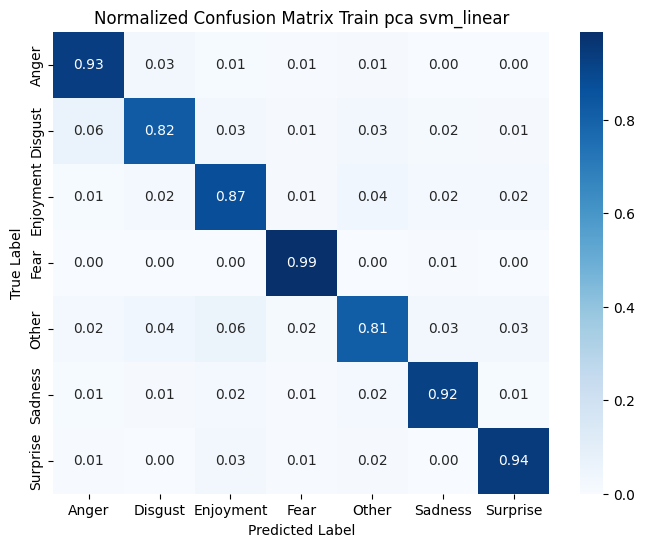

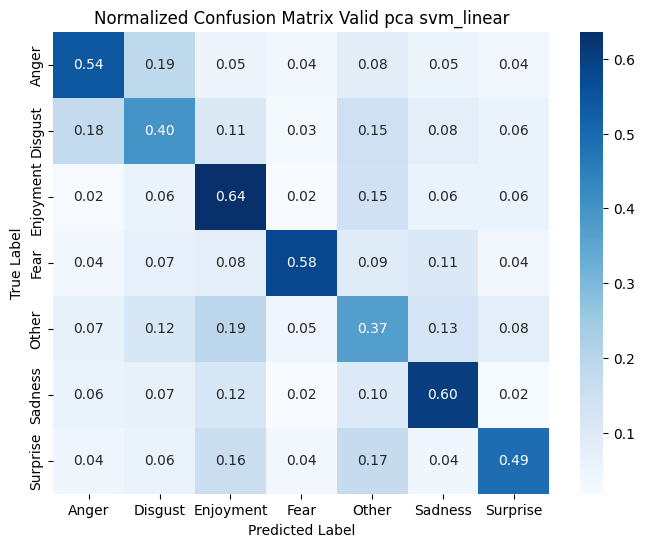

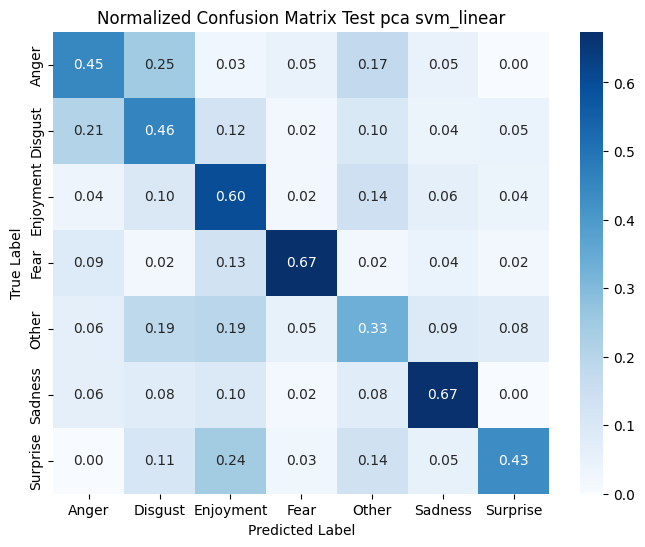

In [72]:
# SVM - linear - PCA (7:3)
model_pca_73_svm_linear, train_pca_73_svm_linear, valid_pca_73_svm_linear, test_pca_73_svm_linear, pred_pca_73_svm_linear = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_pca_73_svm_linear, y_valid_pca_73_svm_linear, y_test_pca_73_svm_linear = train_pca_73_svm_linear[1], valid_pca_73_svm_linear[1], test_pca_73_svm_linear[1]
y_pred_train_pca_73_svm_linear, y_pred_valid_pca_73_svm_linear, y_pred_test_pca_73_svm_linear = pred_pca_73_svm_linear

pipeline_evaluation(
    y_train_pca_73_svm_linear, y_valid_pca_73_svm_linear, y_test_pca_73_svm_linear,
    y_pred_train_pca_73_svm_linear, y_pred_valid_pca_73_svm_linear, y_pred_test_pca_73_svm_linear,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="svm_linear",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

--- train --- 7:3 --- svm_poly --- pca ---
Accuracy: 0.1990159484221242
Recall: 0.1990159484221242
Precision: 0.5576764166652094
F1-score: 0.09437106787556465

--- valid --- 7:3 --- svm_poly --- pca ---
Accuracy: 0.18962787015043547
Recall: 0.18962787015043547
Precision: 0.5462835806212584
F1-score: 0.07667066115441362

--- test --- 7:3 --- svm_poly --- pca ---
Accuracy: 0.19912790697674418
Recall: 0.19912790697674418
Precision: 0.6024303180574556
F1-score: 0.08249955902511191


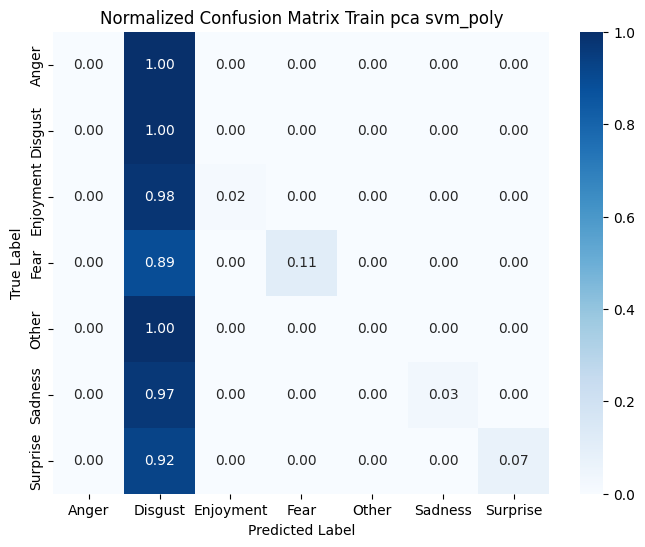

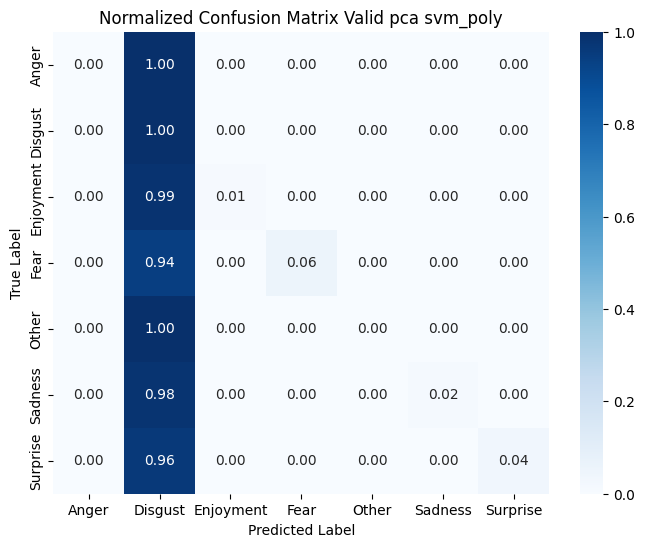

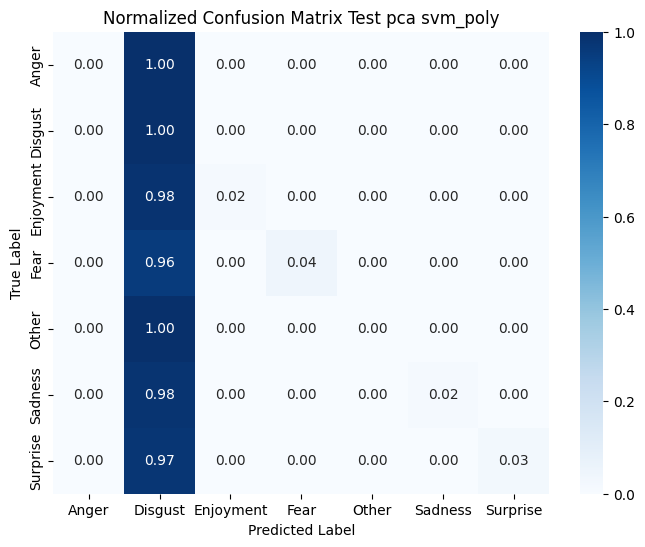

In [73]:
# SVM - poly - PCA (7:3)
model_pca_73_svm_poly, train_pca_73_svm_poly, valid_pca_73_svm_poly, test_pca_73_svm_poly, pred_pca_73_svm_poly = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_pca_73_svm_poly, y_valid_pca_73_svm_poly, y_test_pca_73_svm_poly = train_pca_73_svm_poly[1], valid_pca_73_svm_poly[1], test_pca_73_svm_poly[1]
y_pred_train_pca_73_svm_poly, y_pred_valid_pca_73_svm_poly, y_pred_test_pca_73_svm_poly = pred_pca_73_svm_poly

pipeline_evaluation(
    y_train_pca_73_svm_poly, y_valid_pca_73_svm_poly, y_test_pca_73_svm_poly,
    y_pred_train_pca_73_svm_poly, y_pred_valid_pca_73_svm_poly, y_pred_test_pca_73_svm_poly,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="svm_poly",
    show_plot=True
)

--- train --- 7:3 --- svm_rbf --- pca ---
Accuracy: 0.9395995928062436
Recall: 0.9395995928062436
Precision: 0.9404589166631828
F1-score: 0.939430953281039

--- valid --- 7:3 --- svm_rbf --- pca ---
Accuracy: 0.5150435471100554
Recall: 0.5150435471100554
Precision: 0.5353605850988798
F1-score: 0.5211336119453504

--- test --- 7:3 --- svm_rbf --- pca ---
Accuracy: 0.498546511627907
Recall: 0.498546511627907
Precision: 0.5391425131293964
F1-score: 0.5105864028570735


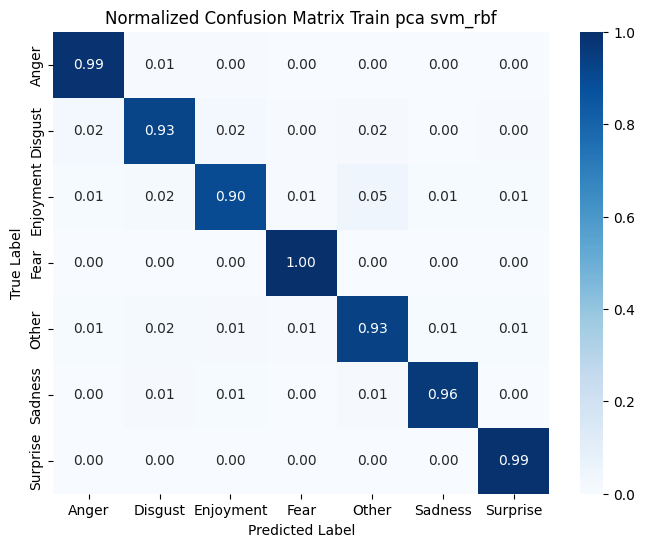

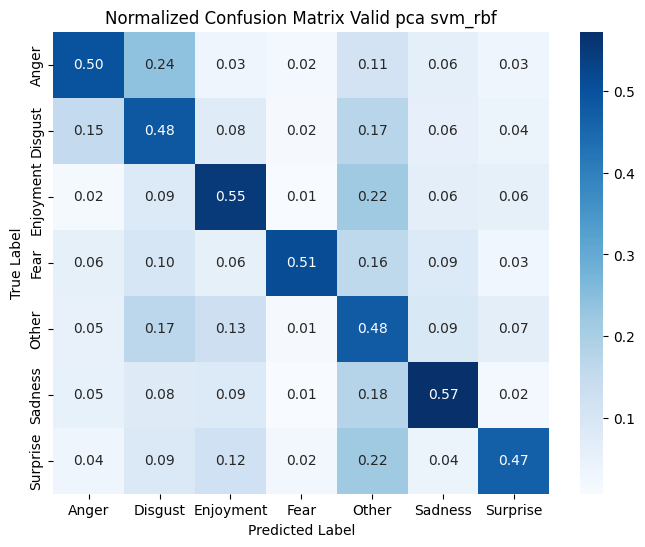

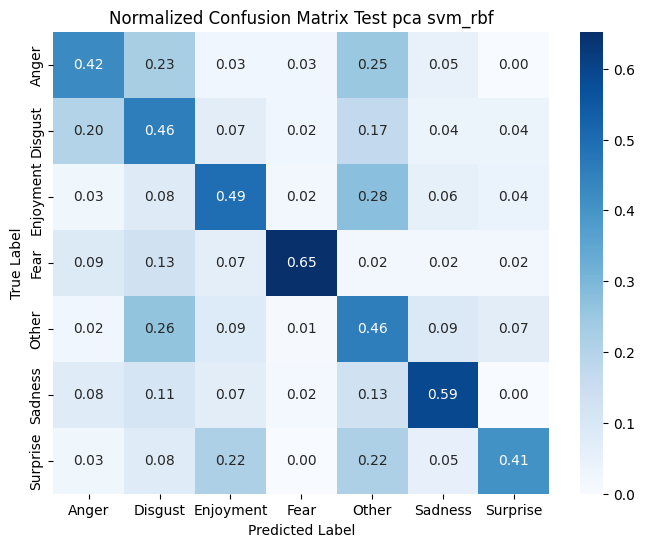

In [74]:
# SVM - rbf - PCA (7:3)
model_pca_73_svm_rbf, train_pca_73_svm_rbf, valid_pca_73_svm_rbf, test_pca_73_svm_rbf, pred_pca_73_svm_rbf = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_pca_73_svm_rbf, y_valid_pca_73_svm_rbf, y_test_pca_73_svm_rbf = train_pca_73_svm_rbf[1], valid_pca_73_svm_rbf[1], test_pca_73_svm_rbf[1]
y_pred_train_pca_73_svm_rbf, y_pred_valid_pca_73_svm_rbf, y_pred_test_pca_73_svm_rbf = pred_pca_73_svm_rbf

pipeline_evaluation(
    y_train_pca_73_svm_rbf, y_valid_pca_73_svm_rbf, y_test_pca_73_svm_rbf,
    y_pred_train_pca_73_svm_rbf, y_pred_valid_pca_73_svm_rbf, y_pred_test_pca_73_svm_rbf,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="svm_rbf",
    show_plot=True
)

## Bộ dữ liệu LDA

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--- train --- 7:3 --- svm_linear --- lda ---
Accuracy: 0.9977943671530369
Recall: 0.9977943671530369
Precision: 0.9978148074283122
F1-score: 0.9977986133785389

--- valid --- 7:3 --- svm_linear --- lda ---
Accuracy: 0.2862232779097387
Recall: 0.2862232779097387
Precision: 0.30296863686812237
F1-score: 0.29080204868740767

--- test --- 7:3 --- svm_linear --- lda ---
Accuracy: 0.2616279069767442
Recall: 0.2616279069767442
Precision: 0.2835030065003741
F1-score: 0.26623504534046094


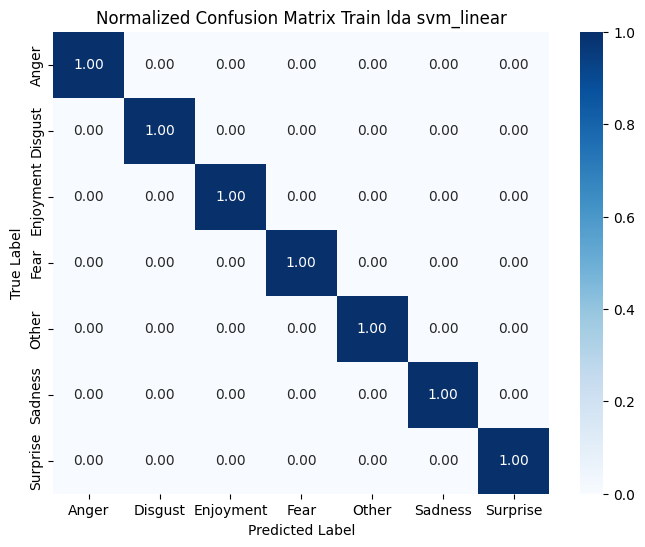

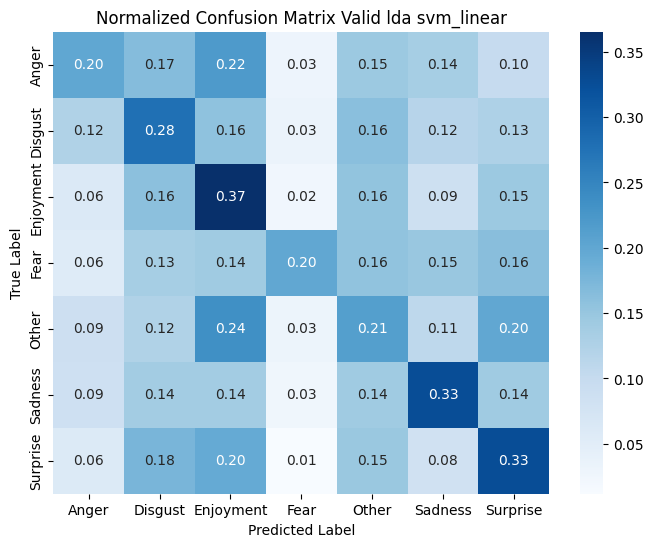

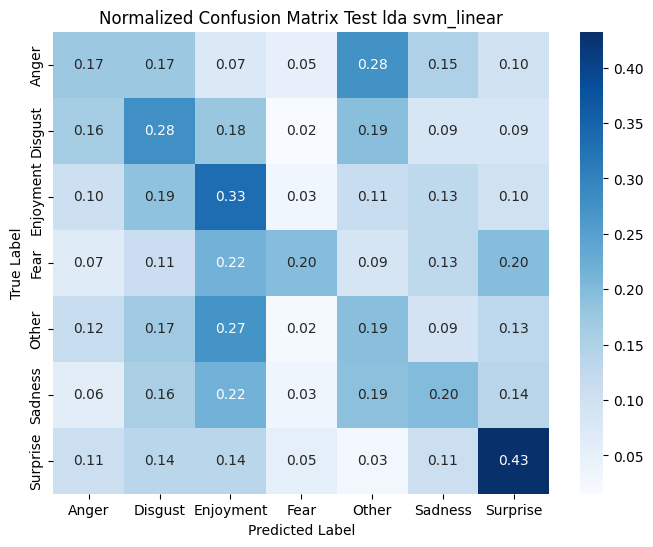

In [75]:
# SVM - linear - LDA (7:3)
model_lda_73_svm_linear, train_lda_73_svm_linear, valid_lda_73_svm_linear, test_lda_73_svm_linear, pred_lda_73_svm_linear = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_lda_73_svm_linear, y_valid_lda_73_svm_linear, y_test_lda_73_svm_linear = train_lda_73_svm_linear[1], valid_lda_73_svm_linear[1], test_lda_73_svm_linear[1]
y_pred_train_lda_73_svm_linear, y_pred_valid_lda_73_svm_linear, y_pred_test_lda_73_svm_linear = pred_lda_73_svm_linear

pipeline_evaluation(
    y_train_lda_73_svm_linear, y_valid_lda_73_svm_linear, y_test_lda_73_svm_linear,
    y_pred_train_lda_73_svm_linear, y_pred_valid_lda_73_svm_linear, y_pred_test_lda_73_svm_linear,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="svm_linear",
    show_plot=True
)

--- train --- 7:3 --- svm_poly --- lda ---
Accuracy: 0.995928062436376
Recall: 0.995928062436376
Precision: 0.9959726681714665
F1-score: 0.9959333202631653

--- valid --- 7:3 --- svm_poly --- lda ---
Accuracy: 0.22604908946951702
Recall: 0.22604908946951702
Precision: 0.25446132298490265
F1-score: 0.22831667784829254

--- test --- 7:3 --- svm_poly --- lda ---
Accuracy: 0.22093023255813954
Recall: 0.22093023255813954
Precision: 0.26104953973073997
F1-score: 0.2262981414514177


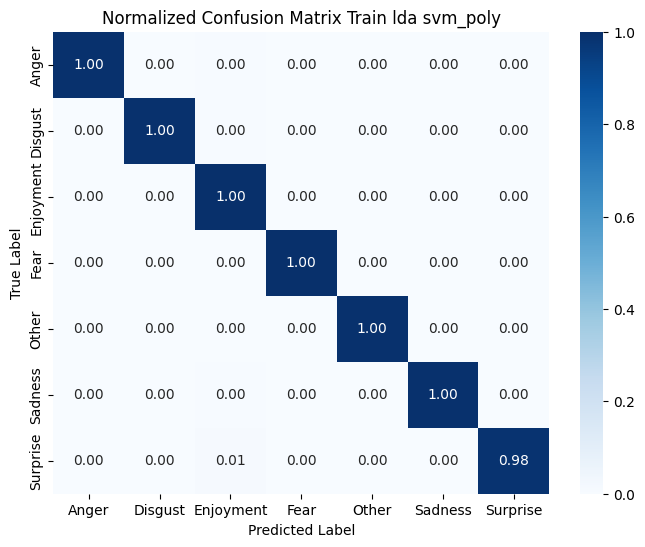

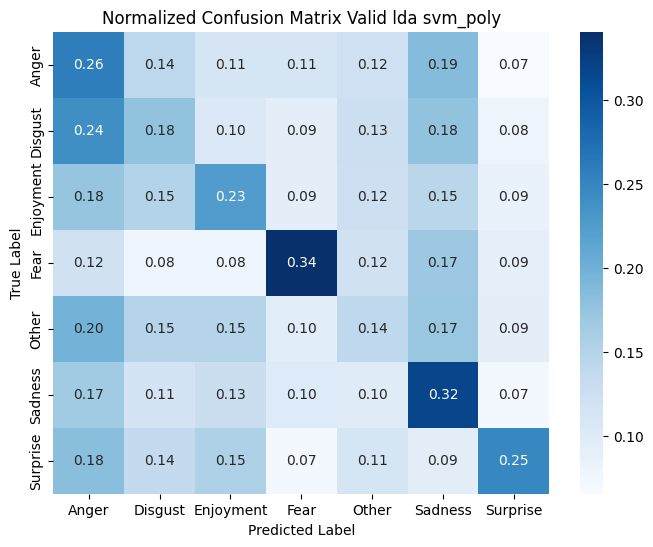

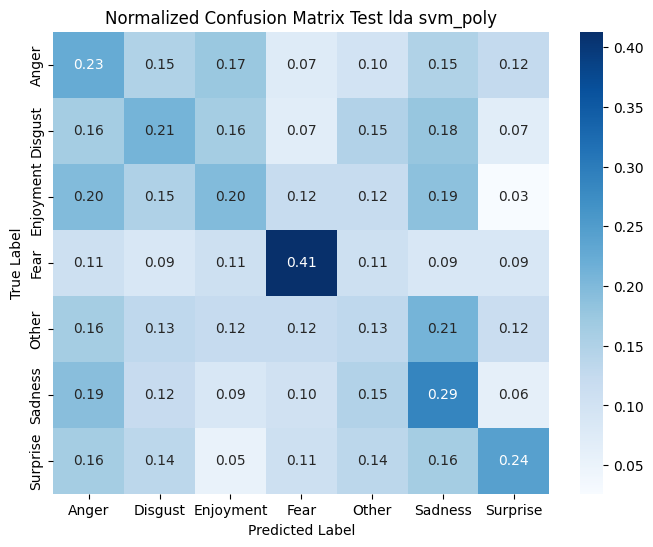

In [76]:
# SVM - poly - LDA (7:3)
model_lda_73_svm_poly, train_lda_73_svm_poly, valid_lda_73_svm_poly, test_lda_73_svm_poly, pred_lda_73_svm_poly = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_lda_73_svm_poly, y_valid_lda_73_svm_poly, y_test_lda_73_svm_poly = train_lda_73_svm_poly[1], valid_lda_73_svm_poly[1], test_lda_73_svm_poly[1]
y_pred_train_lda_73_svm_poly, y_pred_valid_lda_73_svm_poly, y_pred_test_lda_73_svm_poly = pred_lda_73_svm_poly

pipeline_evaluation(
    y_train_lda_73_svm_poly, y_valid_lda_73_svm_poly, y_test_lda_73_svm_poly,
    y_pred_train_lda_73_svm_poly, y_pred_valid_lda_73_svm_poly, y_pred_test_lda_73_svm_poly,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="svm_poly",
    show_plot=True
)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- train --- 7:3 --- svm_rbf --- lda ---
Accuracy: 0.998133695283339
Recall: 0.998133695283339
Precision: 0.9981490103316115
F1-score: 0.9981367995932605

--- valid --- 7:3 --- svm_rbf --- lda ---
Accuracy: 0.2620744259699129
Recall: 0.2620744259699129
Precision: 0.19430255096104457
F1-score: 0.11236924231329783

--- test --- 7:3 --- svm_rbf --- lda ---
Accuracy: 0.2805232558139535
Recall: 0.2805232558139535
Precision: 0.24525815309512508
F1-score: 0.12493520896621138


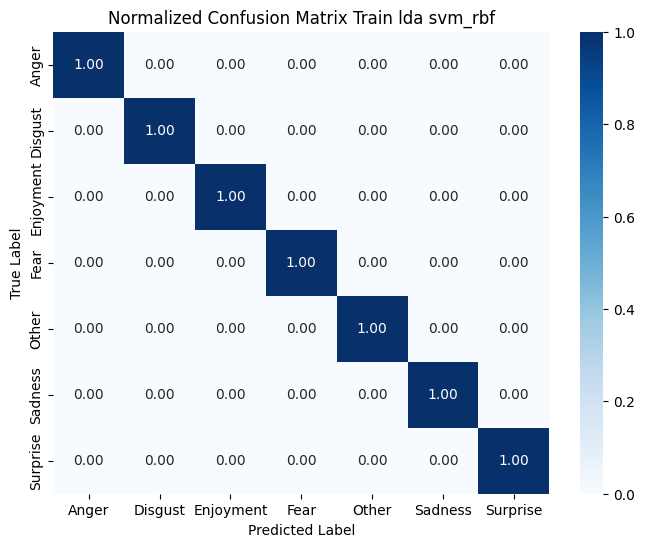

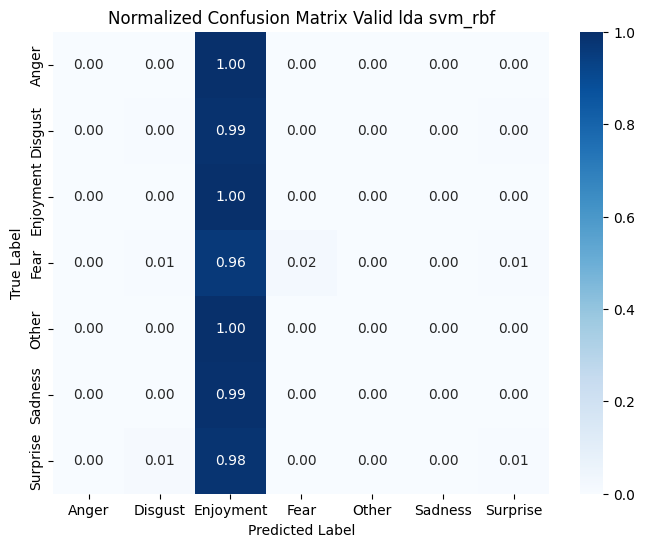

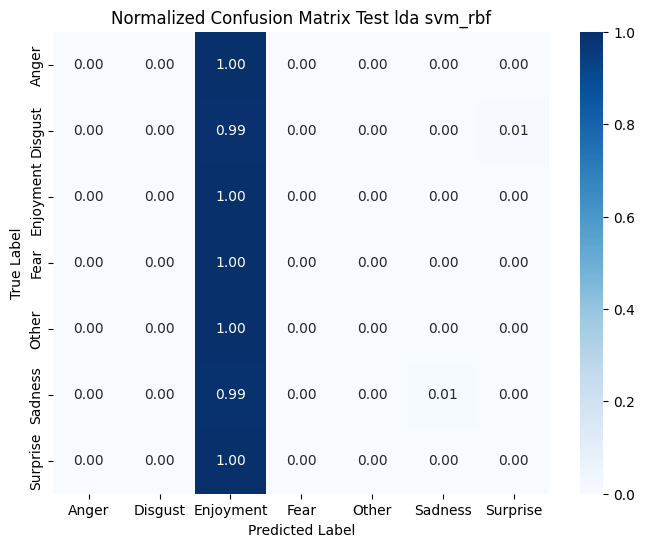

In [77]:
# SVM - rbf - LDA (7:3)
model_lda_73_svm_rbf, train_lda_73_svm_rbf, valid_lda_73_svm_rbf, test_lda_73_svm_rbf, pred_lda_73_svm_rbf = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_lda_73_svm_rbf, y_valid_lda_73_svm_rbf, y_test_lda_73_svm_rbf = train_lda_73_svm_rbf[1], valid_lda_73_svm_rbf[1], test_lda_73_svm_rbf[1]
y_pred_train_lda_73_svm_rbf, y_pred_valid_lda_73_svm_rbf, y_pred_test_lda_73_svm_rbf = pred_lda_73_svm_rbf

pipeline_evaluation(
    y_train_lda_73_svm_rbf, y_valid_lda_73_svm_rbf, y_test_lda_73_svm_rbf,
    y_pred_train_lda_73_svm_rbf, y_pred_valid_lda_73_svm_rbf, y_pred_test_lda_73_svm_rbf,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="svm_rbf",
    show_plot=True
)

# Train:Validation = 6:4

## Logistic Regression

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (5052, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 68473


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.8345209817893904
Recall: 0.8345209817893904
Precision: 0.8408556938755346
F1-score: 0.8339808231548965

--- valid --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5095011876484561
Recall: 0.5095011876484561
Precision: 0.5197568324788652
F1-score: 0.5105605583015065

--- test --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5101744186046512
Recall: 0.5101744186046512
Precision: 0.5314221759838178
F1-score: 0.5164612322139551


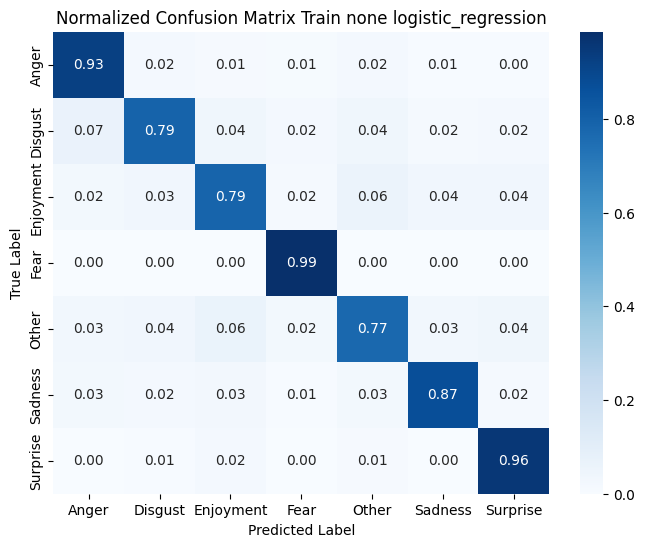

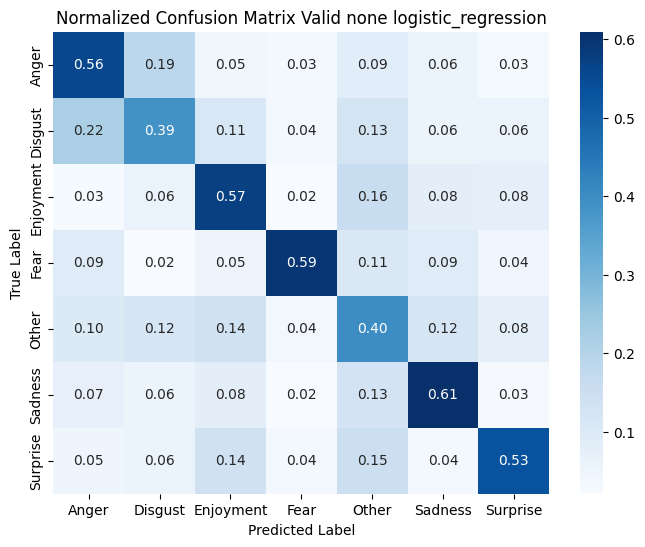

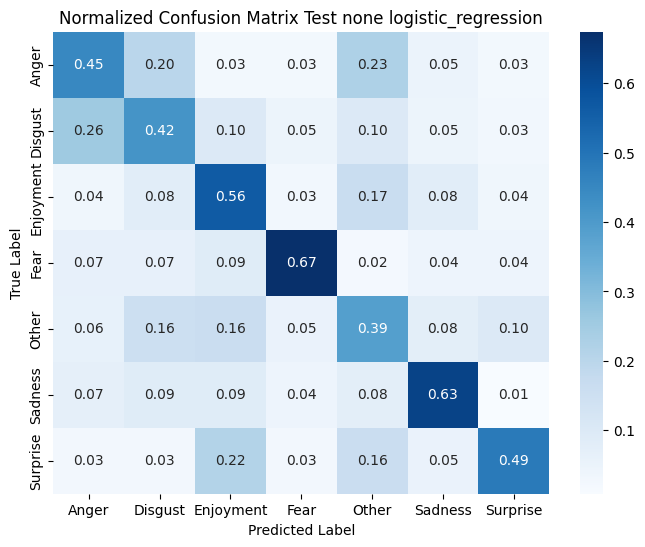

In [78]:
X_train_64, X_valid_64, X_test_64, y_train_64, y_valid_64, y_test_64, tfidf_vec_64, disc_model_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="none"
)

model_64, train_64, valid_64, test_64, pred_64 = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_64, y_pred_valid_64, y_pred_test_64 = pred_64
pipeline_evaluation(
    y_train_64, y_valid_64, y_test_64,
    y_pred_train_64, y_pred_valid_64, y_pred_test_64,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

In [79]:
X_train_pca_64, X_valid_pca_64, X_test_pca_64, y_train_pca_64, y_valid_pca_64, y_test_pca_64, tfidf_vec_pca_64, disc_model_pca_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="pca"
)

model_pca_64, train_pca_64, valid_pca_64, test_pca_64, pred_pca_64 = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_pca_64, y_pred_valid_pca_64, y_pred_test_pca_64 = pred_pca_64

pipeline_evaluation(
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    y_pred_train_pca_64, y_pred_valid_pca_64, y_pred_test_pca_64,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

TF-IDF hoàn thành!
Shape: (5052, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 68473


MemoryError: Unable to allocate 308. MiB for an array with shape (5052, 8000) and data type float64

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (5174, 6985) (số câu x số từ vựng)
Số từ vựng: 6985
TF-IDF - Non-zero values: 57830


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.9976807112485504
Recall: 0.9976807112485504
Precision: 0.9977454426637807
F1-score: 0.9976954425458414

--- valid --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.25623188405797104
Recall: 0.25623188405797104
Precision: 0.3138364620271498
F1-score: 0.2693206962828654

--- test --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.2592764378478664
Recall: 0.2592764378478664
Precision: 0.31811730805367977
F1-score: 0.2743750338934628


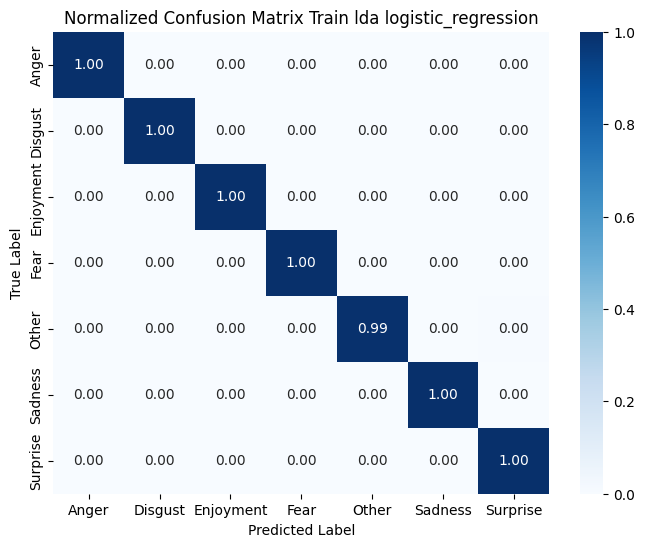

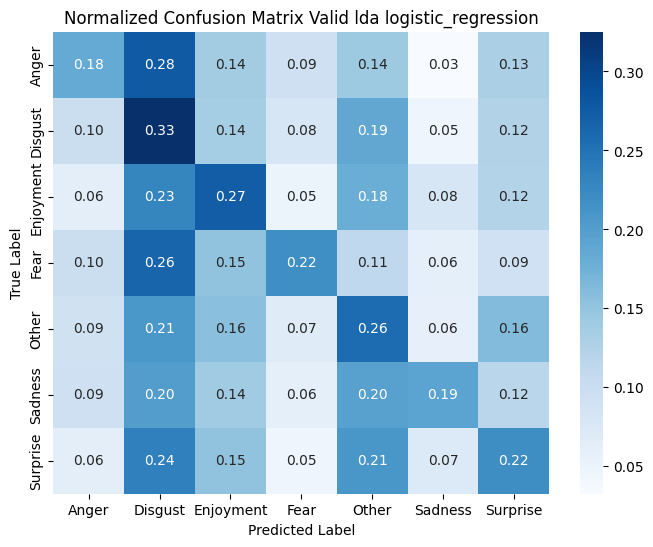

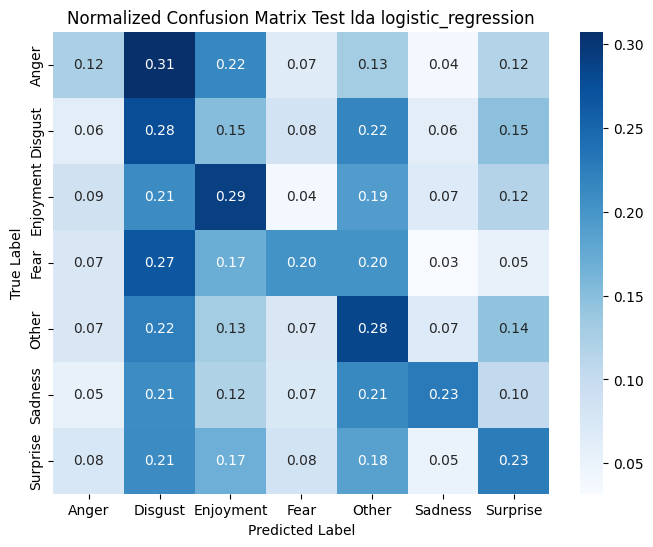

In [ ]:
X_train_lda_64, X_valid_lda_64, X_test_lda_64, y_train_lda_64, y_valid_lda_64, y_test_lda_64, tfidf_vec_lda_64, disc_model_lda_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="lda"
)

model_lda_64, train_lda_64, valid_lda_64, test_lda_64, pred_lda_64 = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_lda_64, y_pred_valid_lda_64, y_pred_test_lda_64 = pred_lda_64

pipeline_evaluation(
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    y_pred_train_lda_64, y_pred_valid_lda_64, y_pred_test_lda_64,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

In [ ]:
# KNN - euclidean - None (6:4)
model_64_knn_euclidean, train_64_knn_euclidean, valid_64_knn_euclidean, test_64_knn_euclidean, pred_64_knn_euclidean = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="knn",
    metric="euclidean"
)

y_train_64_knn_euclidean, y_valid_64_knn_euclidean, y_test_64_knn_euclidean = train_64_knn_euclidean[1], valid_64_knn_euclidean[1], test_64_knn_euclidean[1]
y_pred_train_64_knn_euclidean, y_pred_valid_64_knn_euclidean, y_pred_test_64_knn_euclidean = pred_64_knn_euclidean

pipeline_evaluation(
    y_train_64_knn_euclidean, y_valid_64_knn_euclidean, y_test_64_knn_euclidean,
    y_pred_train_64_knn_euclidean, y_pred_valid_64_knn_euclidean, y_pred_test_64_knn_euclidean,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 6:4 --- knn --- none ---
Accuracy: 0.4723618090452261
Recall: 0.4723618090452261
Precision: 0.5329958521326246
F1-score: 0.4165439672231605

--- valid --- 6:4 --- knn --- none ---
Accuracy: 0.45159420289855073
Recall: 0.45159420289855073
Precision: 0.4957317296723924
F1-score: 0.38958765619536

--- test --- 6:4 --- knn --- none ---
Accuracy: 0.4582560296846011
Recall: 0.4582560296846011
Precision: 0.5196901220255553
F1-score: 0.3992524139964641


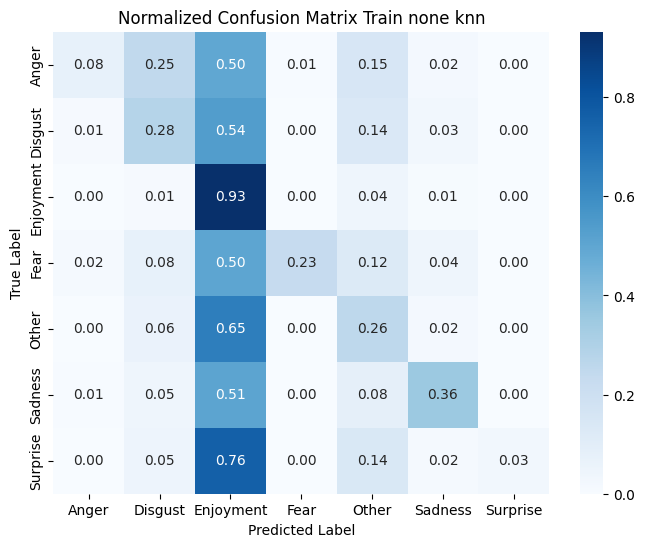

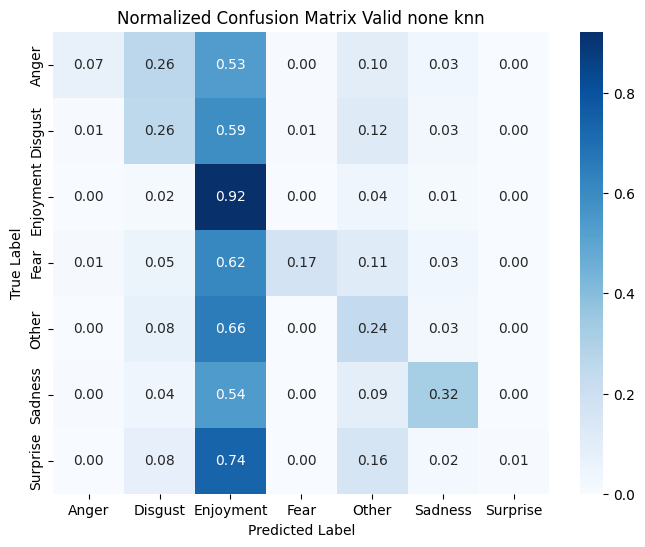

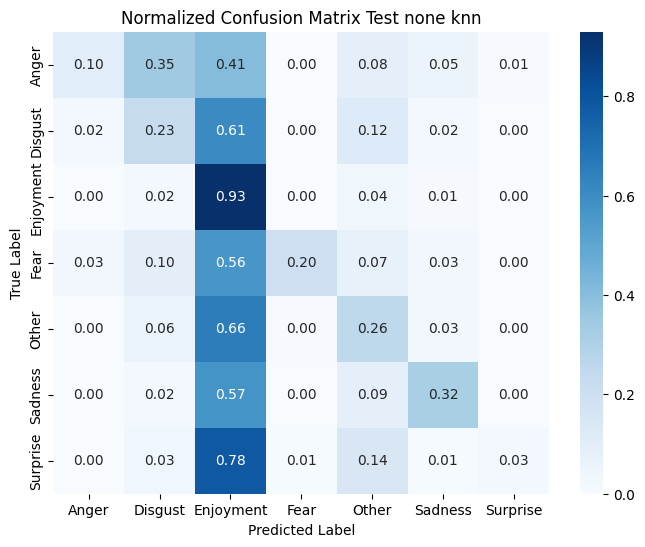

In [ ]:
model_64_knn, train_64_knn, valid_64_knn, test_64_knn, pred_64_knn = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="knn"
)

y_train_64_knn, y_valid_64_knn, y_test_64_knn = train_64_knn[1], valid_64_knn[1], test_64_knn[1]
y_pred_train_64_knn, y_pred_valid_64_knn, y_pred_test_64_knn = pred_64_knn

pipeline_evaluation(
    y_train_64_knn, y_valid_64_knn, y_test_64_knn,
    y_pred_train_64_knn, y_pred_valid_64_knn, y_pred_test_64_knn,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

In [ ]:
# KNN - euclidean - PCA (6:4)
model_pca_64_knn_euclidean, train_pca_64_knn_euclidean, valid_pca_64_knn_euclidean, test_pca_64_knn_euclidean, pred_pca_64_knn_euclidean = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="knn",
    metric="euclidean"
)

y_train_pca_64_knn_euclidean, y_valid_pca_64_knn_euclidean, y_test_pca_64_knn_euclidean = train_pca_64_knn_euclidean[1], valid_pca_64_knn_euclidean[1], test_pca_64_knn_euclidean[1]
y_pred_train_pca_64_knn_euclidean, y_pred_valid_pca_64_knn_euclidean, y_pred_test_pca_64_knn_euclidean = pred_pca_64_knn_euclidean

pipeline_evaluation(
    y_train_pca_64_knn_euclidean, y_valid_pca_64_knn_euclidean, y_test_pca_64_knn_euclidean,
    y_pred_train_pca_64_knn_euclidean, y_pred_valid_pca_64_knn_euclidean, y_pred_test_pca_64_knn_euclidean,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 6:4 --- knn --- pca ---
Accuracy: 0.47139543873212214
Recall: 0.47139543873212214
Precision: 0.5301913130916786
F1-score: 0.41570677082778423

--- valid --- 6:4 --- knn --- pca ---
Accuracy: 0.456231884057971
Recall: 0.456231884057971
Precision: 0.4768370618597901
F1-score: 0.39686786330827994

--- test --- 6:4 --- knn --- pca ---
Accuracy: 0.45918367346938777
Recall: 0.45918367346938777
Precision: 0.5150076496490601
F1-score: 0.4010860295534578


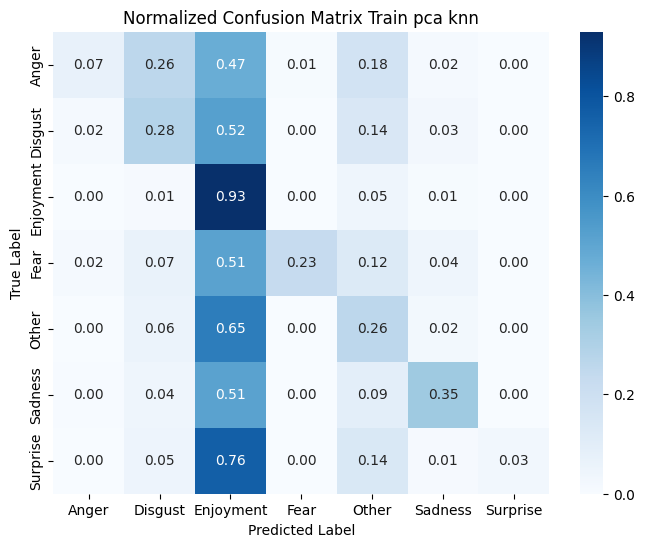

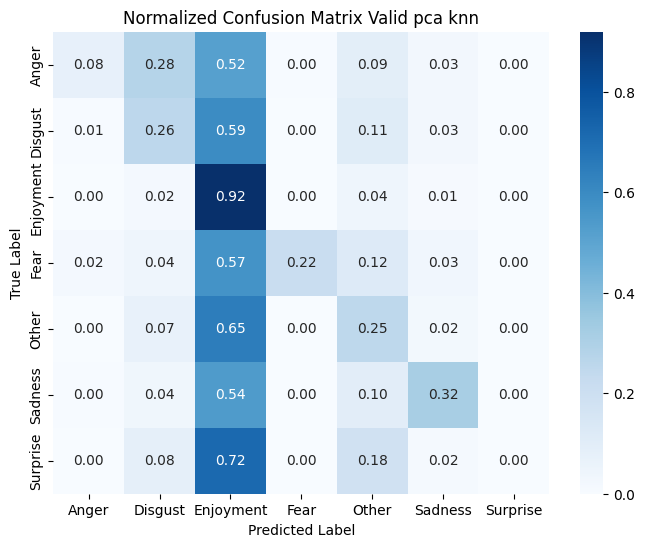

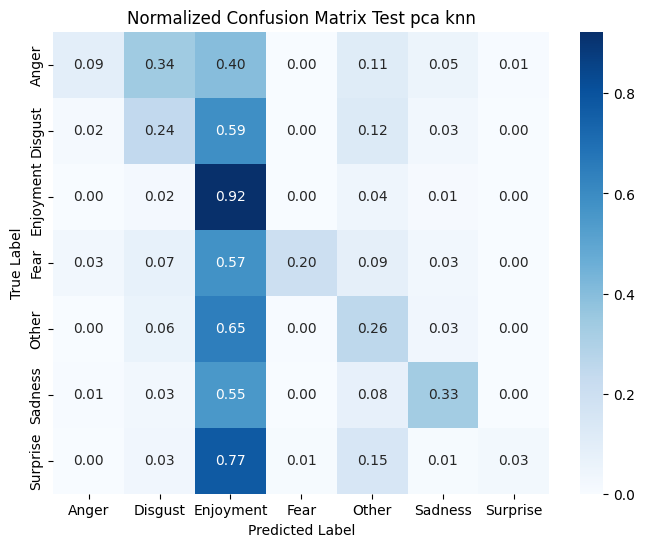

In [ ]:

model_pca_64_knn, train_pca_64_knn, valid_pca_64_knn, test_pca_64_knn, pred_pca_64_knn = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="knn",
    max_iter=1000
)

y_train_pca_64_knn, y_valid_pca_64_knn, y_test_pca_64_knn = train_pca_64_knn[1], valid_pca_64_knn[1], test_pca_64_knn[1]
y_pred_train_pca_64_knn, y_pred_valid_pca_64_knn, y_pred_test_pca_64_knn = pred_pca_64_knn

pipeline_evaluation(
    y_train_pca_64_knn, y_valid_pca_64_knn, y_test_pca_64_knn,
    y_pred_train_pca_64_knn, y_pred_valid_pca_64_knn, y_pred_test_pca_64_knn,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

In [ ]:
# KNN - euclidean - LDA (6:4)
model_lda_64_knn_euclidean, train_lda_64_knn_euclidean, valid_lda_64_knn_euclidean, test_lda_64_knn_euclidean, pred_lda_64_knn_euclidean = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="knn",
    metric="euclidean"
)

y_train_lda_64_knn_euclidean, y_valid_lda_64_knn_euclidean, y_test_lda_64_knn_euclidean = train_lda_64_knn_euclidean[1], valid_lda_64_knn_euclidean[1], test_lda_64_knn_euclidean[1]
y_pred_train_lda_64_knn_euclidean, y_pred_valid_lda_64_knn_euclidean, y_pred_test_lda_64_knn_euclidean = pred_lda_64_knn_euclidean

pipeline_evaluation(
    y_train_lda_64_knn_euclidean, y_valid_lda_64_knn_euclidean, y_test_lda_64_knn_euclidean,
    y_pred_train_lda_64_knn_euclidean, y_pred_valid_lda_64_knn_euclidean, y_pred_test_lda_64_knn_euclidean,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="knn_euclidean",
    show_plot=True
)

--- train --- 6:4 --- knn --- lda ---
Accuracy: 0.9957479706223424
Recall: 0.9957479706223424
Precision: 0.995773645160491
F1-score: 0.9957498543140142

--- valid --- 6:4 --- knn --- lda ---
Accuracy: 0.2591304347826087
Recall: 0.2591304347826087
Precision: 0.3395777991250579
F1-score: 0.27504245021872625

--- test --- 6:4 --- knn --- lda ---
Accuracy: 0.2569573283858998
Recall: 0.2569573283858998
Precision: 0.3262508422779436
F1-score: 0.2726266216165098


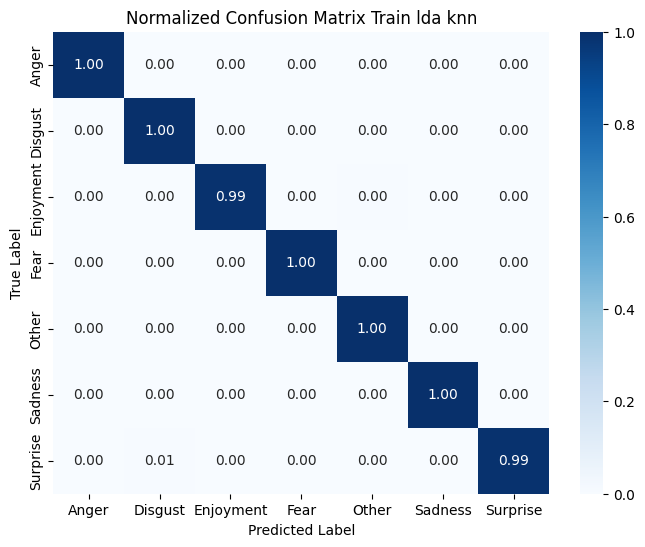

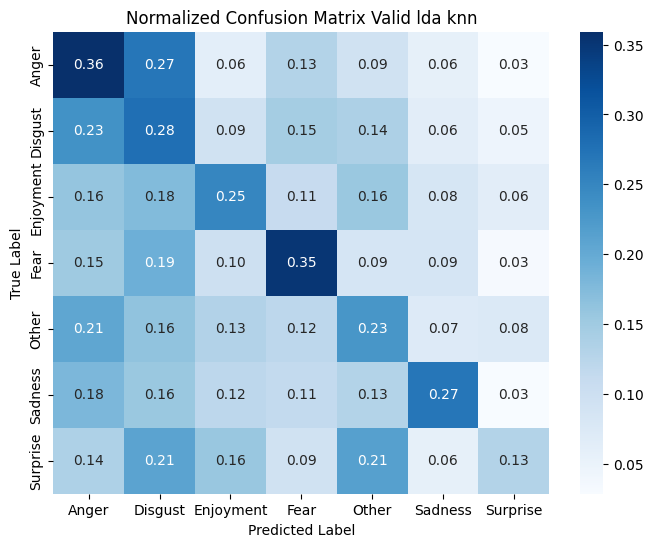

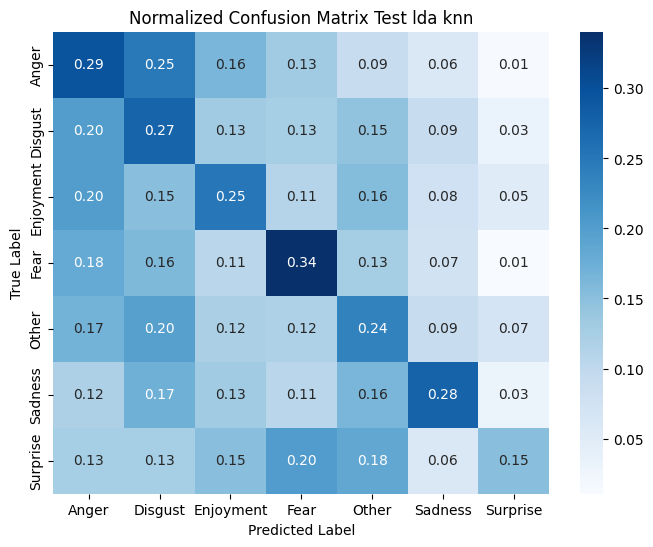

In [ ]:

model_lda_64_knn, train_lda_64_knn, valid_lda_64_knn, test_lda_64_knn, pred_lda_64_knn = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="knn",
    max_iter=1000
)

y_train_lda_64_knn, y_valid_lda_64_knn, y_test_lda_64_knn = train_lda_64_knn[1], valid_lda_64_knn[1], test_lda_64_knn[1]
y_pred_train_lda_64_knn, y_pred_valid_lda_64_knn, y_pred_test_lda_64_knn = pred_lda_64_knn

pipeline_evaluation(
    y_train_lda_64_knn, y_valid_lda_64_knn, y_test_lda_64_knn,
    y_pred_train_lda_64_knn, y_pred_valid_lda_64_knn, y_pred_test_lda_64_knn,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

## SVM

### Bộ dữ liệu gốc

In [ ]:
# SVM - linear - None (6:4)
model_64_svm_linear, train_64_svm_linear, valid_64_svm_linear, test_64_svm_linear, pred_64_svm_linear = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_64_svm_linear, y_valid_64_svm_linear, y_test_64_svm_linear = train_64_svm_linear[1], valid_64_svm_linear[1], test_64_svm_linear[1]
y_pred_train_64_svm_linear, y_pred_valid_64_svm_linear, y_pred_test_64_svm_linear = pred_64_svm_linear

pipeline_evaluation(
    y_train_64_svm_linear, y_valid_64_svm_linear, y_test_64_svm_linear,
    y_pred_train_64_svm_linear, y_pred_valid_64_svm_linear, y_pred_test_64_svm_linear,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="svm_linear",
    show_plot=True
)

In [ ]:
# SVM - poly - None (6:4)
model_64_svm_poly, train_64_svm_poly, valid_64_svm_poly, test_64_svm_poly, pred_64_svm_poly = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_64_svm_poly, y_valid_64_svm_poly, y_test_64_svm_poly = train_64_svm_poly[1], valid_64_svm_poly[1], test_64_svm_poly[1]
y_pred_train_64_svm_poly, y_pred_valid_64_svm_poly, y_pred_test_64_svm_poly = pred_64_svm_poly

pipeline_evaluation(
    y_train_64_svm_poly, y_valid_64_svm_poly, y_test_64_svm_poly,
    y_pred_train_64_svm_poly, y_pred_valid_64_svm_poly, y_pred_test_64_svm_poly,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="svm_poly",
    show_plot=True
)

In [ ]:
# SVM - rbf - None (6:4)
model_64_svm_rbf, train_64_svm_rbf, valid_64_svm_rbf, test_64_svm_rbf, pred_64_svm_rbf = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_64_svm_rbf, y_valid_64_svm_rbf, y_test_64_svm_rbf = train_64_svm_rbf[1], valid_64_svm_rbf[1], test_64_svm_rbf[1]
y_pred_train_64_svm_rbf, y_pred_valid_64_svm_rbf, y_pred_test_64_svm_rbf = pred_64_svm_rbf

pipeline_evaluation(
    y_train_64_svm_rbf, y_valid_64_svm_rbf, y_test_64_svm_rbf,
    y_pred_train_64_svm_rbf, y_pred_valid_64_svm_rbf, y_pred_test_64_svm_rbf,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="svm_rbf",
    show_plot=True
)

### Bộ dữ liệu PCA

In [ ]:
# SVM - linear - PCA (6:4)
model_pca_64_svm_linear, train_pca_64_svm_linear, valid_pca_64_svm_linear, test_pca_64_svm_linear, pred_pca_64_svm_linear = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_pca_64_svm_linear, y_valid_pca_64_svm_linear, y_test_pca_64_svm_linear = train_pca_64_svm_linear[1], valid_pca_64_svm_linear[1], test_pca_64_svm_linear[1]
y_pred_train_pca_64_svm_linear, y_pred_valid_pca_64_svm_linear, y_pred_test_pca_64_svm_linear = pred_pca_64_svm_linear

pipeline_evaluation(
    y_train_pca_64_svm_linear, y_valid_pca_64_svm_linear, y_test_pca_64_svm_linear,
    y_pred_train_pca_64_svm_linear, y_pred_valid_pca_64_svm_linear, y_pred_test_pca_64_svm_linear,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="svm_linear",
    show_plot=True
)

In [ ]:
# SVM - poly - PCA (6:4)
model_pca_64_svm_poly, train_pca_64_svm_poly, valid_pca_64_svm_poly, test_pca_64_svm_poly, pred_pca_64_svm_poly = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_pca_64_svm_poly, y_valid_pca_64_svm_poly, y_test_pca_64_svm_poly = train_pca_64_svm_poly[1], valid_pca_64_svm_poly[1], test_pca_64_svm_poly[1]
y_pred_train_pca_64_svm_poly, y_pred_valid_pca_64_svm_poly, y_pred_test_pca_64_svm_poly = pred_pca_64_svm_poly

pipeline_evaluation(
    y_train_pca_64_svm_poly, y_valid_pca_64_svm_poly, y_test_pca_64_svm_poly,
    y_pred_train_pca_64_svm_poly, y_pred_valid_pca_64_svm_poly, y_pred_test_pca_64_svm_poly,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="svm_poly",
    show_plot=True
)

In [ ]:
# SVM - rbf - PCA (6:4)
model_pca_64_svm_rbf, train_pca_64_svm_rbf, valid_pca_64_svm_rbf, test_pca_64_svm_rbf, pred_pca_64_svm_rbf = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_pca_64_svm_rbf, y_valid_pca_64_svm_rbf, y_test_pca_64_svm_rbf = train_pca_64_svm_rbf[1], valid_pca_64_svm_rbf[1], test_pca_64_svm_rbf[1]
y_pred_train_pca_64_svm_rbf, y_pred_valid_pca_64_svm_rbf, y_pred_test_pca_64_svm_rbf = pred_pca_64_svm_rbf

pipeline_evaluation(
    y_train_pca_64_svm_rbf, y_valid_pca_64_svm_rbf, y_test_pca_64_svm_rbf,
    y_pred_train_pca_64_svm_rbf, y_pred_valid_pca_64_svm_rbf, y_pred_test_pca_64_svm_rbf,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="svm_rbf",
    show_plot=True
)

### Bộ dữ liệu LDA

In [ ]:
# SVM - linear - LDA (6:4)
model_lda_64_svm_linear, train_lda_64_svm_linear, valid_lda_64_svm_linear, test_lda_64_svm_linear, pred_lda_64_svm_linear = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="svm",
    model_params={"C": 0.5, "svm_kernel": "linear"}
)

y_train_lda_64_svm_linear, y_valid_lda_64_svm_linear, y_test_lda_64_svm_linear = train_lda_64_svm_linear[1], valid_lda_64_svm_linear[1], test_lda_64_svm_linear[1]
y_pred_train_lda_64_svm_linear, y_pred_valid_lda_64_svm_linear, y_pred_test_lda_64_svm_linear = pred_lda_64_svm_linear

pipeline_evaluation(
    y_train_lda_64_svm_linear, y_valid_lda_64_svm_linear, y_test_lda_64_svm_linear,
    y_pred_train_lda_64_svm_linear, y_pred_valid_lda_64_svm_linear, y_pred_test_lda_64_svm_linear,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="svm_linear",
    show_plot=True
)

In [ ]:
# SVM - poly - LDA (6:4)
model_lda_64_svm_poly, train_lda_64_svm_poly, valid_lda_64_svm_poly, test_lda_64_svm_poly, pred_lda_64_svm_poly = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="svm",
    model_params={"C": 0.1, "svm_kernel": "poly", "svm_degree": 2}
)

y_train_lda_64_svm_poly, y_valid_lda_64_svm_poly, y_test_lda_64_svm_poly = train_lda_64_svm_poly[1], valid_lda_64_svm_poly[1], test_lda_64_svm_poly[1]
y_pred_train_lda_64_svm_poly, y_pred_valid_lda_64_svm_poly, y_pred_test_lda_64_svm_poly = pred_lda_64_svm_poly

pipeline_evaluation(
    y_train_lda_64_svm_poly, y_valid_lda_64_svm_poly, y_test_lda_64_svm_poly,
    y_pred_train_lda_64_svm_poly, y_pred_valid_lda_64_svm_poly, y_pred_test_lda_64_svm_poly,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="svm_poly",
    show_plot=True
)

In [ ]:
# SVM - rbf - LDA (6:4)
model_lda_64_svm_rbf, train_lda_64_svm_rbf, valid_lda_64_svm_rbf, test_lda_64_svm_rbf, pred_lda_64_svm_rbf = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="svm",
    model_params={"C": 1.0, "svm_kernel": "rbf", "svm_gamma": 1.0}
)

y_train_lda_64_svm_rbf, y_valid_lda_64_svm_rbf, y_test_lda_64_svm_rbf = train_lda_64_svm_rbf[1], valid_lda_64_svm_rbf[1], test_lda_64_svm_rbf[1]
y_pred_train_lda_64_svm_rbf, y_pred_valid_lda_64_svm_rbf, y_pred_test_lda_64_svm_rbf = pred_lda_64_svm_rbf

pipeline_evaluation(
    y_train_lda_64_svm_rbf, y_valid_lda_64_svm_rbf, y_test_lda_64_svm_rbf,
    y_pred_train_lda_64_svm_rbf, y_pred_valid_lda_64_svm_rbf, y_pred_test_lda_64_svm_rbf,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="svm_rbf",
    show_plot=True
)

# Xem kết quả dự đoán cho từng nhãn

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_73, y_pred_test_73, digits=4))

              precision    recall  f1-score   support

       Anger     0.4037    0.5752    0.4744       153
     Disgust     0.4755    0.4330    0.4532       358
   Enjoyment     0.7267    0.6201    0.6692       716
        Fear     0.5532    0.5532    0.5532        94
       Other     0.4568    0.4458    0.4512       415
     Sadness     0.6176    0.6545    0.6355       301
    Surprise     0.3005    0.4622    0.3642       119

    accuracy                         0.5455      2156
   macro avg     0.5048    0.5348    0.5144      2156
weighted avg     0.5638    0.5455    0.5509      2156



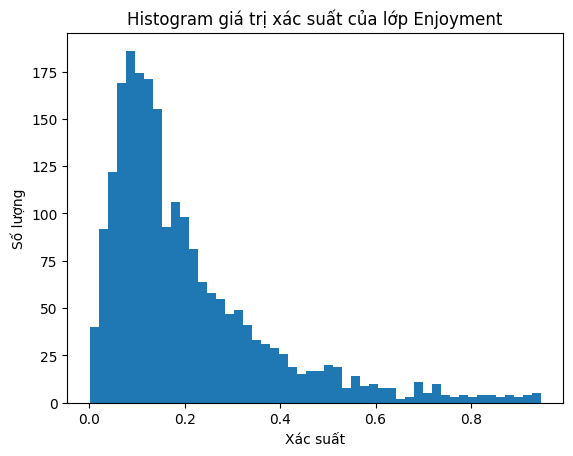

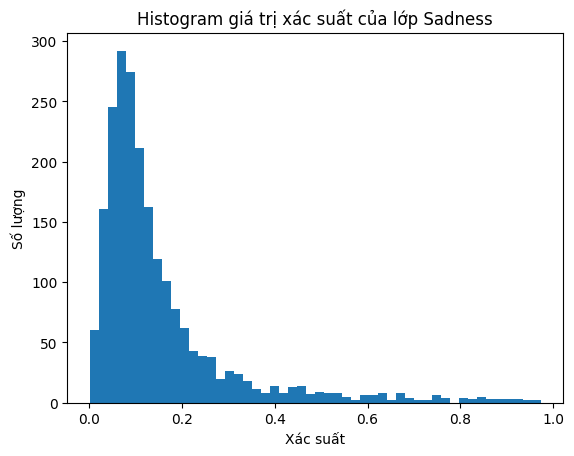

In [ ]:
def plot_score_hist(model, X, label_name):
    scores = model.predict_proba(X)       # Trả về giá trị hàm quyết định
    classes = list(model.classes_)       # Các lớp của mô hình 

    # Lấy index của lớp lable_name
    idx = classes.index(label_name)
    
    # Lấy ra cột score của nhãn label_name 
    score = scores[:, idx]  

    plt.figure()
    plt.hist(score, bins=50)
    plt.title(f"Histogram giá trị xác suất của lớp {label_name}")
    plt.xlabel("Xác suất")
    plt.ylabel("Số lượng")
    plt.show()
    
    return score
    
# Chọn 1 mô hình bất kì   
model = model_82         # model logistic regression đã huấn luyện
X_test_processed, y_test = test_82

score_enj = plot_score_hist(model, X_test_processed, "Enjoyment")
score_sad = plot_score_hist(model, X_test_processed, "Sadness")

Nhận xét: 


- Lớp Enjoyment có F1 cao nhất và số lượng nhãn lớn nhất => Ổn định, ít nhiễu hơn và ít giao động khi chia tập DL 

- Dựa vào histogram ta thấy phân bố của lớp Enjoyment khá mượt và trải rộng => có nhiều mức điểm khác nhau cho mô hình ==> phù hợp làm đầu ra hồi quy

- Lớp Sadness cũng là một sự lựa chọn ổn, tuy nhiên phân bố không quá đẹp, không ổn định bằng Enjoyment và F1-Score của 2 lớp này cũng không chênh lệch nhiều

=> Chọn đầu ra hồi quy là giá trị hàm quyết định của lớp Enjoyment

# Chuyển bài toán sang hồi quy


## Các hàm xử lý cho hồi quy

In [54]:
import numpy as np
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA


### Hàm lấy softmax probability của lớp Enjoyment


In [55]:
def get_enjoyment_score(model, X_data):

    # Lấy tất cả softmax probabilities cho tất cả các lớp
    probabilities = model.predict_proba(X_data)  # Shape: (n_samples, n_classes)
    
    # Tìm index của lớp Enjoyment
    classes = list(model.classes_)
    idx_enjoyment = classes.index("Enjoyment")
    
    # Lấy cột probability của lớp Enjoyment
    prob_enjoyment = probabilities[:, idx_enjoyment]
    
    return prob_enjoyment


### Hàm đánh giá mô hình hồi quy (MSE, MAE, R2)


In [56]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {"MSE": mse, "MAE": mae, "R2": r2}


### Hồi quy tuyến tính (L2 regularization)


In [57]:
# alpha: hệ số regularization
def train_ridge(X_train, y_train, alpha=1.0, random_state=11):
    ridge = Ridge(alpha=alpha, random_state=random_state)
    ridge.fit(X_train, y_train)
    return ridge


### KNN


In [58]:
def train_knn_regressor(X_train, y_train, metric='cosine', n_jobs=-1):
    k = int(np.sqrt(len(X_train)))
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric, n_jobs=n_jobs)
    knn.fit(X_train, y_train)
    return knn


### Hàm lựa chọn mô hình hồi quy


Hệ số cho mô hình
- model_type: loại mô hình
- alpha: hệ số regularization 
- metric: metric của KNN (cosine,...)

In [59]:
def use_regression_model(model_type, X_train, y_train, alpha=1.0, metric='cosine'):
    if model_type == "ridge":
        return train_ridge(X_train, y_train, alpha=alpha)
    elif model_type == "knn":
        return train_knn_regressor(X_train, y_train, metric=metric)
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Use 'ridge' or 'knn'")


### Hàm dự đoán hồi quy


In [60]:
def predict_regression(model, X_train, X_valid, X_test):
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    
    return y_pred_train, y_pred_valid, y_pred_test


### Hàm chuẩn bị dữ liệu 

- Input là dữ liệu sau TF-IDF của model lựa chọn (model đã trả về dữ liệu này)
- Lấy softmax probabilities từ model có kết quả phân loại tốt nhất (chọn model_73)
- Áp dụng PCA (1/3, tùy chọn)

In [61]:
def prepare_data_for_regression(classification_model, X_train_valid, X_test, 
                                 y_train_valid, y_test,
                                 train_size=7, valid_size=3,
                                 discriminant="none", n_components_pca=None, random_state=11):

    
    # 1. Lấy giá trị softmax probalilities từ classification_model cho train_valid và test
    z_train_valid = get_enjoyment_score(classification_model, X_train_valid)
    z_test = get_enjoyment_score(classification_model, X_test)
    
    # 2. Chia train_valid
    print(f"Tỉ lệ train - valid {train_size}:{valid_size}")
    X_train_reg, X_valid_reg, z_train_reg, z_valid_reg = train_test_split(
        X_train_valid, z_train_valid,
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=y_train_valid 
    )
    
    # 3. Giảm chiều (1/3, tùy chọn)
    if discriminant == 'pca':
        if n_components_pca is None:
            n_components_pca = max(1, int(X_train_reg.shape[1] / 3))
        
        print(f'PCA: {X_train_reg.shape[1]} -> {n_components_pca} chiều')
        pca_reducer = PCA(n_components=n_components_pca, random_state=random_state)
        X_train_processed = pca_reducer.fit_transform(X_train_reg)
        X_valid_processed = pca_reducer.transform(X_valid_reg)
        X_test_processed = pca_reducer.transform(X_test)
        
        print(f'PCA explained variance ratio: {pca_reducer.explained_variance_ratio_.sum():.4f}')
        discriminant_model = pca_reducer
    else:
        X_train_processed = X_train_reg
        X_valid_processed = X_valid_reg
        X_test_processed = X_test
        discriminant_model = None
    
    return (X_train_processed, X_valid_processed, X_test_processed,
            z_train_reg, z_valid_reg, z_test,
            discriminant_model)

## Pipeline hồi quy


In [62]:
def pipeline_regression(X_train, X_valid, X_test, z_train, z_valid, z_test,
                        regression_model_type='ridge', alpha=1.0, metric='cosine',
                        random_state=11):

    # Đặt lại tên cho tường minh
    X_reg_train, y_reg_train = X_train, z_train
    X_reg_valid, y_reg_valid = X_valid, z_valid
    X_reg_test, y_reg_test = X_test, z_test

    print(f'Tập hồi quy - Train: {X_reg_train.shape}, Valid: {X_reg_valid.shape}, Test: {X_reg_test.shape}')
    print()

    # Huấn luyện mô hình hồi quy
    regression_model = use_regression_model(regression_model_type, X_reg_train, y_reg_train,
                                            alpha=alpha, metric=metric)

    # Dự đoán
    y_pred_train, y_pred_valid, y_pred_test = predict_regression(
        regression_model, X_reg_train, X_reg_valid, X_reg_test
    )

    # Đánh giá mô hình
    metrics_train = evaluate_regression(y_reg_train, y_pred_train)
    metrics_valid = evaluate_regression(y_reg_valid, y_pred_valid)
    metrics_test = evaluate_regression(y_reg_test, y_pred_test)

    return (regression_model,
            (X_reg_train, X_reg_valid, X_reg_test),
            (y_reg_train, y_reg_valid, y_reg_test),
            (y_pred_train, y_pred_valid, y_pred_test),
            (metrics_train, metrics_valid, metrics_test))


## Hàm đánh giá và hiển thị kết quả


In [63]:
def pipeline_evaluation_regression(metrics_train, metrics_valid, metrics_test,
                                   regression_model_type, discriminant, data_type=""):
    print(f"=== {regression_model_type.upper()} Regression - {discriminant.upper()} {data_type} ===")
    print()
    
    print("--- Train ---")
    print(f"MSE = {metrics_train['MSE']:.6f}")
    print(f"MAE = {metrics_train['MAE']:.6f}")
    print(f"R2  = {metrics_train['R2']:.6f}")
    print()
    
    print("--- Valid ---")
    print(f"MSE = {metrics_valid['MSE']:.6f}")
    print(f"MAE = {metrics_valid['MAE']:.6f}")
    print(f"R2  = {metrics_valid['R2']:.6f}")
    print()
    
    print("--- Test ---")
    print(f"MSE = {metrics_test['MSE']:.6f}")
    print(f"MAE = {metrics_test['MAE']:.6f}")
    print(f"R2  = {metrics_test['R2']:.6f}")
    print()
    print("=" * 80)
    print()


## Tạo bộ dữ liệu hồi quy

In [64]:
import numpy as np

In [65]:
X_train_73_reg = train_73[0]
X_valid_73_reg = valid_73[0]
X_test_reg = test_73[0]
y_train_73_cls = train_73[1]
y_valid_73_cls = valid_73[1]
y_test_cls = test_73[1]

# Gộp train và valid thành train_valid
X_train_valid_reg = np.vstack([X_train_73_reg, X_valid_73_reg])
y_train_valid_reg = np.concatenate([y_train_73_cls, y_valid_73_cls])

print("============== Kích thước ===============")
print(f"train_valid: {X_train_valid_reg.shape}, test: {X_test_reg.shape}")
print(f"labels train_valid: {y_train_valid_reg.shape}, test: {y_test_cls.shape}")

============== Kích thước ===============
train_valid: (8420, 8000), test: (688, 8000)
labels train_valid: (8420,), test: (688,)


## Train:Validation = 8:2

### Hồi quy tuyến tính (Ridge L2)

#### Dữ liệu gốc

In [66]:
X_train_reg_82, X_valid_reg_82, X_test_reg_82, \
z_train_reg_82, z_valid_reg_82, z_test_reg_82, disc_model_reg_82 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=8,
    valid_size=2,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_82_model, X_reg_82, y_reg_82, y_pred_ridge_82, metrics_ridge_82 = pipeline_regression(
    X_train_reg_82, X_valid_reg_82, X_test_reg_82,
    z_train_reg_82, z_valid_reg_82, z_test_reg_82,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_82[0], metrics_ridge_82[1], metrics_ridge_82[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(8:2)"
)

Tỉ lệ train - valid 8:2
Tập hồi quy - Train: (6736, 8000), Valid: (1684, 8000), Test: (688, 8000)

=== RIDGE Regression - NONE (8:2) ===

--- Train ---
MSE = 0.001116
MAE = 0.024454
R2  = 0.953645

--- Valid ---
MSE = 0.002257
MAE = 0.034803
R2  = 0.914325

--- Test ---
MSE = 0.001792
MAE = 0.029029
R2  = 0.925737




#### Dữ liệu PCA

In [67]:
X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82, \
z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82, disc_model_reg_pca_82 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=8,
    valid_size=2,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính = 1/3 rồi nên không cần nữa
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_82_model, X_reg_pca_82, y_reg_pca_82, y_pred_ridge_pca_82, metrics_ridge_pca_82 = pipeline_regression(
    X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82,
    z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_82[0], metrics_ridge_pca_82[1], metrics_ridge_pca_82[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(8:2)"
)

Tỉ lệ train - valid 8:2
PCA: 8000 -> 2666 chiều
PCA explained variance ratio: 0.9047
Tập hồi quy - Train: (6736, 2666), Valid: (1684, 2666), Test: (688, 2666)

=== RIDGE Regression - PCA (8:2) ===

--- Train ---
MSE = 0.001323
MAE = 0.026846
R2  = 0.945064

--- Valid ---
MSE = 0.002392
MAE = 0.035969
R2  = 0.909168

--- Test ---
MSE = 0.001815
MAE = 0.029254
R2  = 0.924797




### KNN

#### Bộ dữ liệu không giảm chiều 

In [68]:
# KNN / None
knn_82_model, X_reg_82_knn, y_reg_82_knn, y_pred_knn_82, metrics_knn_82 = pipeline_regression(
    X_train_reg_82, X_valid_reg_82, X_test_reg_82,
    z_train_reg_82, z_valid_reg_82, z_test_reg_82,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_82[0], metrics_knn_82[1], metrics_knn_82[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(8:2)"
)

Tập hồi quy - Train: (6736, 8000), Valid: (1684, 8000), Test: (688, 8000)

=== KNN Regression - NONE (8:2) ===

--- Train ---
MSE = 0.009749
MAE = 0.076374
R2  = 0.595162

--- Valid ---
MSE = 0.010577
MAE = 0.078695
R2  = 0.598425

--- Test ---
MSE = 0.009548
MAE = 0.070670
R2  = 0.604385




In [69]:
# KNN / PCA
knn_pca_82_model, X_reg_pca_82_knn, y_reg_pca_82_knn, y_pred_knn_pca_82, metrics_knn_pca_82 = pipeline_regression(
    X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82,
    z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_82[0], metrics_knn_pca_82[1], metrics_knn_pca_82[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(8:2)"
)

Tập hồi quy - Train: (6736, 2666), Valid: (1684, 2666), Test: (688, 2666)

=== KNN Regression - PCA (8:2) ===

--- Train ---
MSE = 0.009847
MAE = 0.076372
R2  = 0.591105

--- Valid ---
MSE = 0.010644
MAE = 0.078574
R2  = 0.595872

--- Test ---
MSE = 0.009600
MAE = 0.070612
R2  = 0.602230




## Train:Validation = 7:3

### Ridge Regression

#### Bộ dữ liệu không giảm chiều

In [70]:
# Chuẩn bị dữ liệu
X_train_reg_73, X_valid_reg_73, X_test_reg_73, \
z_train_reg_73, z_valid_reg_73, z_test_reg_73, disc_model_reg_73 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=7,
    valid_size=3,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_73_model, X_reg_73, y_reg_73, y_pred_ridge_73, metrics_ridge_73 = pipeline_regression(
    X_train_reg_73, X_valid_reg_73, X_test_reg_73,
    z_train_reg_73, z_valid_reg_73, z_test_reg_73,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_73[0], metrics_ridge_73[1], metrics_ridge_73[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(7:3)"
)

Tỉ lệ train - valid 7:3
Tập hồi quy - Train: (5894, 8000), Valid: (2526, 8000), Test: (688, 8000)

=== RIDGE Regression - NONE (7:3) ===

--- Train ---
MSE = 0.001162
MAE = 0.024854
R2  = 0.952100

--- Valid ---
MSE = 0.002378
MAE = 0.035926
R2  = 0.905512

--- Test ---
MSE = 0.001899
MAE = 0.029716
R2  = 0.921332




### Bộ dữ liệu PCA

In [71]:
# Chuẩn bị dữ liệu 
X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73, \
z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73, disc_model_reg_pca_73 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=7,
    valid_size=3,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính 1/3 rồi nên không cần nữa 
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_73_model, X_reg_pca_73, y_reg_pca_73, y_pred_ridge_pca_73, metrics_ridge_pca_73 = pipeline_regression(
    X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73,
    z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_73[0], metrics_ridge_pca_73[1], metrics_ridge_pca_73[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(7:3)"
)

Tỉ lệ train - valid 7:3
PCA: 8000 -> 2666 chiều
PCA explained variance ratio: 0.9186
Tập hồi quy - Train: (5894, 2666), Valid: (2526, 2666), Test: (688, 2666)

=== RIDGE Regression - PCA (7:3) ===

--- Train ---
MSE = 0.001342
MAE = 0.026889
R2  = 0.944686

--- Valid ---
MSE = 0.002501
MAE = 0.036887
R2  = 0.900629

--- Test ---
MSE = 0.001924
MAE = 0.030130
R2  = 0.920277




### KNN

#### Bộ dữ liệu không giảm chiều

In [72]:
# KNN / None
knn_73_model, X_reg_73_knn, y_reg_73_knn, y_pred_knn_73, metrics_knn_73 = pipeline_regression(
    X_train_reg_73, X_valid_reg_73, X_test_reg_73,
    z_train_reg_73, z_valid_reg_73, z_test_reg_73,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_73[0], metrics_knn_73[1], metrics_knn_73[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(7:3)"
)

Tập hồi quy - Train: (5894, 8000), Valid: (2526, 8000), Test: (688, 8000)



=== KNN Regression - NONE (7:3) ===

--- Train ---
MSE = 0.010023
MAE = 0.076991
R2  = 0.586895

--- Valid ---
MSE = 0.010602
MAE = 0.078559
R2  = 0.578758

--- Test ---
MSE = 0.009772
MAE = 0.071039
R2  = 0.595089




In [73]:
# KNN / PCA
knn_pca_73_model, X_reg_pca_73_knn, y_reg_pca_73_knn, y_pred_knn_pca_73, metrics_knn_pca_73 = pipeline_regression(
    X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73,
    z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_73[0], metrics_knn_pca_73[1], metrics_knn_pca_73[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(7:3)"
)

Tập hồi quy - Train: (5894, 2666), Valid: (2526, 2666), Test: (688, 2666)

=== KNN Regression - PCA (7:3) ===

--- Train ---
MSE = 0.010098
MAE = 0.077054
R2  = 0.583781

--- Valid ---
MSE = 0.010631
MAE = 0.078641
R2  = 0.577617

--- Test ---
MSE = 0.009772
MAE = 0.070872
R2  = 0.595111




## Train:Validation = 6:4

### Ridge Regression

#### Bộ dữ liệu không giảm chiều

In [74]:
# Chuẩn bị dữ liệu
X_train_reg_64, X_valid_reg_64, X_test_reg_64, \
z_train_reg_64, z_valid_reg_64, z_test_reg_64, disc_model_reg_64 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=6,
    valid_size=4,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_64_model, X_reg_64, y_reg_64, y_pred_ridge_64, metrics_ridge_64 = pipeline_regression(
    X_train_reg_64, X_valid_reg_64, X_test_reg_64,
    z_train_reg_64, z_valid_reg_64, z_test_reg_64,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_64[0], metrics_ridge_64[1], metrics_ridge_64[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(6:4)"
)

Tỉ lệ train - valid 6:4
Tập hồi quy - Train: (5052, 8000), Valid: (3368, 8000), Test: (688, 8000)

=== RIDGE Regression - NONE (6:4) ===

--- Train ---
MSE = 0.001217
MAE = 0.025224
R2  = 0.949798

--- Valid ---
MSE = 0.002688
MAE = 0.037852
R2  = 0.892353

--- Test ---
MSE = 0.001987
MAE = 0.030201
R2  = 0.917682




#### Bộ dữ liệu sau khi PCA

In [75]:
# Chuẩn bị dữ liệu 
X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64, \
z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64, disc_model_reg_pca_64 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=6,
    valid_size=4,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính = 1/3 số chiều
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_64_model, X_reg_pca_64, y_reg_pca_64, y_pred_ridge_pca_64, metrics_ridge_pca_64 = pipeline_regression(
    X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64,
    z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_64[0], metrics_ridge_pca_64[1], metrics_ridge_pca_64[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(6:4)"
)

Tỉ lệ train - valid 6:4
PCA: 8000 -> 2666 chiều
PCA explained variance ratio: 0.9356
Tập hồi quy - Train: (5052, 2666), Valid: (3368, 2666), Test: (688, 2666)

=== RIDGE Regression - PCA (6:4) ===

--- Train ---
MSE = 0.001357
MAE = 0.026788
R2  = 0.943996

--- Valid ---
MSE = 0.002784
MAE = 0.038576
R2  = 0.888521

--- Test ---
MSE = 0.002031
MAE = 0.030658
R2  = 0.915836




## KNN

### Bộ dữ liệu không giảm chiều

In [76]:
# KNN / None
knn_64_model, X_reg_64_knn, y_reg_64_knn, y_pred_knn_64, metrics_knn_64 = pipeline_regression(
    X_train_reg_64, X_valid_reg_64, X_test_reg_64,
    z_train_reg_64, z_valid_reg_64, z_test_reg_64,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_64[0], metrics_knn_64[1], metrics_knn_64[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(6:4)"
)

Tập hồi quy - Train: (5052, 8000), Valid: (3368, 8000), Test: (688, 8000)

=== KNN Regression - NONE (6:4) ===

--- Train ---
MSE = 0.010264
MAE = 0.077544
R2  = 0.576529

--- Valid ---
MSE = 0.010819
MAE = 0.078842
R2  = 0.566759

--- Test ---
MSE = 0.009799
MAE = 0.071130
R2  = 0.593991




#### Bộ dữ liệu sau PCA

In [77]:
# KNN / PCA
knn_pca_64_model, X_reg_pca_64_knn, y_reg_pca_64_knn, y_pred_knn_pca_64, metrics_knn_pca_64 = pipeline_regression(
    X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64,
    z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_64[0], metrics_knn_pca_64[1], metrics_knn_pca_64[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(6:4)"
)

Tập hồi quy - Train: (5052, 2666), Valid: (3368, 2666), Test: (688, 2666)

=== KNN Regression - PCA (6:4) ===

--- Train ---
MSE = 0.010337
MAE = 0.077624
R2  = 0.573544

--- Valid ---
MSE = 0.010811
MAE = 0.078680
R2  = 0.567059

--- Test ---
MSE = 0.009863
MAE = 0.071248
R2  = 0.591348




# So sánh và đánh giá kết quả

In [78]:
# Tạo bảng so sánh kết quả
print("=" * 100)
print("BẢNG SO SÁNH KẾT QUẢ HỒI QUY")
print("=" * 100)
print(f"{'Mô hình':<25} {'Tỉ lệ':<10} {'Dữ liệu':<15} {'MSE (Test)':<15} {'MAE (Test)':<15} {'R2 (Test)':<15}")
print("-" * 100)
print(f"{'Ridge Regression':<25} {'8:2':<10} {'Gốc':<15} {metrics_ridge_82[2]['MSE']:<15.6f} {metrics_ridge_82[2]['MAE']:<15.6f} {metrics_ridge_82[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'8:2':<10} {'PCA':<15} {metrics_ridge_pca_82[2]['MSE']:<15.6f} {metrics_ridge_pca_82[2]['MAE']:<15.6f} {metrics_ridge_pca_82[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'7:3':<10} {'Gốc':<15} {metrics_ridge_73[2]['MSE']:<15.6f} {metrics_ridge_73[2]['MAE']:<15.6f} {metrics_ridge_73[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'7:3':<10} {'PCA':<15} {metrics_ridge_pca_73[2]['MSE']:<15.6f} {metrics_ridge_pca_73[2]['MAE']:<15.6f} {metrics_ridge_pca_73[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'6:4':<10} {'Gốc':<15} {metrics_ridge_64[2]['MSE']:<15.6f} {metrics_ridge_64[2]['MAE']:<15.6f} {metrics_ridge_64[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'6:4':<10} {'PCA':<15} {metrics_ridge_pca_64[2]['MSE']:<15.6f} {metrics_ridge_pca_64[2]['MAE']:<15.6f} {metrics_ridge_pca_64[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'8:2':<10} {'Gốc':<15} {metrics_knn_82[2]['MSE']:<15.6f} {metrics_knn_82[2]['MAE']:<15.6f} {metrics_knn_82[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'8:2':<10} {'PCA':<15} {metrics_knn_pca_82[2]['MSE']:<15.6f} {metrics_knn_pca_82[2]['MAE']:<15.6f} {metrics_knn_pca_82[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'7:3':<10} {'Gốc':<15} {metrics_knn_73[2]['MSE']:<15.6f} {metrics_knn_73[2]['MAE']:<15.6f} {metrics_knn_73[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'7:3':<10} {'PCA':<15} {metrics_knn_pca_73[2]['MSE']:<15.6f} {metrics_knn_pca_73[2]['MAE']:<15.6f} {metrics_knn_pca_73[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'6:4':<10} {'Gốc':<15} {metrics_knn_64[2]['MSE']:<15.6f} {metrics_knn_64[2]['MAE']:<15.6f} {metrics_knn_64[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'6:4':<10} {'PCA':<15} {metrics_knn_pca_64[2]['MSE']:<15.6f} {metrics_knn_pca_64[2]['MAE']:<15.6f} {metrics_knn_pca_64[2]['R2']:<15.6f}")
print("=" * 100)


BẢNG SO SÁNH KẾT QUẢ HỒI QUY
Mô hình                   Tỉ lệ      Dữ liệu         MSE (Test)      MAE (Test)      R2 (Test)      
----------------------------------------------------------------------------------------------------
Ridge Regression          8:2        Gốc             0.001792        0.029029        0.925737       
Ridge Regression          8:2        PCA             0.001815        0.029254        0.924797       
Ridge Regression          7:3        Gốc             0.001899        0.029716        0.921332       
Ridge Regression          7:3        PCA             0.001924        0.030130        0.920277       
Ridge Regression          6:4        Gốc             0.001987        0.030201        0.917682       
Ridge Regression          6:4        PCA             0.002031        0.030658        0.915836       
KNN Regressor             8:2        Gốc             0.009548        0.070670        0.604385       
KNN Regressor             8:2        PCA             0.009600 

In [79]:
def plot_regression_correlation(y_true, y_pred, title='Correlation'):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f"{title} (corr={corr:.4f})")
    plt.grid(True, alpha=0.3)
    plt.show()
    return corr
